# CATE meta-model selection
The purpose of this notebook is to discern which statistical/ML model(s) we should use in our CATE estimators.

### CATE Estimators
 - Double machine learning CATE estimators predict $Y$ from $X,W \rightarrow$ `model_y`, as well as predict $T$ from $X,W \rightarrow$ `model_t` to estiamte the CATE

 - Doubly robust methods are similar to double machine learning, however the treatment variable $T$ is included as a feature in `model_y`. There is also a `model_final` which amalgamates these results.

In [4]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc 
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [5]:
# I/O Stuff
DATA_FILENAME = "csdh_final.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [6]:
# MIN DAG features
min_features = ['age', 'thickness_sum', 'antiplatelet', 'drain', 'recurrence']

In [7]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [8]:
# Define reduced datasets
csdh_min = csdh[min_features]

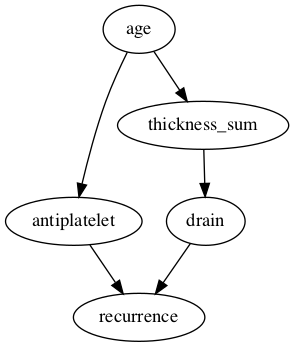

In [9]:
min_model = CausalModel(data=csdh_min, 
                        treatment='drain', 
                        outcome='recurrence', 
                        graph='../causal_graphs/min_dag.dot'.replace("\n", " "))
min_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate and hyperparameters

In [10]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [11]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

In [12]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [13]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}

In [14]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

---
## Predicting $T$ (drain) from controls $X, W$

In [15]:
y_drain_full = csdh_min['drain']
X_drain_full = csdh_min.drop(['drain', 'recurrence'], axis=1)

In [16]:
# Split into validation set and rest
X_drain_rest, X_drain_test, y_drain_rest, y_drain_test = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.20,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_val, y_drain_train, y_drain_val = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.20,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [20]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

[13:43:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
LR            0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
Linear SVM    0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
RBF SVM       0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
GB            0.800    0.500    0.950    0.888   6.908    0.891    0.667    1.000    0.939    3.773
RF            0.800    0.520    0.940    0.887   6.908    0.971    0.915    0.997    0.983    1.016
XGB           0.775    0.485    0.920    0.872 


## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [22]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_5,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='log2',
                                            n_estimators=71, random_state=100,
                                            subsample=0.75))])
cv score: [0.48325    0.52289474 0.46473684 0.51489899 0.57727273]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
 

cv score: [0.52375    0.54894737 0.38789474 0.50454545 0.49191919]
----------------------------------------
Trial 13
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=73,
                               n_jobs=None, num_parallel_tree=

cv score: [0.51275    0.59684211 0.50921053 0.50757576 0.54191919]
----------------------------------------
Trial 25
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=57, random_state=100,
                                            subsample=0.8))])
cv score: [0.48875    0.54605263 0.51263158 0.45454545 0.52171717]
----------------------------------------
Trial 26
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.51425    0.59131579 0.49894737 0.50757576 0.5489899 ]
----------------------------------------
Trial 34
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=162,
                                        random_state=100))])
cv score: [0.52925    0.62289474 0.53552632 0.53080808 0.5719697 ]
----------------------------------------
Trial 35
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.51875    0.53710526 0.38736842 0.49090909 0.51010101]
----------------------------------------
Trial 45
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_parallel_

cv score: [0.51825    0.49815789 0.37157895 0.42626263 0.50757576]
----------------------------------------
Trial 55
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='log2',
                                            n_estimators=138, random_state=100,
                                            subsample=0.95))])
cv score: [0.48075    0.42026316 0.50157895 0.4479798  0.42878788]
----------------------------------------
Trial 56
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

                                        random_state=100))])
cv score: [0.5065     0.58       0.57368421 0.52373737 0.57777778]
----------------------------------------
Trial 69
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            n_estimators=56, random_state=100,
                                            subsample=0.6))])
cv score: [0.48375    0.48763158 0.48473684 0.39393939 0.5459596 ]
----------------------------------------
Trial 70
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=

cv score: [0.46375    0.44552632 0.41131579 0.4959596  0.51010101]
----------------------------------------
Trial 81
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='log2',
                                            n_estimators=33, random_state=100,
                                            subsample=0.85))])
cv score: [0.50675    0.56289474 0.50263158 0.51717172 0.53106061]
----------------------------------------
Trial 82
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.6075     0.73289474 0.56763158 0.4979798  0.62323232]
----------------------------------------
Trial 93
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='log2',
                                            n_estimators=131, random_state=100,
                                            subsample=0.85))])
cv score: [0.48325    0.47131579 0.46184211 0.42323232 0.52272727]
----------------------------------------
Trial 94
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.51775    0.54026316 0.44526316 0.4479798  0.51161616]
----------------------------------------
Trial 103
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=65,
                                        random_state=100))])
cv score: [0.5135     0.60368421 0.51157895 0.52247475 0.55959596]
----------------------------------------
Trial 104
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=5

cv score: [0.49675    0.43578947 0.40631579 0.4020202  0.54848485]
----------------------------------------
Trial 116
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=190, random_state=100))])
cv score: [0.55975    0.62184211 0.52157895 0.5040404  0.57272727]
----------------------------------------
Trial 117
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=16, random_state=100))])
cv score: [0.5645     0.52578947 0.52447368 0.

cv score: [0.47925    0.51131579 0.48157895 0.43080808 0.48030303]
----------------------------------------
Trial 127
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=14,
                                            max_features='log2',
                                            n_estimators=171, random_state=100,
                                            subsample=0.75))])
cv score: [0.51675    0.51447368 0.52315789 0.43585859 0.53686869]
----------------------------------------
Trial 128
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.55675    0.50184211 0.42184211 0.43282828 0.42979798]
----------------------------------------
Trial 140
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            n_estimators=101, random_state=100,
                                            subsample=0.8))])
cv score: [0.46975    0.48710526 0.41421053 0.41616162 0.52575758]
----------------------------------------
Trial 141
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.44075    0.56289474 0.46736842 0.45707071 0.4989899 ]
----------------------------------------
Trial 149
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=104,
                               n_jobs=None, num_parall

cv score: [0.53025    0.53368421 0.47105263 0.44141414 0.45555556]
----------------------------------------
Trial 160
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=198,
                                        random_state=100))])
cv score: [0.52475    0.49157895 0.47921053 0.43383838 0.46010101]
----------------------------------------
Trial 161
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                    

cv score: [0.50825    0.50026316 0.44684211 0.43181818 0.54444444]
----------------------------------------
Trial 172
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_parallel_tree

                               validate_parameters=None, verbosity=None))])
cv score: [0.47825    0.56       0.40921053 0.50707071 0.51767677]
----------------------------------------
Trial 181
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_

cv score: [0.5805     0.68263158 0.56131579 0.53232323 0.61590909]
----------------------------------------
Trial 192
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=113, random_state=100,
                                            subsample=0.6))])
cv score: [0.50225    0.53447368 0.46105263 0.49242424 0.60934343]
----------------------------------------
Trial 193
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.56475    0.64052632 0.52210526 0.52878788 0.59292929]
----------------------------------------
Trial 204
----------------------------------------
Parameters {'rf__n_estimators': 30, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=30, random_state=100))])
cv score: [0.4815     0.525      0.49131579 0.48257576 0.49974747]
----------------------------------------
Trial 205
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=164,
                                        rando

cv score: [0.51125    0.44       0.35631579 0.45126263 0.45984848]
----------------------------------------
Trial 218
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=44, random_state=100))])
cv score: [0.516      0.51       0.47973684 0.46616162 0.50454545]
----------------------------------------
Trial 219
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=182, random_state=100))])
cv score: [0.52575    0.55394737 0.5215789

cv score: [0.53125    0.52078947 0.35052632 0.4540404  0.50505051]
----------------------------------------
Trial 232
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=54,
                                        random_state=100))])
cv score: [0.54425    0.56236842 0.49710526 0.48181818 0.51590909]
----------------------------------------
Trial 233
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.58575    0.63394737 0.56236842 0.50176768 0.64621212]
----------------------------------------
Trial 245
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=172,
                               n_jobs=None, num_parallel

cv score: [0.51875    0.47842105 0.36789474 0.46666667 0.49494949]
----------------------------------------
Trial 257
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=56,
                               n_jobs=None, num_parallel_tree=

cv score: [0.54225    0.66394737 0.48894737 0.52070707 0.55707071]
----------------------------------------
Trial 266
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel

cv score: [0.52675    0.51026316 0.38894737 0.41717172 0.5020202 ]
----------------------------------------
Trial 276
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=61, random_state=100,
                                            subsample=0.75))])
cv score: [0.47925    0.53315789 0.48736842 0.50656566 0.56767677]
----------------------------------------
Trial 277
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynod

cv score: [0.515      0.54473684 0.50789474 0.51489899 0.52575758]
----------------------------------------
Trial 288
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=84,
                                            random_state=100))])
cv score: [0.4775     0.52078947 0.45315789 0.49924242 0.56186869]
----------------------------------------
Trial 289
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
         

cv score: [0.552      0.60368421 0.49973684 0.52171717 0.58434343]
----------------------------------------
Trial 296
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=36,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.51175    0.50868421 0.48263158 0.43333333 0.55505051]
----------------------------------------
Trial 308
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=60, random_state=100,
                                            subsample=0.65))])
cv score: [0.477      0.62605263 0.43210526 0.43686869 0.48838384]
----------------------------------------
Trial 309
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.6035     0.73578947 0.59131579 0.52828283 0.64747475]
----------------------------------------
Trial 321
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
                               n_jobs=None, num_parallel_tree

cv score: [0.45025    0.52394737 0.47789474 0.40227273 0.50606061]
----------------------------------------
Trial 330
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=81,
                               n_jobs=None, num_parallel_t

cv score: [0.51525    0.52236842 0.49578947 0.43030303 0.5469697 ]
----------------------------------------
Trial 339
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=31,
                                            random_state=100, subsample=0.6))])
cv score: [0.51625    0.52236842 0.47263158 0.38308081 0.54848485]
----------------------------------------
Trial 340
----------------------------------------
Parameters {'xgb__n_estimators': 158, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, c

cv score: [0.48075    0.63105263 0.55447368 0.55151515 0.55681818]
----------------------------------------
Trial 350
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=135,
                               n_jobs=None, num_parallel_tr

cv score: [0.4965     0.49947368 0.43263158 0.46666667 0.55505051]
----------------------------------------
Trial 359
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            n_estimators=118, random_state=100,
                                            subsample=0.6))])
cv score: [0.47825    0.49921053 0.45894737 0.44292929 0.53080808]
----------------------------------------
Trial 360
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='sqrt',
  

cv score: [0.57425    0.71131579 0.59526316 0.51212121 0.6219697 ]
----------------------------------------
Trial 370
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='log2',
                                            n_estimators=105, random_state=100,
                                            subsample=0.65))])
cv score: [0.5675     0.64815789 0.53315789 0.53080808 0.60808081]
----------------------------------------
Trial 371
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.4845     0.42184211 0.45973684 0.42222222 0.47020202]
----------------------------------------
Trial 381
----------------------------------------
Parameters {'xgb__n_estimators': 17, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=17,
                               n_jobs=None, num_parallel_tr

cv score: [0.52025    0.50289474 0.48157895 0.38232323 0.57575758]
----------------------------------------
Trial 391
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=74, random_state=100,
                                            subsample=0.9))])
cv score: [0.519      0.67552632 0.58447368 0.55656566 0.56893939]
----------------------------------------
Trial 392
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                 

cv score: [0.58325    0.70842105 0.57631579 0.53131313 0.63762626]
----------------------------------------
Trial 402
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=164,
                               n_jobs=None, num_parallel_tr

cv score: [0.47225    0.51973684 0.46894737 0.41565657 0.44646465]
----------------------------------------
Trial 413
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel_tree

cv score: [0.51475    0.58657895 0.49578947 0.50505051 0.54747475]
----------------------------------------
Trial 425
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=87, random_state=100,
                                            subsample=0.7))])
cv score: [0.51975    0.63289474 0.55631579 0.45934343 0.45580808]
----------------------------------------
Trial 426
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Grad

cv score: [0.46025    0.58131579 0.39578947 0.39318182 0.41313131]
----------------------------------------
Trial 437
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=195, random_state=100))])
cv score: [0.59575    0.69026316 0.55947368 0.54747475 0.64217172]
----------------------------------------
Trial 438
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
         

cv score: [0.51075    0.46289474 0.38526316 0.4459596  0.49747475]
----------------------------------------
Trial 447
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='log2',
                                            n_estimators=138, random_state=100,
                                            subsample=0.75))])
cv score: [0.49925    0.48868421 0.51631579 0.49646465 0.38535354]
----------------------------------------
Trial 448
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.4        0.47631579 0.43815789 0.42348485 0.56868687]
----------------------------------------
Trial 458
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=88, random_state=100))])
cv score: [0.535      0.55657895 0.47105263 0.43232323 0.55353535]
----------------------------------------
Trial 459
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=37, random_state=100))])
cv score: [0.60975    0.65894737 0.59078947 0.5219

cv score: [0.60275    0.74026316 0.54052632 0.54974747 0.66868687]
----------------------------------------
Trial 469
----------------------------------------
Parameters {'xgb__n_estimators': 15, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=15,
                               n_jobs=None, num_parallel_tre

cv score: [0.598      0.72973684 0.59921053 0.5260101  0.65151515]
----------------------------------------
Trial 480
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=119, random_state=100))])
cv score: [0.59675    0.73       0.56       0.54646465 0.625     ]
----------------------------------------
Trial 481
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=95,
                                        random_state=

cv score: [0.56225    0.56131579 0.52894737 0.49873737 0.52878788]
----------------------------------------
Trial 491
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=126,
                               n_jobs=None, num_parallel_t

cv score: [0.40625    0.54184211 0.50842105 0.4469697  0.49646465]
----------------------------------------
Trial 504
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=145,
                               n_jobs=None, num_parallel_t

cv score: [0.5495     0.61394737 0.52473684 0.4510101  0.60732323]
----------------------------------------
Trial 514
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=152, random_state=100,
                                            subsample=0.95))])
cv score: [0.45975    0.45710526 0.45473684 0.4520202  0.45858586]
----------------------------------------
Trial 515
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.51125    0.53236842 0.47789474 0.46515152 0.56767677]
----------------------------------------
Trial 523
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=46,
                                        random_state=100))])
cv score: [0.466      0.53342105 0.44842105 0.46212121 0.47929293]
----------------------------------------
Trial 524
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.51875    0.54710526 0.49210526 0.46666667 0.52777778]
----------------------------------------
Trial 533
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_paralle

cv score: [0.515      0.60210526 0.525      0.5280303  0.56944444]
----------------------------------------
Trial 543
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='sqrt',
                                            n_estimators=161, random_state=100,
                                            subsample=0.65))])
cv score: [0.48275    0.50078947 0.48263158 0.42121212 0.53232323]
----------------------------------------
Trial 544
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,

cv score: [0.488      0.50315789 0.49473684 0.54292929 0.52727273]
----------------------------------------
Trial 553
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=66, random_state=100))])
cv score: [0.5145     0.52026316 0.49868421 0.47424242 0.50909091]
----------------------------------------
Trial 554
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=112, random_state=100))])
cv score: [0.538      0.56447368 0.5189473

cv score: [0.49725    0.52605263 0.45894737 0.40909091 0.47222222]
----------------------------------------
Trial 566
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=146, random_state=100,
                                            subsample=0.95))])
cv score: [0.42375    0.48131579 0.49526316 0.42525253 0.5       ]
----------------------------------------
Trial 567
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.48375    0.49815789 0.46631579 0.42171717 0.44292929]
----------------------------------------
Trial 578
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=79,
                                        random_state=100))])
cv score: [0.5155     0.59842105 0.52526316 0.5239899  0.57373737]
----------------------------------------
Trial 579
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                           

cv score: [0.50925    0.52868421 0.43342105 0.42954545 0.63333333]
----------------------------------------
Trial 588
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=134,
                                            random_state=100))])
cv score: [0.47625    0.50868421 0.46210526 0.43282828 0.46060606]
----------------------------------------
Trial 589
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, m

cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66641414]
----------------------------------------
Trial 601
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            n_estimators=142, random_state=100,
                                            subsample=0.6))])
cv score: [0.57225    0.47236842 0.42631579 0.4469697  0.42626263]
----------------------------------------
Trial 602
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
 

cv score: [0.53425    0.59815789 0.50315789 0.44924242 0.58939394]
----------------------------------------
Trial 612
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=125, random_state=100))])
cv score: [0.53225    0.54657895 0.525      0.44191919 0.53005051]
----------------------------------------
Trial 613
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.59375    0.68184211 0.61421053 0.53181818 0.65656566]
----------------------------------------
Trial 621
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=127,
                                        random_state=100))])
cv score: [0.529      0.55447368 0.52421053 0.51111111 0.53383838]
----------------------------------------
Trial 622
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.45775    0.51657895 0.48105263 0.4489899  0.52020202]
----------------------------------------
Trial 632
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=167,
                               n_jobs=None, num_parallel_t

cv score: [0.49975    0.46894737 0.48447368 0.38434343 0.61641414]
----------------------------------------
Trial 642
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=87, random_state=100))])
cv score: [0.57225    0.71078947 0.55736842 0.53787879 0.58434343]
----------------------------------------
Trial 643
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=99, random_state=100))])
cv score: [0.5495     0.52868421 0.47421053 0.4363

cv score: [0.50875    0.46710526 0.35421053 0.46464646 0.51212121]
----------------------------------------
Trial 653
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            n_estimators=58, random_state=100,
                                            subsample=0.65))])
cv score: [0.51925    0.60105263 0.52210526 0.53005051 0.60429293]
----------------------------------------
Trial 654
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.50525    0.55789474 0.51026316 0.46666667 0.54747475]
----------------------------------------
Trial 665
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=175,
                               n_jobs=None, num_parallel_t

cv score: [0.58525    0.71210526 0.56421053 0.54368687 0.64974747]
----------------------------------------
Trial 672
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='sqrt',
                                            n_estimators=131, random_state=100,
                                            subsample=0.9))])
cv score: [0.4765     0.49342105 0.53078947 0.45580808 0.47979798]
----------------------------------------
Trial 673
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False,

cv score: [0.48775    0.48868421 0.35315789 0.4469697  0.52676768]
----------------------------------------
Trial 684
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=188,
                               n_jobs=None, num_parallel_tr

cv score: [0.61175    0.71894737 0.59157895 0.50934343 0.65050505]
----------------------------------------
Trial 694
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=130, random_state=100))])
cv score: [0.58825    0.66289474 0.51210526 0.52020202 0.58333333]
----------------------------------------
Trial 695
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='sqrt',
                        

cv score: [0.569      0.67631579 0.60078947 0.45959596 0.60378788]
----------------------------------------
Trial 706
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=63, random_state=100,
                                            subsample=0.7))])
cv score: [0.47975    0.55605263 0.50473684 0.47121212 0.58636364]
----------------------------------------
Trial 707
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=

cv score: [0.5725     0.58789474 0.44315789 0.5020202  0.44065657]
----------------------------------------
Trial 716
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=43,
                               n_jobs=None, num_parallel_tr

cv score: [0.48775    0.44184211 0.39578947 0.45505051 0.51565657]
----------------------------------------
Trial 726
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=33, random_state=100,
                                            subsample=0.95))])
cv score: [0.51675    0.44631579 0.41026316 0.38989899 0.57929293]
----------------------------------------
Trial 727
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
 

cv score: [0.534      0.56078947 0.49052632 0.48308081 0.51212121]
----------------------------------------
Trial 737
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=186, random_state=100))])
cv score: [0.54775    0.56921053 0.52052632 0.47878788 0.56919192]
----------------------------------------
Trial 738
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.46575    0.52236842 0.50368421 0.3989899  0.52575758]
----------------------------------------
Trial 749
----------------------------------------
Parameters {'xgb__n_estimators': 45, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=45,
                               n_jobs=None, num_parallel_tr

cv score: [0.52825    0.52078947 0.43947368 0.48080808 0.53535354]
----------------------------------------
Trial 758
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=158, random_state=100))])
cv score: [0.53425    0.54921053 0.49947368 0.44065657 0.57474747]
----------------------------------------
Trial 759
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=191,
                                        random_

cv score: [0.517      0.66157895 0.50315789 0.49116162 0.60707071]
----------------------------------------
Trial 771
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=76, random_state=100,
                                            subsample=0.75))])
cv score: [0.48225    0.47657895 0.46684211 0.46792929 0.59545455]
----------------------------------------
Trial 772
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                      

cv score: [0.48775    0.43263158 0.42342105 0.46262626 0.53383838]
----------------------------------------
Trial 781
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=35,
                                        random_state=100))])
cv score: [0.47       0.53921053 0.45526316 0.46893939 0.48333333]
----------------------------------------
Trial 782
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                       

cv score: [0.50775    0.54657895 0.44421053 0.50454545 0.53737374]
----------------------------------------
Trial 791
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel_

cv score: [0.57775    0.74947368 0.55710526 0.52045455 0.61919192]
----------------------------------------
Trial 802
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=148, random_state=100))])
cv score: [0.53625    0.60026316 0.50210526 0.45378788 0.58737374]
----------------------------------------
Trial 803
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.581      0.61210526 0.58605263 0.51010101 0.5979798 ]
----------------------------------------
Trial 810
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=189,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.54425    0.52710526 0.49263158 0.45606061 0.56515152]
----------------------------------------
Trial 820
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_parallel_t

cv score: [0.49825    0.49447368 0.42210526 0.46616162 0.52373737]
----------------------------------------
Trial 829
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_parallel_t

cv score: [0.4925     0.51789474 0.47552632 0.46363636 0.61010101]
----------------------------------------
Trial 841
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            n_estimators=171, random_state=100,
                                            subsample=0.9))])
cv score: [0.51925    0.57026316 0.485      0.48308081 0.61515152]
----------------------------------------
Trial 842
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                

cv score: [0.5265     0.61736842 0.51736842 0.51919192 0.56313131]
----------------------------------------
Trial 852
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=123, random_state=100,
                                            subsample=0.65))])
cv score: [0.52275    0.56078947 0.49684211 0.44949495 0.53535354]
----------------------------------------
Trial 853
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.5295     0.61921053 0.52026316 0.52575758 0.57828283]
----------------------------------------
Trial 863
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            n_estimators=143, random_state=100,
                                            subsample=0.85))])
cv score: [0.47725    0.48684211 0.45921053 0.56616162 0.61666667]
----------------------------------------
Trial 864
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                 

cv score: [0.53425    0.63552632 0.50894737 0.46085859 0.58383838]
----------------------------------------
Trial 876
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=131,
                               n_jobs=None, num_parallel_tree

cv score: [0.49425    0.55736842 0.43263158 0.54343434 0.51919192]
----------------------------------------
Trial 886
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=61, random_state=100))])
cv score: [0.58125    0.635      0.48684211 0.46691919 0.54848485]
----------------------------------------
Trial 887
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
          

cv score: [0.43225    0.55552632 0.45157895 0.44646465 0.45909091]
----------------------------------------
Trial 898
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=47, random_state=100))])
cv score: [0.6185     0.72815789 0.58605263 0.5469697  0.6010101 ]
----------------------------------------
Trial 899
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=14,
                                            n_estimators=29, random_state=100,
                

cv score: [0.51425    0.60052632 0.54342105 0.46843434 0.56085859]
----------------------------------------
Trial 910
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=12,
                                            n_estimators=26, random_state=100,
                                            subsample=0.9))])
cv score: [0.48625    0.48894737 0.51105263 0.34848485 0.51313131]
----------------------------------------
Trial 911
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boost

cv score: [0.52225    0.56       0.49315789 0.48712121 0.49494949]
----------------------------------------
Trial 921
----------------------------------------
Parameters {'xgb__n_estimators': 79, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=79,
                               n_jobs=None, num_parallel_t

cv score: [0.61375    0.71447368 0.56315789 0.49065657 0.61818182]
----------------------------------------
Trial 931
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
                               n_jobs=None, num_parallel_tree=

cv score: [0.48975    0.56289474 0.51631579 0.46464646 0.53888889]
----------------------------------------
Trial 941
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=39, random_state=100,
                                            subsample=0.95))])
cv score: [0.57425    0.44605263 0.49894737 0.41565657 0.51464646]
----------------------------------------
Trial 942
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booste

cv score: [0.537      0.58394737 0.51157895 0.52247475 0.56515152]
----------------------------------------
Trial 950
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13,
                               n_jobs=None, num_parallel_tree

cv score: [0.54075    0.44184211 0.39263158 0.47474747 0.51414141]
----------------------------------------
Trial 963
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=179, random_state=100,
                                            subsample=0.7))])
cv score: [0.523      0.61973684 0.49263158 0.51868687 0.54949495]
----------------------------------------
Trial 964
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.51625    0.54631579 0.42315789 0.48535354 0.52222222]
----------------------------------------
Trial 973
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=184,
                               n_jobs=None, num_para

cv score: [0.49425    0.555      0.48421053 0.44848485 0.52878788]
----------------------------------------
Trial 983
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=119, random_state=100))])
cv score: [0.59675    0.73       0.56       0.54646465 0.625     ]
----------------------------------------
Trial 984
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.42875    0.37368421 0.57710526 0.53787879 0.47272727]
----------------------------------------
Trial 994
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            n_estimators=35, random_state=100,
                                            subsample=0.95))])
cv score: [0.508      0.43394737 0.43105263 0.42424242 0.6030303 ]
----------------------------------------
Trial 995
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                           

cv score: [0.54975    0.46947368 0.33315789 0.46969697 0.44419192]
----------------------------------------
Trial 1005
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            n_estimators=168, random_state=100,
                                            subsample=0.65))])
cv score: [0.54075    0.58947368 0.47157895 0.49419192 0.61363636]
----------------------------------------
Trial 1006
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.55525    0.47       0.37263158 0.46161616 0.5020202 ]
----------------------------------------
Trial 1016
----------------------------------------
Parameters {'xgb__n_estimators': 63, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=63,
                               n_jobs=None, num_parallel_

cv score: [0.47675    0.53394737 0.47894737 0.45505051 0.46666667]
----------------------------------------
Trial 1026
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            n_estimators=107, random_state=100,
                                            subsample=0.95))])
cv score: [0.48275    0.45236842 0.43473684 0.38333333 0.43737374]
----------------------------------------
Trial 1027
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.54875    0.44026316 0.34657895 0.43484848 0.48181818]
----------------------------------------
Trial 1036
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=194,
                                        random_state=100))])
cv score: [0.50375    0.65736842 0.59052632 0.54646465 0.61085859]
----------------------------------------
Trial 1037
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_es

cv score: [0.5005     0.61789474 0.50763158 0.48535354 0.64217172]
----------------------------------------
Trial 1046
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, n_estimators=143,
                                            random_state=100,
                                            subsample=0.75))])
cv score: [0.51375    0.50763158 0.46105263 0.36111111 0.49545455]
----------------------------------------
Trial 1047
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
 

cv score: [0.4745     0.53263158 0.46763158 0.4530303  0.50328283]
----------------------------------------
Trial 1057
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=72, random_state=100,
                                            subsample=0.8))])
cv score: [0.537      0.56236842 0.43631579 0.45050505 0.52171717]
----------------------------------------
Trial 1058
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(ma

cv score: [0.51275    0.49315789 0.46789474 0.43787879 0.46994949]
----------------------------------------
Trial 1067
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=191, random_state=100))])
cv score: [0.52775    0.60605263 0.50631579 0.45631313 0.6020202 ]
----------------------------------------
Trial 1068
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=159, random_state=100))])
cv score: [0.5305     0.52605263 0.51684211 

cv score: [0.463      0.53473684 0.45       0.46085859 0.47575758]
----------------------------------------
Trial 1078
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=74, random_state=100))])
cv score: [0.5755     0.68763158 0.55526316 0.54823232 0.61767677]
----------------------------------------
Trial 1079
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=180, random_state=100))])
cv score: [0.53175    0.61184211 0.50684211 0.45

cv score: [0.57775    0.65552632 0.54526316 0.53207071 0.61161616]
----------------------------------------
Trial 1090
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=98,
                                        random_state=100))])
cv score: [0.48575    0.60421053 0.51657895 0.60606061 0.59545455]
----------------------------------------
Trial 1091
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators

cv score: [0.59775    0.44131579 0.47157895 0.63131313 0.52222222]
----------------------------------------
Trial 1105
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=88,
                                        random_state=100))])
cv score: [0.51825    0.45131579 0.52447368 0.4790404  0.60858586]
----------------------------------------
Trial 1106
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=86,
                                        

cv score: [0.48125    0.53131579 0.43263158 0.4510101  0.51161616]
----------------------------------------
Trial 1118
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=21,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66035354]
----------------------------------------
Trial 1119
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=190, random_st

cv score: [0.58275    0.64605263 0.54631579 0.53560606 0.60454545]
----------------------------------------
Trial 1131
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=33,
                                        random_state=100))])
cv score: [0.49975    0.55263158 0.50394737 0.49924242 0.51691919]
----------------------------------------
Trial 1132
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                       

cv score: [0.5025     0.53684211 0.47631579 0.48661616 0.50050505]
----------------------------------------
Trial 1142
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_parallel_tree

cv score: [0.43825    0.49447368 0.46210526 0.44494949 0.47575758]
----------------------------------------
Trial 1153
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=162, random_state=100))])
cv score: [0.53475    0.57973684 0.50842105 0.4479798  0.58181818]
----------------------------------------
Trial 1154
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=143, random_state=100,
                  

cv score: [0.50525    0.515      0.50736842 0.43383838 0.52828283]
----------------------------------------
Trial 1166
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tree=

cv score: [0.55975    0.66342105 0.52578947 0.50454545 0.58813131]
----------------------------------------
Trial 1177
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=173,
                                        random_state=100))])
cv score: [0.503      0.50368421 0.46052632 0.43863636 0.47247475]
----------------------------------------
Trial 1178
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                   

cv score: [0.57825    0.70789474 0.55368421 0.51717172 0.625     ]
----------------------------------------
Trial 1187
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_parallel_t

cv score: [0.52925    0.54710526 0.44842105 0.52424242 0.52525253]
----------------------------------------
Trial 1195
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=27,
                                        random_state=100))])
cv score: [0.502      0.48710526 0.44763158 0.49873737 0.66717172]
----------------------------------------
Trial 1196
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=151,
                                          

cv score: [0.5825     0.72842105 0.60078947 0.51994949 0.63131313]
----------------------------------------
Trial 1207
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='log2',
                                            n_estimators=26, random_state=100,
                                            subsample=0.6))])
cv score: [0.46825    0.49342105 0.51842105 0.47222222 0.50353535]
----------------------------------------
Trial 1208
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.42875    0.43947368 0.51052632 0.42777778 0.39090909]
----------------------------------------
Trial 1220
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=142,
                                        random_state=100))])
cv score: [0.48925    0.52184211 0.46       0.46111111 0.45631313]
----------------------------------------
Trial 1221
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                  

cv score: [0.54175    0.51710526 0.47315789 0.48282828 0.5020202 ]
----------------------------------------
Trial 1231
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='sqrt',
                                            n_estimators=40, random_state=100,
                                            subsample=0.9))])
cv score: [0.5745     0.57631579 0.57263158 0.56085859 0.61363636]
----------------------------------------
Trial 1232
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gradien

cv score: [0.494      0.55710526 0.47947368 0.38787879 0.4469697 ]
----------------------------------------
Trial 1240
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.51975    0.58236842 0.46052632 0.55555556 0.56565657]
----------------------------------------
Trial 1252
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=80, random_state=100))])
cv score: [0.522      0.57342105 0.49947368 0.47676768 0.52070707]
----------------------------------------
Trial 1253
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.47275    0.515      0.44736842 0.46565657 0.46641414]
----------------------------------------
Trial 1261
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=132,
                                        random_state=100))])
cv score: [0.48825    0.51552632 0.46052632 0.45808081 0.46085859]
----------------------------------------
Trial 1262
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.53325    0.57552632 0.50789474 0.4520202  0.57626263]
----------------------------------------
Trial 1271
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=185, random_state=100))])
cv score: [0.52575    0.52710526 0.52473684 0.43686869 0.53383838]
----------------------------------------
Trial 1272
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            max_features='log2',
                        

cv score: [0.5965     0.66921053 0.57342105 0.50782828 0.63585859]
----------------------------------------
Trial 1283
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=53,
                               n_jobs=None, num_parallel_

cv score: [0.49425    0.50078947 0.46052632 0.41414141 0.53030303]
----------------------------------------
Trial 1292
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=19,
                               n_jobs=None, num_parallel_tr

cv score: [0.53625    0.55921053 0.53315789 0.4760101  0.53787879]
----------------------------------------
Trial 1303
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_t

cv score: [0.52575    0.50763158 0.38947368 0.4510101  0.49292929]
----------------------------------------
Trial 1314
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_parallel_t

cv score: [0.608      0.72763158 0.58947368 0.54444444 0.60050505]
----------------------------------------
Trial 1327
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            n_estimators=12, random_state=100,
                                            subsample=0.75))])
cv score: [0.52575    0.75       0.54052632 0.51565657 0.62121212]
----------------------------------------
Trial 1328
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.60275    0.74578947 0.60289474 0.51742424 0.65479798]
----------------------------------------
Trial 1338
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=138,
                               n_jobs=None, num_parallel

cv score: [0.583      0.61289474 0.57210526 0.5020202  0.59949495]
----------------------------------------
Trial 1352
----------------------------------------
Parameters {'xgb__n_estimators': 15, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=15,
                               n_jobs=None, num_parallel_t

cv score: [0.44425    0.49763158 0.47631579 0.48383838 0.44191919]
----------------------------------------
Trial 1361
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=88,
                                        random_state=100))])
cv score: [0.4935     0.48894737 0.47710526 0.44090909 0.46565657]
----------------------------------------
Trial 1362
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.55375    0.61526316 0.50631579 0.55555556 0.58434343]
----------------------------------------
Trial 1371
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=33, random_state=100))])
cv score: [0.59175    0.64026316 0.48763158 0.46388889 0.53333333]
----------------------------------------
Trial 1372
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.58075    0.61184211 0.57078947 0.50454545 0.5989899 ]
----------------------------------------
Trial 1379
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='log2',
                                            n_estimators=32, random_state=100,
                                            subsample=0.8))])
cv score: [0.511      0.59289474 0.49710526 0.48661616 0.53636364]
----------------------------------------
Trial 1380
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,


cv score: [0.5235     0.63473684 0.48736842 0.51994949 0.55909091]
----------------------------------------
Trial 1390
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=170, random_state=100))])
cv score: [0.53325    0.63289474 0.51315789 0.45984848 0.58585859]
----------------------------------------
Trial 1391
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='sqrt',
                               

cv score: [0.51475    0.50078947 0.51263158 0.42121212 0.53232323]
----------------------------------------
Trial 1403
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=151, random_state=100,
                                            subsample=0.65))])
cv score: [0.41775    0.61552632 0.62736842 0.63888889 0.52121212]
----------------------------------------
Trial 1404
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.50675    0.52342105 0.44263158 0.5020202  0.56085859]
----------------------------------------
Trial 1413
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=182, random_state=100,
                                            subsample=0.85))])
cv score: [0.52725    0.66710526 0.56552632 0.55883838 0.575     ]
----------------------------------------
Trial 1414
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.59025    0.70184211 0.55868421 0.51313131 0.60631313]
----------------------------------------
Trial 1423
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            max_features='log2',
                                            n_estimators=101, random_state=100,
                                            subsample=0.6))])
cv score: [0.52275    0.59605263 0.47789474 0.48080808 0.56010101]
----------------------------------------
Trial 1424
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.59675    0.73263158 0.60657895 0.54015152 0.63838384]
----------------------------------------
Trial 1433
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=37,
                                        random_state=100))])
cv score: [0.55325    0.51736842 0.46552632 0.46313131 0.6729798 ]
----------------------------------------
Trial 1434
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.60475    0.71447368 0.60552632 0.53737374 0.62954545]
----------------------------------------
Trial 1443
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=104,
                                        random_state=100))])
cv score: [0.50325    0.65736842 0.59157895 0.5459596  0.61085859]
----------------------------------------
Trial 1444
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                  

cv score: [0.52475    0.55657895 0.53684211 0.46388889 0.53737374]
----------------------------------------
Trial 1457
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=18, random_state=100,
                                            subsample=0.8))])
cv score: [0.582      0.66684211 0.54105263 0.53611111 0.61565657]
----------------------------------------
Trial 1458
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.45725    0.54184211 0.46842105 0.42878788 0.50707071]
----------------------------------------
Trial 1467
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=174,
                                        random_state=100))])
cv score: [0.47525    0.53605263 0.48210526 0.45555556 0.46919192]
----------------------------------------
Trial 1468
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                

cv score: [0.50325    0.56394737 0.43368421 0.51919192 0.53636364]
----------------------------------------
Trial 1477
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_t

cv score: [0.5635     0.66342105 0.565      0.48131313 0.6229798 ]
----------------------------------------
Trial 1487
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=133,
                                        random_state=100))])
cv score: [0.51975    0.58947368 0.52394737 0.52878788 0.56085859]
----------------------------------------
Trial 1488
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.50925    0.53447368 0.43342105 0.42954545 0.63484848]
----------------------------------------
Trial 1499
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=111, random_state=100))])
cv score: [0.57525    0.66026316 0.54157895 0.53005051 0.60959596]
----------------------------------------
Trial 1500
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='log2',
                           

cv score: [0.57025    0.62131579 0.52157895 0.49646465 0.62575758]
----------------------------------------
Trial 1509
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=86, random_state=100))])
cv score: [0.51875    0.56026316 0.52526316 0.47424242 0.56515152]
----------------------------------------
Trial 1510
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.50475    0.52552632 0.44526316 0.45808081 0.55707071]
----------------------------------------
Trial 1519
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=155,
                                        random_state=100))])
cv score: [0.49525    0.50868421 0.45894737 0.45328283 0.46388889]
----------------------------------------
Trial 1520
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                 

cv score: [0.36175    0.40315789 0.48105263 0.42171717 0.53030303]
----------------------------------------
Trial 1533
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=167,
                                            random_state=100,
                                            subsample=0.65))])
cv score: [0.50125    0.49710526 0.49894737 0.42323232 0.50757576]
----------------------------------------
Trial 1534
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=170,
                  

cv score: [0.49725    0.54026316 0.46631579 0.48686869 0.5520202 ]
----------------------------------------
Trial 1547
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=37,
                               n_jobs=None, num_parallel_tre

cv score: [0.52025    0.48131579 0.53631579 0.43131313 0.52222222]
----------------------------------------
Trial 1556
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=192,
                               n_jobs=None, num_parallel_t

cv score: [0.59       0.56184211 0.56868421 0.49747475 0.60075758]
----------------------------------------
Trial 1568
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=136, random_state=100))])
cv score: [0.5365     0.54973684 0.52368421 0.43989899 0.53131313]
----------------------------------------
Trial 1569
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None

cv score: [0.6065     0.61236842 0.61052632 0.5        0.59848485]
----------------------------------------
Trial 1579
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_paralle

cv score: [0.5345     0.54605263 0.48842105 0.44494949 0.56717172]
----------------------------------------
Trial 1590
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=120, random_state=100))])
cv score: [0.59875    0.72315789 0.55947368 0.54646465 0.62449495]
----------------------------------------
Trial 1591
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, n_estimators=178,
                                            random_state=100, subsample=0.7))])
cv score: [0.51

cv score: [0.5515     0.62842105 0.55710526 0.48055556 0.59671717]
----------------------------------------
Trial 1600
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=43,
                               n_jobs=None, num_parallel_tree=

cv score: [0.50025    0.48078947 0.39105263 0.41313131 0.50353535]
----------------------------------------
Trial 1610
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=148, random_state=100,
                                            subsample=0.9))])
cv score: [0.49525    0.49815789 0.49894737 0.43181818 0.48030303]
----------------------------------------
Trial 1611
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.52775    0.58342105 0.54789474 0.47676768 0.56010101]
----------------------------------------
Trial 1620
----------------------------------------
Parameters {'xgb__n_estimators': 59, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=59,
                               n_jobs=None, num_parallel_tree

cv score: [0.51975    0.55447368 0.47421053 0.47777778 0.55555556]
----------------------------------------
Trial 1630
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            max_features='log2',
                                            n_estimators=181,
                                            random_state=100))])
cv score: [0.47725    0.50026316 0.44052632 0.39292929 0.47070707]
----------------------------------------
Trial 1631
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoosting

cv score: [0.464      0.58315789 0.44078947 0.51414141 0.52121212]
----------------------------------------
Trial 1640
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=176,
                               n_jobs=None, num_parallel_

cv score: [0.545      0.55578947 0.50289474 0.53484848 0.57474747]
----------------------------------------
Trial 1648
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=12, random_state=100,
                                            subsample=0.65))])
cv score: [0.47425    0.59342105 0.55526316 0.51287879 0.59545455]
----------------------------------------
Trial 1649
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.53025    0.60289474 0.50052632 0.44974747 0.59090909]
----------------------------------------
Trial 1659
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=104, random_state=100))])
cv score: [0.531      0.54342105 0.52789474 0.45025253 0.53838384]
----------------------------------------
Trial 1660
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            n_estimators=134, random_state=100,
              

cv score: [0.49075    0.485      0.49315789 0.46060606 0.52323232]
----------------------------------------
Trial 1673
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, n_estimators=111,
                                            random_state=100, subsample=0.7))])
cv score: [0.45225    0.53921053 0.37894737 0.43888889 0.55252525]
----------------------------------------
Trial 1674
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=163,
              

cv score: [0.48325    0.49394737 0.41789474 0.42777778 0.48939394]
----------------------------------------
Trial 1687
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=61, random_state=100))])
cv score: [0.58375    0.71184211 0.57578947 0.53888889 0.57424242]
----------------------------------------
Trial 1688
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=62, random_state=100))])
cv score: [0.532      0.54421053 0.50789474 

cv score: [0.50325    0.65736842 0.59157895 0.54545455 0.61085859]
----------------------------------------
Trial 1701
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=118, random_state=100))])
cv score: [0.58325    0.68605263 0.55473684 0.53484848 0.58434343]
----------------------------------------
Trial 1702
----------------------------------------
Parameters {'rf__n_estimators': 59, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=59, random_state=100))])
cv score: [0.56875    0.72157895 0.55394737 0.51

cv score: [0.51775    0.65131579 0.51631579 0.51338384 0.61717172]
----------------------------------------
Trial 1711
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=110, random_state=100))])
cv score: [0.58325    0.67921053 0.51473684 0.51919192 0.56919192]
----------------------------------------
Trial 1712
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.55425    0.60342105 0.51736842 0.50505051 0.56262626]
----------------------------------------
Trial 1722
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=34, random_state=100,
                                            subsample=0.7))])
cv score: [0.60575    0.66210526 0.52921053 0.55353535 0.58838384]
----------------------------------------
Trial 1723
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.53375    0.54       0.47394737 0.41843434 0.64191919]
----------------------------------------
Trial 1734
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=172,
                               n_jobs=None, num_parallel_tre

cv score: [0.60575    0.66947368 0.60394737 0.54368687 0.66262626]
----------------------------------------
Trial 1744
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=146, random_state=100,
                                            subsample=0.9))])
cv score: [0.52775    0.63631579 0.52578947 0.53055556 0.57575758]
----------------------------------------
Trial 1745
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.61325    0.70605263 0.58552632 0.51868687 0.65252525]
----------------------------------------
Trial 1755
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_parallel_

cv score: [0.48425    0.52552632 0.43684211 0.47020202 0.51161616]
----------------------------------------
Trial 1767
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=128,
                                        random_state=100))])
cv score: [0.53       0.555      0.52421053 0.51010101 0.53232323]
----------------------------------------
Trial 1768
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.51675    0.49815789 0.52368421 0.54722222 0.56590909]
----------------------------------------
Trial 1778
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
                               n_jobs=None, num_paral

cv score: [0.50875    0.57842105 0.47       0.51464646 0.5510101 ]
----------------------------------------
Trial 1786
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=20,
                                        random_state=100))])
cv score: [0.53175    0.47947368 0.46736842 0.43055556 0.46313131]
----------------------------------------
Trial 1787
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.58975    0.70078947 0.57947368 0.53838384 0.58686869]
----------------------------------------
Trial 1796
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=121,
                               n_jobs=None, num_paralle

cv score: [0.6285     0.71236842 0.57473684 0.49873737 0.63080808]
----------------------------------------
Trial 1806
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=167, random_state=100,
                                            subsample=0.8))])
cv score: [0.59725    0.43289474 0.58421053 0.43914141 0.58585859]
----------------------------------------
Trial 1807
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.6325     0.76631579 0.58684211 0.5459596  0.60707071]
----------------------------------------
Trial 1816
----------------------------------------
Parameters {'xgb__n_estimators': 133, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=133,
                               n_jobs=None, num_parallel_tre

cv score: [0.603      0.75947368 0.61105263 0.52550505 0.64292929]
----------------------------------------
Trial 1824
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            n_estimators=15, random_state=100,
                                            subsample=0.65))])
cv score: [0.5365     0.61289474 0.51921053 0.51767677 0.59090909]
----------------------------------------
Trial 1825
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='log2',

cv score: [0.58425    0.73236842 0.60763158 0.5239899  0.63939394]
----------------------------------------
Trial 1836
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel_t

cv score: [0.58375    0.75394737 0.58236842 0.54873737 0.57626263]
----------------------------------------
Trial 1848
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            max_features='log2',
                                            n_estimators=128, random_state=100,
                                            subsample=0.6))])
cv score: [0.42025    0.53236842 0.47105263 0.41919192 0.48838384]
----------------------------------------
Trial 1849
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.5295     0.59894737 0.50368421 0.52020202 0.58585859]
----------------------------------------
Trial 1859
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            n_estimators=143, random_state=100,
                                            subsample=0.95))])
cv score: [0.45925    0.47710526 0.41368421 0.36893939 0.47272727]
----------------------------------------
Trial 1860
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                             

cv score: [0.465      0.49289474 0.41763158 0.49747475 0.61565657]
----------------------------------------
Trial 1871
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=24,
                               n_jobs=None, num_parallel_tree=

cv score: [0.6045     0.68394737 0.59815789 0.53813131 0.65252525]
----------------------------------------
Trial 1881
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=195, random_state=100))])
cv score: [0.58425    0.675      0.53894737 0.53030303 0.58888889]
----------------------------------------
Trial 1882
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=74,
                                        rando

cv score: [0.51475    0.49236842 0.46263158 0.43636364 0.46212121]
----------------------------------------
Trial 1891
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            max_features='log2',
                                            n_estimators=102, random_state=100,
                                            subsample=0.95))])
cv score: [0.483      0.50763158 0.48842105 0.47272727 0.48484848]
----------------------------------------
Trial 1892
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.5025     0.57105263 0.46578947 0.52020202 0.54494949]
----------------------------------------
Trial 1902
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tr

cv score: [0.521      0.59263158 0.47447368 0.48257576 0.60782828]
----------------------------------------
Trial 1911
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=67,
                               n_jobs=None, num_parallel_tr

cv score: [0.51825    0.455      0.39236842 0.47828283 0.52777778]
----------------------------------------
Trial 1920
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            max_features='log2',
                                            n_estimators=105, random_state=100,
                                            subsample=0.9))])
cv score: [0.47525    0.49447368 0.45736842 0.41616162 0.48686869]
----------------------------------------
Trial 1921
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.52375    0.55710526 0.50315789 0.47626263 0.56262626]
----------------------------------------
Trial 1931
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=89, random_state=100))])
cv score: [0.55625    0.60868421 0.52       0.50656566 0.5489899 ]
----------------------------------------
Trial 1932
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.46025    0.51078947 0.46631579 0.41161616 0.4520202 ]
----------------------------------------
Trial 1941
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            n_estimators=161, random_state=100,
                                            subsample=0.95))])
cv score: [0.45925    0.49342105 0.46421053 0.42828283 0.47828283]
----------------------------------------
Trial 1942
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.47975    0.48026316 0.35315789 0.45808081 0.47525253]
----------------------------------------
Trial 1952
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.6))])
cv score: [0.5125     0.52921053 0.56789474 0.43030303 0.51212121]
----------------------------------------
Trial 1953
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.53325    0.44026316 0.35684211 0.45808081 0.50252525]
----------------------------------------
Trial 1961
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=38,
                                        random_state=100))])
cv score: [0.50525    0.48157895 0.46710526 0.42575758 0.48636364]
----------------------------------------
Trial 1962
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estima

cv score: [0.55525    0.58763158 0.52631579 0.48989899 0.61161616]
----------------------------------------
Trial 1972
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=87,
                                        random_state=100))])
cv score: [0.50325    0.65736842 0.59210526 0.5459596  0.61085859]
----------------------------------------
Trial 1973
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.594      0.71052632 0.56894737 0.49520202 0.64065657]
----------------------------------------
Trial 1981
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=36, random_state=100))])
cv score: [0.617      0.74684211 0.55894737 0.52222222 0.61717172]
----------------------------------------
Trial 1982
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
        

cv score: [0.49625    0.46131579 0.58289474 0.57954545 0.53459596]
----------------------------------------
Trial 1992
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=31,
                               n_jobs=None, num_parallel

cv score: [0.48875    0.52131579 0.40052632 0.43585859 0.50505051]
----------------------------------------
Trial 2002
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=90,
                               n_jobs=None, num_parallel_

cv score: [0.48675    0.52710526 0.49157895 0.43333333 0.50707071]
----------------------------------------
Trial 2009
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=141, random_state=100))])
cv score: [0.58625    0.67552632 0.54789474 0.53131313 0.58232323]
----------------------------------------
Trial 2010
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=104,
                                        random_st

cv score: [0.5215     0.55526316 0.43131579 0.50808081 0.50454545]
----------------------------------------
Trial 2021
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=86, random_state=100))])
cv score: [0.54425    0.61184211 0.51       0.50858586 0.54747475]
----------------------------------------
Trial 2022
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=123, random_state=100))])
cv score: [0.6125     0.68368421 0.57684211 0.54

cv score: [0.54975    0.63526316 0.55605263 0.48888889 0.61186869]
----------------------------------------
Trial 2034
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=146,
                               n_jobs=None, num_parallel_tre

cv score: [0.50775    0.56447368 0.48578947 0.52323232 0.55606061]
----------------------------------------
Trial 2045
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=109,
                               n_jobs=None, num_paralle

cv score: [0.52125    0.52815789 0.45947368 0.46717172 0.52474747]
----------------------------------------
Trial 2056
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            n_estimators=154, random_state=100,
                                            subsample=0.9))])
cv score: [0.52725    0.48657895 0.45526316 0.40707071 0.57424242]
----------------------------------------
Trial 2057
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
          

cv score: [0.52025    0.44026316 0.35263158 0.4520202  0.50252525]
----------------------------------------
Trial 2067
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='log2',
                                            n_estimators=135, random_state=100,
                                            subsample=0.8))])
cv score: [0.48725    0.51026316 0.43842105 0.41767677 0.50353535]
----------------------------------------
Trial 2068
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=100, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=0.85, tree_method=None,
                               validate_parameters=None, verbosity=None))])
cv score: [0.5665     0.67973684 0.56921053 0.49343434 0.61

cv score: [0.6135     0.65526316 0.60868421 0.51868687 0.63358586]
----------------------------------------
Trial 2085
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=195, random_state=100))])
cv score: [0.52325    0.55078947 0.51578947 0.43585859 0.53787879]
----------------------------------------
Trial 2086
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=64,
                                        rando

cv score: [0.57375    0.46368421 0.34789474 0.45909091 0.45025253]
----------------------------------------
Trial 2098
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=38,
                                        random_state=100))])
cv score: [0.55225    0.565      0.49710526 0.4520202  0.48585859]
----------------------------------------
Trial 2099
----------------------------------------
Parameters {'xgb__n_estimators': 35, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.46575    0.49184211 0.50315789 0.45909091 0.4489899 ]
----------------------------------------
Trial 2109
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=14, random_state=100,
                                            subsample=0.9))])
cv score: [0.4735     0.50473684 0.48447368 0.35858586 0.56994949]
----------------------------------------
Trial 2110
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None

cv score: [0.5985     0.73368421 0.57210526 0.49848485 0.63156566]
----------------------------------------
Trial 2120
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='log2',
                                            n_estimators=124, random_state=100,
                                            subsample=0.95))])
cv score: [0.52       0.67026316 0.55210526 0.5530303  0.60353535]
----------------------------------------
Trial 2121
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_dep

cv score: [0.43825    0.47657895 0.47526316 0.43434343 0.50050505]
----------------------------------------
Trial 2132
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
                               n_jobs=None, num_parallel_

cv score: [0.47325    0.49921053 0.40157895 0.41388889 0.5040404 ]
----------------------------------------
Trial 2141
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_tr

cv score: [0.504      0.53657895 0.43526316 0.49848485 0.53383838]
----------------------------------------
Trial 2150
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=82,
                                        random_state=100))])
cv score: [0.4615     0.53763158 0.53947368 0.38838384 0.6010101 ]
----------------------------------------
Trial 2151
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, n_estimators=107,
                                       

cv score: [0.6025     0.70605263 0.55289474 0.54570707 0.62474747]
----------------------------------------
Trial 2162
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,
                               n_jobs=None, num_parallel_tre

cv score: [0.48925    0.44342105 0.42894737 0.41363636 0.53737374]
----------------------------------------
Trial 2172
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=31,
                                        random_state=100))])
cv score: [0.4965     0.57578947 0.47763158 0.38611111 0.5959596 ]
----------------------------------------
Trial 2173
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimato

cv score: [0.59275    0.66815789 0.59447368 0.54494949 0.63510101]
----------------------------------------
Trial 2183
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=67,
                               n_jobs=None, num_parallel_tre

cv score: [0.5855     0.69236842 0.57868421 0.45353535 0.64090909]
----------------------------------------
Trial 2192
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=70,
                                        random_state=100))])
cv score: [0.52275    0.61289474 0.55605263 0.53181818 0.57146465]
----------------------------------------
Trial 2193
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                

cv score: [0.465      0.49605263 0.41763158 0.49772727 0.60858586]
----------------------------------------
Trial 2203
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.9))])
cv score: [0.39925    0.45552632 0.48684211 0.39242424 0.49191919]
----------------------------------------
Trial 2204
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.557      0.60763158 0.49447368 0.53560606 0.60782828]
----------------------------------------
Trial 2212
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=24,
                               n_jobs=None, num_parallel_tree

cv score: [0.5955     0.73894737 0.57605263 0.50808081 0.66060606]
----------------------------------------
Trial 2222
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=84, random_state=100,
                                            subsample=0.7))])
cv score: [0.49225    0.58973684 0.53526316 0.59570707 0.55858586]
----------------------------------------
Trial 2223
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.45725    0.53289474 0.47052632 0.47979798 0.48989899]
----------------------------------------
Trial 2233
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=24,
                               n_jobs=None, num_parallel_tree=

                               validate_parameters=None, verbosity=None))])
cv score: [0.595      0.72026316 0.57315789 0.51515152 0.63611111]
----------------------------------------
Trial 2242
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=85, random_state=100))])
cv score: [0.51925    0.56236842 0.52789474 0.47424242 0.56136364]
----------------------------------------
Trial 2243
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_esti

cv score: [0.55975    0.67105263 0.55578947 0.51035354 0.61767677]
----------------------------------------
Trial 2253
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.8))])
cv score: [0.49325    0.50657895 0.54842105 0.45151515 0.49090909]
----------------------------------------
Trial 2254
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.48375    0.47684211 0.39342105 0.43131313 0.5489899 ]
----------------------------------------
Trial 2264
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=89,
                               n_jobs=None, num_parallel_tre

cv score: [0.54725    0.57026316 0.51789474 0.47272727 0.56767677]
----------------------------------------
Trial 2276
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=186,
                                            random_state=100, subsample=0.8))])
cv score: [0.49075    0.49289474 0.45578947 0.44191919 0.53131313]
----------------------------------------
Trial 2277
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None

cv score: [0.47425    0.53973684 0.49026316 0.41590909 0.48535354]
----------------------------------------
Trial 2288
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='log2',
                                            n_estimators=113,
                                            random_state=100))])
cv score: [0.47575    0.51184211 0.45868421 0.42323232 0.44747475]
----------------------------------------
Trial 2289
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
    

cv score: [0.50975    0.48605263 0.51736842 0.43686869 0.51515152]
----------------------------------------
Trial 2298
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=69,
                                        random_state=100))])
cv score: [0.47625    0.64473684 0.55236842 0.5520202  0.56085859]
----------------------------------------
Trial 2299
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=148, random_

cv score: [0.5195     0.57157895 0.44473684 0.51414141 0.52575758]
----------------------------------------
Trial 2309
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=104, random_state=100))])
cv score: [0.53675    0.55710526 0.52552632 0.48409091 0.5219697 ]
----------------------------------------
Trial 2310
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='sqrt',
                         

cv score: [0.57575    0.66815789 0.49973684 0.48762626 0.55050505]
----------------------------------------
Trial 2319
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
                               n_jobs=None, num_parallel_tr

cv score: [0.49425    0.50605263 0.41631579 0.46969697 0.52323232]
----------------------------------------
Trial 2326
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            n_estimators=41, random_state=100,
                                            subsample=0.8))])
cv score: [0.55525    0.53447368 0.46763158 0.54191919 0.48838384]
----------------------------------------
Trial 2327
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, n_estimators=176,
         

cv score: [0.5315     0.55815789 0.52473684 0.47929293 0.53989899]
----------------------------------------
Trial 2339
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=168,
                                        random_state=100))])
cv score: [0.5245     0.49763158 0.47815789 0.43712121 0.45429293]
----------------------------------------
Trial 2340
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                

cv score: [0.4855     0.58052632 0.45368421 0.51767677 0.51515152]
----------------------------------------
Trial 2350
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_tr

cv score: [0.48825    0.52368421 0.41394737 0.48333333 0.56010101]
----------------------------------------
Trial 2359
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            n_estimators=137, random_state=100,
                                            subsample=0.9))])
cv score: [0.5095     0.55210526 0.51578947 0.55050505 0.53131313]
----------------------------------------
Trial 2360
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                

cv score: [0.54625    0.57973684 0.51105263 0.4969697  0.60707071]
----------------------------------------
Trial 2369
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=39,
                               n_jobs=None, num_parallel_tree=

cv score: [0.49925    0.51657895 0.42315789 0.45151515 0.52424242]
----------------------------------------
Trial 2380
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=53,
                                        random_state=100))])
cv score: [0.519      0.54815789 0.48       0.48282828 0.47272727]
----------------------------------------
Trial 2381
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=10, random_state=

cv score: [0.53625    0.45605263 0.36684211 0.49242424 0.50252525]
----------------------------------------
Trial 2393
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=108, random_state=100))])
cv score: [0.56025    0.60815789 0.51       0.4979798  0.5540404 ]
----------------------------------------
Trial 2394
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=133, random_state=100))])
cv score: [0.539      0.55973684 0.52684

cv score: [0.54575    0.57342105 0.51894737 0.47121212 0.56767677]
----------------------------------------
Trial 2404
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=82,
                                        random_state=100))])
cv score: [0.49025    0.56315789 0.515      0.61161616 0.58080808]
----------------------------------------
Trial 2405
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=168, random_stat

cv score: [0.569      0.65736842 0.56605263 0.55732323 0.65328283]
----------------------------------------
Trial 2416
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            n_estimators=123, random_state=100,
                                            subsample=0.6))])
cv score: [0.61225    0.70763158 0.58473684 0.55378788 0.65277778]
----------------------------------------
Trial 2417
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.51975    0.46657895 0.34105263 0.46767677 0.48636364]
----------------------------------------
Trial 2427
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=191, random_state=100,
                                            subsample=0.85))])
cv score: [0.49075    0.46657895 0.49052632 0.41111111 0.48888889]
----------------------------------------
Trial 2428
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.61225    0.68447368 0.60263158 0.54444444 0.60782828]
----------------------------------------
Trial 2435
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=54,
                               n_jobs=None, num_parallel_tree

cv score: [0.58325    0.67289474 0.54315789 0.53080808 0.58636364]
----------------------------------------
Trial 2446
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
                               n_jobs=None, num_parallel

cv score: [0.575      0.75736842 0.58       0.52474747 0.62449495]
----------------------------------------
Trial 2457
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=157,
                               n_jobs=None, num_paralle

cv score: [0.509      0.55868421 0.49631579 0.46919192 0.47626263]
----------------------------------------
Trial 2467
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.6))])
cv score: [0.52075    0.54710526 0.47       0.46111111 0.56060606]
----------------------------------------
Trial 2468
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.48125    0.51552632 0.40605263 0.4540404  0.50757576]
----------------------------------------
Trial 2477
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=199, random_state=100,
                                            subsample=0.6))])
cv score: [0.52975    0.57078947 0.48473684 0.46060606 0.56515152]
----------------------------------------
Trial 2478
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.61525    0.72631579 0.59973684 0.54419192 0.59570707]
----------------------------------------
Trial 2487
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=30, random_state=100,
                                            subsample=0.8))])
cv score: [0.49025    0.465      0.47368421 0.42828283 0.56212121]
----------------------------------------
Trial 2488
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                

cv score: [0.41175    0.50289474 0.46526316 0.42323232 0.47121212]
----------------------------------------
Trial 2498
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=63, random_state=100))])
cv score: [0.57525    0.66289474 0.49868421 0.48611111 0.54040404]
----------------------------------------
Trial 2499
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
        

cv score: [0.48575    0.45342105 0.42605263 0.43535354 0.42272727]
----------------------------------------
Trial 2509
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=108,
                                            random_state=100))])
cv score: [0.45175    0.45236842 0.49842105 0.3989899  0.48232323]
----------------------------------------
Trial 2510
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientB

cv score: [0.61025    0.69736842 0.55763158 0.54570707 0.63232323]
----------------------------------------
Trial 2520
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=53,
                               n_jobs=None, num_parallel_t

cv score: [0.57725    0.45184211 0.44947368 0.44848485 0.49494949]
----------------------------------------
Trial 2530
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=123,
                               n_jobs=None, num_parall

cv score: [0.53075    0.48657895 0.38052632 0.43535354 0.46717172]
----------------------------------------
Trial 2541
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=81,
                               n_jobs=None, num_parallel_tree=

cv score: [0.52575    0.515      0.32157895 0.48383838 0.52121212]
----------------------------------------
Trial 2552
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=24, random_state=100))])
cv score: [0.51525    0.55552632 0.55842105 0.46439394 0.52575758]
----------------------------------------
Trial 2553
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                           

cv score: [0.49325    0.50052632 0.44473684 0.47424242 0.58686869]
----------------------------------------
Trial 2563
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=94, random_state=100,
                                            subsample=0.7))])
cv score: [0.529      0.60394737 0.47526316 0.50050505 0.53939394]
----------------------------------------
Trial 2564
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.546      0.73105263 0.535      0.52651515 0.63560606]
----------------------------------------
Trial 2576
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n_estimators=30, random_state=100,
                                            subsample=0.9))])
cv score: [0.539      0.45473684 0.47157895 0.37146465 0.53055556]
----------------------------------------
Trial 2577
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                 

cv score: [0.5985     0.63973684 0.51710526 0.57550505 0.59621212]
----------------------------------------
Trial 2588
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=179,
                               n_jobs=None, num_parallel_tr

cv score: [0.5385     0.53236842 0.46473684 0.4469697  0.53383838]
----------------------------------------
Trial 2599
----------------------------------------
Parameters {'gb__n_estimators': 100, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='log2',
                                            random_state=100,
                                            subsample=0.85))])
cv score: [0.43625    0.52763158 0.45       0.4010101  0.46464646]
----------------------------------------
Trial 2600
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
   

cv score: [0.48625    0.45342105 0.48157895 0.45151515 0.48838384]
----------------------------------------
Trial 2612
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=93,
                                        random_state=100))])
cv score: [0.471      0.54157895 0.45157895 0.46388889 0.47474747]
----------------------------------------
Trial 2613
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.556      0.66921053 0.57394737 0.48989899 0.6010101 ]
----------------------------------------
Trial 2622
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, n_estimators=77,
                                            random_state=100, subsample=0.7))])
cv score: [0.47225    0.49026316 0.45157895 0.4540404  0.52474747]
----------------------------------------
Trial 2623
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=74,
                      

cv score: [0.52725    0.44763158 0.37842105 0.45252525 0.46313131]
----------------------------------------
Trial 2633
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=71,
                                            random_state=100))])
cv score: [0.52325    0.49710526 0.43263158 0.38282828 0.45      ]
----------------------------------------
Trial 2634
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoosti

cv score: [0.5275     0.49421053 0.48184211 0.43459596 0.46035354]
----------------------------------------
Trial 2645
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parallel

cv score: [0.51575    0.54210526 0.50947368 0.46818182 0.55858586]
----------------------------------------
Trial 2655
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=92, random_state=100))])
cv score: [0.5275     0.56605263 0.51631579 0.48080808 0.52878788]
----------------------------------------
Trial 2656
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.52275    0.71473684 0.60605263 0.49116162 0.66111111]
----------------------------------------
Trial 2666
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tr

cv score: [0.48175    0.57605263 0.43473684 0.55959596 0.52828283]
----------------------------------------
Trial 2679
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=135, random_state=100,
                                            subsample=0.75))])
cv score: [0.50925    0.55236842 0.48052632 0.47525253 0.52121212]
----------------------------------------
Trial 2680
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.6025     0.74657895 0.59736842 0.50681818 0.65580808]
----------------------------------------
Trial 2689
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=161,
                                        random_state=100))])
cv score: [0.50325    0.65736842 0.59       0.54646465 0.61085859]
----------------------------------------
Trial 2690
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.44375    0.52657895 0.48684211 0.4469697  0.51010101]
----------------------------------------
Trial 2699
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=179,
                                        random_state=100))])
cv score: [0.4965     0.57578947 0.47763158 0.38611111 0.5959596 ]
----------------------------------------
Trial 2700
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=8

cv score: [0.43725    0.48236842 0.46315789 0.45808081 0.48939394]
----------------------------------------
Trial 2712
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            n_estimators=171, random_state=100,
                                            subsample=0.75))])
cv score: [0.51675    0.47289474 0.49315789 0.4530303  0.47373737]
----------------------------------------
Trial 2713
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.52025    0.49131579 0.42868421 0.47070707 0.54747475]
----------------------------------------
Trial 2723
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=32,
                                        random_state=100))])
cv score: [0.50325    0.65815789 0.59315789 0.54242424 0.61186869]
----------------------------------------
Trial 2724
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.5225     0.55736842 0.49315789 0.48914141 0.5010101 ]
----------------------------------------
Trial 2735
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=193, random_state=100))])
cv score: [0.604      0.68131579 0.56736842 0.54494949 0.62348485]
----------------------------------------
Trial 2736
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.5705     0.70368421 0.56894737 0.50555556 0.62727273]
----------------------------------------
Trial 2745
----------------------------------------
Parameters {'xgb__n_estimators': 45, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=45,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.57625    0.70552632 0.52552632 0.48888889 0.58030303]
----------------------------------------
Trial 2758
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='log2',
                                            n_estimators=142, random_state=100,
                                            subsample=0.95))])
cv score: [0.47025    0.42157895 0.44526316 0.43939394 0.57929293]
----------------------------------------
Trial 2759
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.53275    0.49342105 0.46315789 0.46262626 0.56161616]
----------------------------------------
Trial 2770
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=161,
                               n_jobs=None, num_paralle

cv score: [0.50075    0.50447368 0.48315789 0.44242424 0.46035354]
----------------------------------------
Trial 2782
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=103, random_state=100))])
cv score: [0.56275    0.56868421 0.51473684 0.47676768 0.55252525]
----------------------------------------
Trial 2783
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=112,
                                        rando

cv score: [0.53975    0.43921053 0.36263158 0.46767677 0.47777778]
----------------------------------------
Trial 2794
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=113,
                                            random_state=100, subsample=0.9))])
cv score: [0.48125    0.45289474 0.47736842 0.42373737 0.55757576]
----------------------------------------
Trial 2795
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None,

cv score: [0.5915     0.69315789 0.58078947 0.50656566 0.63585859]
----------------------------------------
Trial 2803
----------------------------------------
Parameters {'rf__n_estimators': 81, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=81, random_state=100))])
cv score: [0.55775    0.71052632 0.53815789 0.52626263 0.57272727]
----------------------------------------
Trial 2804
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
        

cv score: [0.536      0.55026316 0.52236842 0.45858586 0.54494949]
----------------------------------------
Trial 2815
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=144, random_state=100))])
cv score: [0.582      0.73578947 0.54184211 0.53005051 0.63636364]
----------------------------------------
Trial 2816
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=126,
                                        random_state=

cv score: [0.55675    0.53342105 0.47105263 0.42070707 0.55353535]
----------------------------------------
Trial 2824
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='log2',
                                            n_estimators=167, random_state=100,
                                            subsample=0.7))])
cv score: [0.52025    0.59815789 0.46736842 0.5010101  0.55353535]
----------------------------------------
Trial 2825
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.54725    0.57026316 0.51789474 0.47272727 0.56767677]
----------------------------------------
Trial 2835
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=53,
                                        random_state=100))])
cv score: [0.4965     0.57578947 0.47710526 0.38661616 0.5959596 ]
----------------------------------------
Trial 2836
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=160, random_stat

cv score: [0.51425    0.62184211 0.49105263 0.45959596 0.57171717]
----------------------------------------
Trial 2847
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=76, random_state=100))])
cv score: [0.55075    0.50368421 0.47526316 0.43106061 0.53080808]
----------------------------------------
Trial 2848
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.53925    0.56210526 0.47473684 0.52979798 0.53611111]
----------------------------------------
Trial 2857
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=15, random_state=100,
                                            subsample=0.65))])
cv score: [0.5595     0.52921053 0.45263158 0.43560606 0.48787879]
----------------------------------------
Trial 2858
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.45375    0.51973684 0.47894737 0.4459596  0.53181818]
----------------------------------------
Trial 2868
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='sqrt',
                                            n_estimators=105, random_state=100,
                                            subsample=0.6))])
cv score: [0.52825    0.64289474 0.54052632 0.56111111 0.55353535]
----------------------------------------
Trial 2869
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                 

cv score: [0.59925    0.68131579 0.60763158 0.53964646 0.63661616]
----------------------------------------
Trial 2882
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_paralle

cv score: [0.51625    0.49921053 0.49736842 0.51237374 0.5030303 ]
----------------------------------------
Trial 2893
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=41,
                               n_jobs=None, num_parallel_tree=

cv score: [0.538      0.62526316 0.52473684 0.51515152 0.61565657]
----------------------------------------
Trial 2905
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=126,
                                        random_state=100))])
cv score: [0.5075     0.48657895 0.44763158 0.49873737 0.66717172]
----------------------------------------
Trial 2906
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.561      0.66473684 0.56026316 0.49520202 0.61868687]
----------------------------------------
Trial 2915
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=171,
                                        random_state=100))])
cv score: [0.5225     0.55736842 0.49315789 0.48914141 0.5010101 ]
----------------------------------------
Trial 2916
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=44, random_

cv score: [0.49525    0.53447368 0.41526316 0.5010101  0.53383838]
----------------------------------------
Trial 2925
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            n_estimators=76, random_state=100,
                                            subsample=0.8))])
cv score: [0.49       0.46157895 0.57421053 0.34646465 0.59393939]
----------------------------------------
Trial 2926
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        m

cv score: [0.499      0.48394737 0.36394737 0.43636364 0.49090909]
----------------------------------------
Trial 2933
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=12,
                                            max_features='log2',
                                            n_estimators=150, random_state=100,
                                            subsample=0.6))])
cv score: [0.55875    0.45921053 0.51368421 0.46010101 0.53333333]
----------------------------------------
Trial 2934
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.48225    0.44710526 0.46473684 0.43232323 0.56666667]
----------------------------------------
Trial 2942
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.48275    0.50605263 0.49894737 0.45252525 0.49040404]
----------------------------------------
Trial 2953
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=33,
                               n_jobs=None, num_paral

cv score: [0.50025    0.39236842 0.35526316 0.45555556 0.52676768]
----------------------------------------
Trial 2963
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=91, random_state=100))])
cv score: [0.5525     0.50552632 0.47578947 0.42348485 0.55656566]
----------------------------------------
Trial 2964
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=78, random_state=100))])
cv score: [0.522      0.57342105 0.50526316 0.

cv score: [0.6125     0.46026316 0.45342105 0.43232323 0.56717172]
----------------------------------------
Trial 2974
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=158, random_state=100))])
cv score: [0.52875    0.545      0.51526316 0.43939394 0.53737374]
----------------------------------------
Trial 2975
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=148, random_state=100))])
cv score: [0.55275    0.50973684 0.5031578

cv score: [0.585      0.70947368 0.59789474 0.51893939 0.64873737]
----------------------------------------
Trial 2988
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=112,
                                        random_state=100))])
cv score: [0.55325    0.51736842 0.46552632 0.46161616 0.67348485]
----------------------------------------
Trial 2989
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimato

cv score: [0.60675    0.63184211 0.61789474 0.50505051 0.6479798 ]
----------------------------------------
Trial 2998
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=64, random_state=100))])
cv score: [0.5285     0.55026316 0.50526316 0.48686869 0.50606061]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.51425    0.58842105 0.47315789 0.52878788 0.5489899 ]
----------------------------------------
Trial 3008
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=64, random_state=100,
                                            subsample=0.85))])
cv score: [0.48825    0.44473684 0.40684211 0.4030303  0.5530303 ]
----------------------------------------
Trial 3009
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
 

cv score: [0.51225    0.50921053 0.36157895 0.42626263 0.49646465]
----------------------------------------
Trial 3018
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=161,
                                        random_state=100))])
cv score: [0.531      0.55289474 0.52473684 0.5030303  0.53434343]
----------------------------------------
Trial 3019
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.61125    0.69868421 0.57815789 0.50328283 0.62424242]
----------------------------------------
Trial 3027
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, n_estimators=162,
                                            random_state=100, subsample=0.9))])
cv score: [0.43825    0.42973684 0.47684211 0.38989899 0.57373737]
----------------------------------------
Trial 3028
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=64, 

cv score: [0.60775    0.76447368 0.58657895 0.51186869 0.63131313]
----------------------------------------
Trial 3039
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=156,
                                            random_state=100))])
cv score: [0.47025    0.52394737 0.46263158 0.46818182 0.4969697 ]
----------------------------------------
Trial 3040
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoost

cv score: [0.50425    0.49026316 0.40236842 0.4540404  0.52070707]
----------------------------------------
Trial 3050
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_

cv score: [0.512      0.61842105 0.56315789 0.46489899 0.60176768]
----------------------------------------
Trial 3058
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=65,
                               n_jobs=None, num_parallel_

cv score: [0.59775    0.72342105 0.57473684 0.50555556 0.64949495]
----------------------------------------
Trial 3070
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=108,
                               n_jobs=None, num_parall

cv score: [0.51025    0.53552632 0.39526316 0.49848485 0.50808081]
----------------------------------------
Trial 3079
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=176, random_state=100,
                                            subsample=0.75))])
cv score: [0.52825    0.55710526 0.49368421 0.45050505 0.54040404]
----------------------------------------
Trial 3080
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: P

cv score: [0.5135     0.65947368 0.53342105 0.53661616 0.57373737]
----------------------------------------
Trial 3093
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=157, random_state=100))])
cv score: [0.54175    0.53605263 0.49526316 0.45050505 0.56616162]
----------------------------------------
Trial 3094
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.6075     0.71078947 0.56026316 0.52752525 0.62752525]
----------------------------------------
Trial 3102
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
                               n_jobs=None, num_parall

cv score: [0.51825    0.45131579 0.52447368 0.4790404  0.60858586]
----------------------------------------
Trial 3112
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=108, random_state=100))])
cv score: [0.58625    0.67605263 0.51       0.51666667 0.57424242]
----------------------------------------
Trial 3113
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.50225    0.49131579 0.48157895 0.43863636 0.45454545]
----------------------------------------
Trial 3122
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                                            n_estimators=48, random_state=100,
                                            subsample=0.65))])
cv score: [0.5105     0.265      0.56052632 0.55505051 0.60580808]
----------------------------------------
Trial 3123
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.53125    0.52657895 0.34052632 0.44040404 0.51868687]
----------------------------------------
Trial 3131
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            n_estimators=171, random_state=100,
                                            subsample=0.9))])
cv score: [0.48625    0.48368421 0.42263158 0.41161616 0.52979798]
----------------------------------------
Trial 3132
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                              

cv score: [0.55125    0.49973684 0.47789474 0.4260101  0.56363636]
----------------------------------------
Trial 3141
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_paralle

cv score: [0.6175     0.71       0.63921053 0.55328283 0.64015152]
----------------------------------------
Trial 3149
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_para

cv score: [0.6125     0.70894737 0.59131579 0.52752525 0.66666667]
----------------------------------------
Trial 3159
----------------------------------------
Parameters {'gb__n_estimators': 195, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=195, random_state=100,
                                            subsample=0.6))])
cv score: [0.64025    0.52473684 0.48105263 0.56414141 0.47373737]
----------------------------------------
Trial 3160
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=85, random_state=100,
                                            subsample=0.85))])
cv score: [0.51875    0.44605263 0.44421053 0.40555556 0.53737374]
----------------------------------------
Trial 3171
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=85, random_state=100))])
cv score: [0.53825    0.61710526 0.47684211 0.44772727 0.57727273]
----------------------------------------
Trial 3172
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max

cv score: [0.4965     0.57578947 0.47763158 0.38611111 0.5959596 ]
----------------------------------------
Trial 3183
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            n_estimators=150, random_state=100,
                                            subsample=0.8))])
cv score: [0.48125    0.52605263 0.40947368 0.41868687 0.5040404 ]
----------------------------------------
Trial 3184
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.53       0.62710526 0.49315789 0.53737374 0.57020202]
----------------------------------------
Trial 3195
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            n_estimators=189, random_state=100,
                                            subsample=0.8))])
cv score: [0.61       0.67342105 0.53394737 0.55126263 0.66944444]
----------------------------------------
Trial 3196
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
   

cv score: [0.5405     0.60631579 0.51315789 0.48636364 0.60479798]
----------------------------------------
Trial 3206
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=172,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66641414]
----------------------------------------
Trial 3207
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=137, rando

cv score: [0.50675    0.54236842 0.47894737 0.43787879 0.56818182]
----------------------------------------
Trial 3218
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=68,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.47675    0.51026316 0.51631579 0.44040404 0.51464646]
----------------------------------------
Trial 3227
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                            n_estimators=155, random_state=100,
                                            subsample=0.75))])
cv score: [0.44225    0.54394737 0.46052632 0.45808081 0.48989899]
----------------------------------------
Trial 3228
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                           

cv score: [0.53725    0.60026316 0.54394737 0.53232323 0.56742424]
----------------------------------------
Trial 3240
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            max_features='log2',
                                            n_estimators=26, random_state=100,
                                            subsample=0.85))])
cv score: [0.46275    0.45868421 0.48421053 0.44166667 0.38686869]
----------------------------------------
Trial 3241
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.62025    0.54763158 0.56684211 0.56969697 0.63510101]
----------------------------------------
Trial 3252
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=17, random_state=100,
                                            subsample=0.85))])
cv score: [0.53075    0.68210526 0.53263158 0.53560606 0.59166667]
----------------------------------------
Trial 3253
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.50325    0.65736842 0.59       0.54646465 0.61085859]
----------------------------------------
Trial 3264
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=30,
                               n_jobs=None, num_parallel_

cv score: [0.47875    0.46131579 0.40657895 0.38737374 0.51742424]
----------------------------------------
Trial 3276
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=37,
                                        random_state=100))])
cv score: [0.50675    0.48157895 0.46605263 0.42727273 0.48484848]
----------------------------------------
Trial 3277
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_e

cv score: [0.47625    0.53657895 0.48157895 0.45555556 0.46919192]
----------------------------------------
Trial 3289
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=168, random_state=100))])
cv score: [0.535      0.54631579 0.52473684 0.46212121 0.54292929]
----------------------------------------
Trial 3290
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=26, random_state=100))])
cv score: [0.57825    0.55657895 0.4915789

cv score: [0.47075    0.53289474 0.47342105 0.44292929 0.51717172]
----------------------------------------
Trial 3299
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=174,
                               n_jobs=None, num_parall

cv score: [0.512      0.49842105 0.46289474 0.43762626 0.47070707]
----------------------------------------
Trial 3310
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_paral

cv score: [0.54575    0.41578947 0.35684211 0.5030303  0.51666667]
----------------------------------------
Trial 3321
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=103, random_state=100))])
cv score: [0.55275    0.51       0.48842105 0.42777778 0.55126263]
----------------------------------------
Trial 3322
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                               

cv score: [0.60275    0.70921053 0.58789474 0.50732323 0.61691919]
----------------------------------------
Trial 3332
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=50, random_state=100))])
cv score: [0.635      0.74263158 0.58421053 0.54646465 0.5979798 ]
----------------------------------------
Trial 3333
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.5895     0.68236842 0.59815789 0.52853535 0.6469697 ]
----------------------------------------
Trial 3343
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_t

cv score: [0.51825    0.45131579 0.52447368 0.4790404  0.60858586]
----------------------------------------
Trial 3353
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=126,
                               n_jobs=None, num_parall

cv score: [0.551      0.65157895 0.53157895 0.51641414 0.58535354]
----------------------------------------
Trial 3366
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=117, random_state=100))])
cv score: [0.56225    0.57394737 0.52157895 0.47373737 0.55454545]
----------------------------------------
Trial 3367
----------------------------------------
Parameters {'xgb__n_estimators': 128, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.55425    0.43078947 0.49       0.40505051 0.52626263]
----------------------------------------
Trial 3377
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_tre

cv score: [0.44875    0.50710526 0.49578947 0.46010101 0.46161616]
----------------------------------------
Trial 3386
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=106, random_state=100,
                                            subsample=0.95))])
cv score: [0.47375    0.46289474 0.46105263 0.43131313 0.44393939]
----------------------------------------
Trial 3387
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.49975    0.48921053 0.37947368 0.44292929 0.52222222]
----------------------------------------
Trial 3395
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=56, random_state=100))])
cv score: [0.6335     0.76394737 0.58684211 0.54444444 0.61010101]
----------------------------------------
Trial 3396
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=16, random_state=100,
                  

cv score: [0.55375    0.57394737 0.51421053 0.47979798 0.57020202]
----------------------------------------
Trial 3406
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=144,
                                        random_state=100))])
cv score: [0.5325     0.55763158 0.52315789 0.50707071 0.53434343]
----------------------------------------
Trial 3407
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                    

cv score: [0.578      0.64763158 0.55921053 0.50631313 0.62146465]
----------------------------------------
Trial 3417
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=191,
                               n_jobs=None, num_parallel_tr

cv score: [0.56925    0.48684211 0.45131579 0.4280303  0.53383838]
----------------------------------------
Trial 3427
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=166, random_state=100,
                                            subsample=0.8))])
cv score: [0.48875    0.41868421 0.53631579 0.49191919 0.5459596 ]
----------------------------------------
Trial 3428
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.584      0.70789474 0.60289474 0.54015152 0.63661616]
----------------------------------------
Trial 3438
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=196,
                               n_jobs=None, num_parallel_

cv score: [0.53325    0.59657895 0.51394737 0.51666667 0.57222222]
----------------------------------------
Trial 3448
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='log2',
                                            n_estimators=162, random_state=100,
                                            subsample=0.95))])
cv score: [0.5345     0.59368421 0.54026316 0.53005051 0.57676768]
----------------------------------------
Trial 3449
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Grad

cv score: [0.48825    0.55184211 0.45210526 0.49242424 0.51515152]
----------------------------------------
Trial 3458
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=106, random_state=100))])
cv score: [0.53875    0.55605263 0.52289474 0.48510101 0.52070707]
----------------------------------------
Trial 3459
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=166, random_state=100))])
cv score: [0.55875    0.59184211 0.51368

cv score: [0.5085     0.56394737 0.50157895 0.47222222 0.47676768]
----------------------------------------
Trial 3471
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=86,
                                        random_state=100))])
cv score: [0.467      0.51973684 0.45526316 0.45252525 0.46489899]
----------------------------------------
Trial 3472
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.603      0.74578947 0.58842105 0.53232323 0.65530303]
----------------------------------------
Trial 3484
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            n_estimators=186, random_state=100,
                                            subsample=0.75))])
cv score: [0.52425    0.41184211 0.48526316 0.39621212 0.48888889]
----------------------------------------
Trial 3485
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
  

cv score: [0.42275    0.53289474 0.56684211 0.42575758 0.51439394]
----------------------------------------
Trial 3494
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=11,
                                        random_state=100))])
cv score: [0.533      0.45394737 0.49368421 0.45252525 0.44747475]
----------------------------------------
Trial 3495
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estima

cv score: [0.53125    0.635      0.51736842 0.49747475 0.55479798]
----------------------------------------
Trial 3505
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_paral

cv score: [0.57275    0.74763158 0.58447368 0.55176768 0.64848485]
----------------------------------------
Trial 3514
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=144, random_state=100))])
cv score: [0.55625    0.57289474 0.51789474 0.48131313 0.56111111]
----------------------------------------
Trial 3515
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=130, random_state=100))])
cv score: [0.58825    0.66289474 0.5121052

cv score: [0.49675    0.50763158 0.46842105 0.44393939 0.52272727]
----------------------------------------
Trial 3526
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=117,
                               n_jobs=None, num_parallel_t

cv score: [0.51275    0.52973684 0.51263158 0.42373737 0.56060606]
----------------------------------------
Trial 3535
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=152,
                                        random_state=100))])
cv score: [0.50925    0.53868421 0.43342105 0.42954545 0.63484848]
----------------------------------------
Trial 3536
----------------------------------------
Parameters {'gb__n_estimators': 45, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estima

cv score: [0.46225    0.48921053 0.45052632 0.43787879 0.47171717]
----------------------------------------
Trial 3547
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=103, random_state=100))])
cv score: [0.596      0.70026316 0.55447368 0.54166667 0.62777778]
----------------------------------------
Trial 3548
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=57, random_state=100))])
cv score: [0.55625    0.48947368 0.46684211 0.

cv score: [0.45925    0.46342105 0.37789474 0.47373737 0.51161616]
----------------------------------------
Trial 3560
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=146,
                               n_jobs=None, num_parallel_t

cv score: [0.50275    0.50973684 0.49473684 0.42070707 0.52828283]
----------------------------------------
Trial 3571
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=126, random_state=100))])
cv score: [0.5295     0.55394737 0.53368421 0.46161616 0.55656566]
----------------------------------------
Trial 3572
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=70, random_state=100))])
cv score: [0.553      0.52447368 0.46105263 

cv score: [0.58775    0.65447368 0.52263158 0.51666667 0.58181818]
----------------------------------------
Trial 3585
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=43,
                               n_jobs=None, num_parallel_tree

cv score: [0.55325    0.51736842 0.46552632 0.46161616 0.67247475]
----------------------------------------
Trial 3596
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='sqrt',
                                            n_estimators=166, random_state=100,
                                            subsample=0.65))])
cv score: [0.48425    0.51342105 0.48421053 0.43383838 0.53636364]
----------------------------------------
Trial 3597
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                           

cv score: [0.481      0.46894737 0.395      0.39646465 0.47020202]
----------------------------------------
Trial 3607
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=89,
                                        random_state=100))])
cv score: [0.52575    0.63026316 0.53552632 0.53181818 0.575     ]
----------------------------------------
Trial 3608
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estima

cv score: [0.5695     0.68078947 0.58026316 0.45656566 0.63434343]
----------------------------------------
Trial 3618
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_paralle

cv score: [0.45925    0.51131579 0.47631579 0.41868687 0.48838384]
----------------------------------------
Trial 3629
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_paral

cv score: [0.44575    0.49394737 0.47421053 0.41464646 0.51010101]
----------------------------------------
Trial 3638
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            n_estimators=86, random_state=100,
                                            subsample=0.65))])
cv score: [0.42275    0.45368421 0.61315789 0.47828283 0.59015152]
----------------------------------------
Trial 3639
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
  

cv score: [0.42925    0.545      0.47526316 0.44393939 0.43383838]
----------------------------------------
Trial 3651
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=195,
                                        random_state=100))])
cv score: [0.48575    0.60421053 0.51657895 0.60606061 0.59545455]
----------------------------------------
Trial 3652
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=34, random_st

cv score: [0.55875    0.61157895 0.47473684 0.53737374 0.59646465]
----------------------------------------
Trial 3664
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=174,
                                        random_state=100))])
cv score: [0.47525    0.53605263 0.48210526 0.45555556 0.46919192]
----------------------------------------
Trial 3665
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=67, rando

cv score: [0.54125    0.70131579 0.55263158 0.50732323 0.5790404 ]
----------------------------------------
Trial 3675
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            max_features='log2',
                                            n_estimators=151,
                                            random_state=100))])
cv score: [0.48725    0.51342105 0.45368421 0.41565657 0.48434343]
----------------------------------------
Trial 3676
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fals

cv score: [0.56225    0.59657895 0.52578947 0.49090909 0.61616162]
----------------------------------------
Trial 3686
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, n_estimators=91,
                                            random_state=100,
                                            subsample=0.65))])
cv score: [0.52775    0.70026316 0.54473684 0.51767677 0.62525253]
----------------------------------------
Trial 3687
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,


cv score: [0.59       0.68552632 0.54631579 0.50580808 0.65252525]
----------------------------------------
Trial 3695
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=20,
                                        random_state=100))])
cv score: [0.51275    0.56736842 0.50131579 0.47676768 0.50833333]
----------------------------------------
Trial 3696
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=111,
                                   

cv score: [0.54575    0.58447368 0.48421053 0.52171717 0.58787879]
----------------------------------------
Trial 3707
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=177,
                                        random_state=100))])
cv score: [0.53375    0.54       0.47394737 0.41843434 0.64191919]
----------------------------------------
Trial 3708
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=65, random_st

cv score: [0.5685     0.64894737 0.56789474 0.47979798 0.62424242]
----------------------------------------
Trial 3721
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=71,
                                            random_state=100))])
cv score: [0.502      0.59947368 0.52105263 0.53030303 0.56515152]
----------------------------------------
Trial 3722
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoos

cv score: [0.616      0.70526316 0.59657895 0.5540404  0.65176768]
----------------------------------------
Trial 3731
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            n_estimators=65, random_state=100,
                                            subsample=0.65))])
cv score: [0.50225    0.485      0.45894737 0.42651515 0.5530303 ]
----------------------------------------
Trial 3732
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.541      0.63052632 0.56210526 0.47171717 0.60883838]
----------------------------------------
Trial 3741
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='log2',
                                            n_estimators=17, random_state=100,
                                            subsample=0.65))])
cv score: [0.36175    0.49657895 0.49052632 0.45151515 0.43585859]
----------------------------------------
Trial 3742
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.565      0.74552632 0.58421053 0.51010101 0.61363636]
----------------------------------------
Trial 3752
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=176,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66641414]
----------------------------------------
Trial 3753
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.535      0.54657895 0.52210526 0.43888889 0.53232323]
----------------------------------------
Trial 3762
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=41,
                               n_jobs=None, num_parallel_t

cv score: [0.56       0.61210526 0.56026316 0.51515152 0.61414141]
----------------------------------------
Trial 3774
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=26,
                                        random_state=100))])
cv score: [0.519      0.63578947 0.52263158 0.51489899 0.56489899]
----------------------------------------
Trial 3775
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.593      0.74973684 0.58710526 0.51287879 0.62348485]
----------------------------------------
Trial 3784
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=34,
                                        random_state=100))])
cv score: [0.49025    0.56315789 0.515      0.61161616 0.58080808]
----------------------------------------
Trial 3785
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=32,

cv score: [0.48875    0.51710526 0.45894737 0.45656566 0.46085859]
----------------------------------------
Trial 3794
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_paralle

cv score: [0.53275    0.58289474 0.49105263 0.5030303  0.6030303 ]
----------------------------------------
Trial 3803
----------------------------------------
Parameters {'rf__n_estimators': 60, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=60, random_state=100))])
cv score: [0.53925    0.54868421 0.53421053 0.47449495 0.5479798 ]
----------------------------------------
Trial 3804
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.48575    0.60421053 0.51657895 0.60606061 0.59545455]
----------------------------------------
Trial 3818
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=64,
                               n_jobs=None, num_parallel_tr

cv score: [0.579      0.68315789 0.58263158 0.46540404 0.62171717]
----------------------------------------
Trial 3830
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='log2',
                                            n_estimators=12,
                                            random_state=100))])
cv score: [0.495      0.55947368 0.46421053 0.45454545 0.4540404 ]
----------------------------------------
Trial 3831
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientB

cv score: [0.55675    0.63973684 0.54789474 0.4790404  0.60580808]
----------------------------------------
Trial 3841
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='log2',
                                            n_estimators=156, random_state=100,
                                            subsample=0.65))])
cv score: [0.50975    0.52131579 0.44789474 0.51262626 0.52222222]
----------------------------------------
Trial 3842
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.56225    0.62973684 0.55947368 0.47626263 0.61717172]
----------------------------------------
Trial 3852
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=77,
                                        random_state=100))])
cv score: [0.51275    0.49394737 0.46684211 0.43459596 0.4709596 ]
----------------------------------------
Trial 3853
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.49625    0.49026316 0.42736842 0.42070707 0.54141414]
----------------------------------------
Trial 3863
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=80,
                                        random_state=100))])
cv score: [0.52875    0.62921053 0.55184211 0.53080808 0.5739899 ]
----------------------------------------
Trial 3864
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estim

cv score: [0.489      0.56763158 0.45368421 0.5040404  0.51540404]
----------------------------------------
Trial 3874
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=19,
                               n_jobs=None, num_parallel_tre

cv score: [0.619      0.71868421 0.58921053 0.52070707 0.64848485]
----------------------------------------
Trial 3886
----------------------------------------
Parameters {'xgb__n_estimators': 83, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=83,
                               n_jobs=None, num_parallel_t

cv score: [0.54925    0.52447368 0.51210526 0.45656566 0.42777778]
----------------------------------------
Trial 3895
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=48, random_state=100,
                                            subsample=0.6))])
cv score: [0.49775    0.55868421 0.55263158 0.41742424 0.57777778]
----------------------------------------
Trial 3896
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
 

cv score: [0.48425    0.48578947 0.36052632 0.48989899 0.4959596 ]
----------------------------------------
Trial 3904
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=68,
                               n_jobs=None, num_parallel_tr

cv score: [0.48825    0.55078947 0.43052632 0.50808081 0.53181818]
----------------------------------------
Trial 3915
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=27,
                               n_jobs=None, num_parallel_t

                                        random_state=100))])
cv score: [0.465      0.49289474 0.41763158 0.49747475 0.61565657]
----------------------------------------
Trial 3928
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=186, random_state=100))])
cv score: [0.52475    0.55342105 0.52052632 0.4530303  0.56313131]
----------------------------------------
Trial 3929
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                 

cv score: [0.43325    0.48815789 0.46157895 0.40151515 0.53585859]
----------------------------------------
Trial 3938
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=73,
                                        random_state=100))])
cv score: [0.507      0.56236842 0.47868421 0.48030303 0.46161616]
----------------------------------------
Trial 3939
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                   

cv score: [0.45025    0.47026316 0.48578947 0.45656566 0.5040404 ]
----------------------------------------
Trial 3950
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=37,
                                        random_state=100))])
cv score: [0.4885     0.50052632 0.46973684 0.45782828 0.47853535]
----------------------------------------
Trial 3951
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.51125    0.51184211 0.49368421 0.41515152 0.5479798 ]
----------------------------------------
Trial 3961
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_parallel_t

cv score: [0.602      0.73105263 0.58210526 0.51287879 0.63358586]
----------------------------------------
Trial 3972
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=135, random_state=100,
                                            subsample=0.75))])
cv score: [0.584      0.68078947 0.56368421 0.55858586 0.65050505]
----------------------------------------
Trial 3973
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.51525    0.51184211 0.35947368 0.48989899 0.52727273]
----------------------------------------
Trial 3982
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='sqrt',
                                            n_estimators=118, random_state=100,
                                            subsample=0.9))])
cv score: [0.43825    0.47763158 0.47157895 0.43838384 0.50353535]
----------------------------------------
Trial 3983
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                 

cv score: [0.565      0.66710526 0.57421053 0.47323232 0.62070707]
----------------------------------------
Trial 3994
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=15,
                                        random_state=100))])
cv score: [0.50375    0.65815789 0.57947368 0.54015152 0.59570707]
----------------------------------------
Trial 3995
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_est

cv score: [0.51225    0.51026316 0.45789474 0.47070707 0.55858586]
----------------------------------------
Trial 4004
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                                            n_estimators=103, random_state=100,
                                            subsample=0.75))])
cv score: [0.59825    0.62868421 0.56342105 0.54444444 0.65353535]
----------------------------------------
Trial 4005
----------------------------------------
Parameters {'xgb__n_estimators': 149, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.59975    0.71       0.59921053 0.52954545 0.65429293]
----------------------------------------
Trial 4015
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=136,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.6739899 ]
----------------------------------------
Trial 4016
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=127, random_st

Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=197,
                                        random_state=100))])
cv score: [0.48425    0.51763158 0.45842105 0.46489899 0.46161616]
----------------------------------------
Trial 4026
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning

cv score: [0.532      0.55184211 0.52526316 0.50353535 0.52676768]
----------------------------------------
Trial 4034
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=139, random_state=100))])
cv score: [0.53775    0.59763158 0.50368421 0.44924242 0.58737374]
----------------------------------------
Trial 4035
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.5515     0.64789474 0.53605263 0.52550505 0.61262626]
----------------------------------------
Trial 4043
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_paralle

cv score: [0.51975    0.52026316 0.45894737 0.42121212 0.46868687]
----------------------------------------
Trial 4054
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=85, random_state=100,
                                            subsample=0.9))])
cv score: [0.56725    0.64421053 0.55421053 0.54267677 0.59419192]
----------------------------------------
Trial 4055
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.54425    0.48184211 0.34       0.48080808 0.45707071]
----------------------------------------
Trial 4064
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=136,
                                        random_state=100))])
cv score: [0.5095     0.55763158 0.49315789 0.46919192 0.47727273]
----------------------------------------
Trial 4065
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                     

cv score: [0.509      0.55868421 0.49157895 0.46919192 0.47626263]
----------------------------------------
Trial 4075
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel_tree=

cv score: [0.6075     0.67184211 0.58605263 0.53358586 0.63863636]
----------------------------------------
Trial 4084
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=36,
                               n_jobs=None, num_parallel_

cv score: [0.50175    0.44973684 0.40526316 0.41212121 0.52929293]
----------------------------------------
Trial 4094
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_

cv score: [0.52275    0.51447368 0.46052632 0.43434343 0.53282828]
----------------------------------------
Trial 4103
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=187,
                                        random_state=100))])
cv score: [0.4925     0.51789474 0.47552632 0.46363636 0.60959596]
----------------------------------------
Trial 4104
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=145, random_st

cv score: [0.56225    0.62447368 0.52421053 0.50555556 0.57323232]
----------------------------------------
Trial 4115
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=99, random_state=100,
                                            subsample=0.85))])
cv score: [0.51525    0.51394737 0.50368421 0.43939394 0.53080808]
----------------------------------------
Trial 4116
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.52825    0.42605263 0.43263158 0.39040404 0.51717172]
----------------------------------------
Trial 4125
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=135,
                                        random_state=100))])
cv score: [0.476      0.53184211 0.46894737 0.45858586 0.46818182]
----------------------------------------
Trial 4126
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.57425    0.66710526 0.57447368 0.46540404 0.63787879]
----------------------------------------
Trial 4134
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=32, random_state=100,
                                            subsample=0.95))])
cv score: [0.53975    0.64921053 0.60842105 0.5530303  0.6280303 ]
----------------------------------------
Trial 4135
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.51425    0.52815789 0.49105263 0.47020202 0.59343434]
----------------------------------------
Trial 4144
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        random_state=100))])
cv score: [0.5405     0.545      0.47421053 0.43560606 0.56414141]
----------------------------------------
Trial 4145
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_e

cv score: [0.52525    0.57868421 0.46473684 0.4979798  0.48181818]
----------------------------------------
Trial 4155
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=187,
                                        random_state=100))])
cv score: [0.5265     0.49315789 0.47973684 0.43510101 0.45959596]
----------------------------------------
Trial 4156
----------------------------------------
Parameters {'gb__n_estimators': 169, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='log2',
                               

cv score: [0.57225    0.65105263 0.56394737 0.55050505 0.61540404]
----------------------------------------
Trial 4166
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=174,
                                        random_state=100))])
cv score: [0.53375    0.54       0.47394737 0.41843434 0.64191919]
----------------------------------------
Trial 4167
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='log2',
                                    

cv score: [0.50075    0.46973684 0.41684211 0.51212121 0.47373737]
----------------------------------------
Trial 4177
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=42, random_state=100,
                                            subsample=0.75))])
cv score: [0.51325    0.53763158 0.52631579 0.45606061 0.5030303 ]
----------------------------------------
Trial 4178
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.58525    0.66447368 0.51947368 0.51767677 0.58383838]
----------------------------------------
Trial 4190
----------------------------------------
Parameters {'rf__n_estimators': 94, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=94, random_state=100))])
cv score: [0.5515     0.50078947 0.47815789 0.42878788 0.5540404 ]
----------------------------------------
Trial 4191
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.53725    0.51921053 0.32210526 0.48232323 0.53232323]
----------------------------------------
Trial 4199
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=108,
                               n_jobs=None, num_paralle

cv score: [0.49675    0.44289474 0.46105263 0.42929293 0.45454545]
----------------------------------------
Trial 4207
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_

cv score: [0.567      0.59184211 0.53473684 0.48535354 0.63787879]
----------------------------------------
Trial 4217
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=80, random_state=100))])
cv score: [0.57225    0.70184211 0.56210526 0.54090909 0.59090909]
----------------------------------------
Trial 4218
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.53275    0.63657895 0.53315789 0.49747475 0.56767677]
----------------------------------------
Trial 4227
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=147, random_state=100))])
cv score: [0.58025    0.64289474 0.54263158 0.53106061 0.61161616]
----------------------------------------
Trial 4228
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=33, random_state=100))])
cv score: [0.51975    0.55763158 0.5021052

cv score: [0.513      0.66421053 0.47210526 0.5280303  0.56060606]
----------------------------------------
Trial 4241
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
                               n_jobs=None, num_parallel_tr

cv score: [0.48725    0.52131579 0.45789474 0.46540404 0.45858586]
----------------------------------------
Trial 4252
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=54,
                               n_jobs=None, num_paralle

cv score: [0.53275    0.56763158 0.51105263 0.46313131 0.55959596]
----------------------------------------
Trial 4262
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=101, random_state=100))])
cv score: [0.57975    0.62447368 0.52473684 0.51565657 0.58080808]
----------------------------------------
Trial 4263
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.52375    0.61921053 0.55552632 0.53030303 0.56919192]
----------------------------------------
Trial 4272
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=162, random_state=100,
                                            subsample=0.85))])
cv score: [0.56175    0.50236842 0.38710526 0.43131313 0.41161616]
----------------------------------------
Trial 4273
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                                            n_estimators=68, random_state=100,
                                            subsample=0.95))])
cv score: [0.49825    0.46973684 0.43315789 0.43383838 0.46161616]
----------------------------------------
Trial 4285
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_

cv score: [0.52525    0.47815789 0.39210526 0.4469697  0.49292929]
----------------------------------------
Trial 4295
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=186,
                               n_jobs=None, num_parallel_tre

cv score: [0.49575    0.52052632 0.48026316 0.46262626 0.50959596]
----------------------------------------
Trial 4305
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=98, random_state=100))])
cv score: [0.593      0.69921053 0.555      0.54621212 0.62929293]
----------------------------------------
Trial 4306
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=82,
                                        random_st

cv score: [0.53475    0.485      0.47578947 0.41313131 0.50959596]
----------------------------------------
Trial 4317
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='sqrt',
                                            n_estimators=184, random_state=100,
                                            subsample=0.95))])
cv score: [0.47175    0.47657895 0.46578947 0.44141414 0.48737374]
----------------------------------------
Trial 4318
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None,

cv score: [0.51575    0.47315789 0.43868421 0.46666667 0.55050505]
----------------------------------------
Trial 4326
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
                               n_jobs=None, num_paralle

cv score: [0.48675    0.64447368 0.41684211 0.4020202  0.41515152]
----------------------------------------
Trial 4336
----------------------------------------
Parameters {'xgb__n_estimators': 156, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=156,
                               n_jobs=None, num_parallel_

cv score: [0.519      0.66763158 0.50447368 0.52878788 0.58838384]
----------------------------------------
Trial 4347
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=184, random_state=100,
                                            subsample=0.6))])
cv score: [0.54925    0.44973684 0.52105263 0.48181818 0.44040404]
----------------------------------------
Trial 4348
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.47025    0.50289474 0.42157895 0.52272727 0.52828283]
----------------------------------------
Trial 4356
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=98, random_state=100))])
cv score: [0.55125    0.51       0.48789474 0.42575758 0.54444444]
----------------------------------------
Trial 4357
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=131, random_state=100))])
cv score: [0.61       0.68631579 0.56684211 0.5474

cv score: [0.57975    0.67894737 0.58447368 0.50656566 0.64040404]
----------------------------------------
Trial 4366
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=80, random_state=100))])
cv score: [0.6        0.72789474 0.58315789 0.54823232 0.63080808]
----------------------------------------
Trial 4367
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.611      0.73973684 0.59026316 0.54166667 0.66616162]
----------------------------------------
Trial 4375
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=61, random_state=100))])
cv score: [0.5625     0.51210526 0.47315789 0.43813131 0.53181818]
----------------------------------------
Trial 4376
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.57875    0.65578947 0.55921053 0.54469697 0.61590909]
----------------------------------------
Trial 4385
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=180,
                               n_jobs=None, num_parallel_tree

cv score: [0.576      0.68131579 0.57342105 0.4969697  0.64166667]
----------------------------------------
Trial 4394
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=124, random_state=100,
                                            subsample=0.75))])
cv score: [0.50925    0.50184211 0.48368421 0.41818182 0.51464646]
----------------------------------------
Trial 4395
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.542      0.57263158 0.50026316 0.4760101  0.59444444]
----------------------------------------
Trial 4404
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=48,
                                        random_state=100))])
cv score: [0.54625    0.56763158 0.49710526 0.47373737 0.5209596 ]
----------------------------------------
Trial 4405
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                     

cv score: [0.53375    0.54       0.47394737 0.41843434 0.64191919]
----------------------------------------
Trial 4416
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            n_estimators=27,
                                            random_state=100))])
cv score: [0.4575     0.60657895 0.47473684 0.48207071 0.52575758]
----------------------------------------
Trial 4417
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
      

cv score: [0.51625    0.48184211 0.37315789 0.42020202 0.45252525]
----------------------------------------
Trial 4425
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=82,
                                        random_state=100))])
cv score: [0.47525    0.51815789 0.44710526 0.46515152 0.46489899]
----------------------------------------
Trial 4426
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.52875    0.52131579 0.34684211 0.50808081 0.51818182]
----------------------------------------
Trial 4435
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=176,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66641414]
----------------------------------------
Trial 4436
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.48675    0.52289474 0.41210526 0.47525253 0.50656566]
----------------------------------------
Trial 4445
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            n_estimators=49, random_state=100,
                                            subsample=0.65))])
cv score: [0.54175    0.57526316 0.43947368 0.49873737 0.55707071]
----------------------------------------
Trial 4446
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
 

cv score: [0.54475    0.46473684 0.36105263 0.41944444 0.53106061]
----------------------------------------
Trial 4454
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='log2',
                                            n_estimators=138, random_state=100,
                                            subsample=0.65))])
cv score: [0.55275    0.58289474 0.45789474 0.5040404  0.57575758]
----------------------------------------
Trial 4455
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.61225    0.70289474 0.58447368 0.52222222 0.65934343]
----------------------------------------
Trial 4465
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel_t

cv score: [0.49775    0.55184211 0.43263158 0.51313131 0.52171717]
----------------------------------------
Trial 4476
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=48,
                               n_jobs=None, num_parallel_tree=

cv score: [0.5505     0.70105263 0.52315789 0.5        0.62247475]
----------------------------------------
Trial 4487
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='log2',
                                            n_estimators=36, random_state=100,
                                            subsample=0.85))])
cv score: [0.50975    0.54447368 0.53210526 0.49545455 0.54848485]
----------------------------------------
Trial 4488
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.48775    0.50868421 0.42710526 0.51161616 0.52474747]
----------------------------------------
Trial 4499
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=135,
                               n_jobs=None, num_parallel_tr

cv score: [0.6065     0.73947368 0.58631579 0.54823232 0.63535354]
----------------------------------------
Trial 4509
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=186,
                                        random_state=100))])
cv score: [0.531      0.55078947 0.52684211 0.50353535 0.52676768]
----------------------------------------
Trial 4510
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_est

cv score: [0.58075    0.71552632 0.57657895 0.53813131 0.64015152]
----------------------------------------
Trial 4521
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=190,
                                        random_state=100))])
cv score: [0.4915     0.51605263 0.44605263 0.4520202  0.66641414]
----------------------------------------
Trial 4522
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.52525    0.55131579 0.51736842 0.43989899 0.54040404]
----------------------------------------
Trial 4531
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=150, random_state=100))])
cv score: [0.5875     0.73842105 0.54184211 0.52853535 0.63383838]
----------------------------------------
Trial 4532
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
        

cv score: [0.51525    0.515      0.34473684 0.45252525 0.49242424]
----------------------------------------
Trial 4541
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=53,
                                        random_state=100))])
cv score: [0.47625    0.52894737 0.45157895 0.45656566 0.48030303]
----------------------------------------
Trial 4542
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=55, random_st

cv score: [0.5165     0.55394737 0.41631579 0.53686869 0.53787879]
----------------------------------------
Trial 4554
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=164,
                                        random_state=100))])
cv score: [0.48775    0.52078947 0.45894737 0.46388889 0.46111111]
----------------------------------------
Trial 4555
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                  

cv score: [0.58725    0.66131579 0.52       0.51262626 0.57020202]
----------------------------------------
Trial 4565
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=110, random_state=100,
                                            subsample=0.9))])
cv score: [0.51175    0.54078947 0.47631579 0.48888889 0.52323232]
----------------------------------------
Trial 4566
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.5115     0.53578947 0.52078947 0.50505051 0.51742424]
----------------------------------------
Trial 4577
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=118, random_state=100))])
cv score: [0.533      0.54605263 0.52       0.44141414 0.53535354]
----------------------------------------
Trial 4578
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=118,
                                        ran

cv score: [0.53825    0.56605263 0.47526316 0.49343434 0.57222222]
----------------------------------------
Trial 4587
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=144,
                               n_jobs=None, num_parallel_t

cv score: [0.50075    0.57236842 0.515      0.56944444 0.58080808]
----------------------------------------
Trial 4596
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=170, random_state=100))])
cv score: [0.58475    0.65078947 0.51684211 0.51919192 0.58080808]
----------------------------------------
Trial 4597
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.51225    0.50131579 0.34105263 0.43787879 0.49292929]
----------------------------------------
Trial 4606
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=67,
                               n_jobs=None, num_parallel_tree=

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=25,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=100, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=1.0, tree_method=None,
                               validate_parameters=None, verbosity=None))])
cv score: [0.50375    0.48973684 0.43394737 0.4989899  0.52878

cv score: [0.53125    0.55263158 0.49421053 0.48989899 0.46414141]
----------------------------------------
Trial 4630
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=139, random_state=100,
                                            subsample=0.65))])
cv score: [0.52725    0.48921053 0.47631579 0.4459596  0.53030303]
----------------------------------------
Trial 4631
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=1

cv score: [0.47025    0.47605263 0.51263158 0.45050505 0.51666667]
----------------------------------------
Trial 4643
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            n_estimators=91, random_state=100,
                                            subsample=0.9))])
cv score: [0.49225    0.45973684 0.43421053 0.34671717 0.57929293]
----------------------------------------
Trial 4644
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
    

cv score: [0.563      0.67578947 0.51631579 0.53989899 0.62550505]
----------------------------------------
Trial 4654
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                            n_estimators=47, random_state=100,
                                            subsample=0.85))])
cv score: [0.46475    0.51605263 0.46       0.47878788 0.51363636]
----------------------------------------
Trial 4655
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.49925    0.485      0.33894737 0.50984848 0.52878788]
----------------------------------------
Trial 4665
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=192,
                               n_jobs=None, num_paralle

cv score: [0.531      0.54473684 0.50131579 0.55353535 0.52828283]
----------------------------------------
Trial 4675
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=122, random_state=100,
                                            subsample=0.8))])
cv score: [0.45075    0.59921053 0.48289474 0.47020202 0.54015152]
----------------------------------------
Trial 4676
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.51075    0.54       0.46526316 0.52929293 0.53434343]
----------------------------------------
Trial 4685
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            max_features='log2',
                                            n_estimators=69, random_state=100,
                                            subsample=0.8))])
cv score: [0.60825    0.53763158 0.365      0.5969697  0.5969697 ]
----------------------------------------
Trial 4686
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.52975    0.57447368 0.51421053 0.45530303 0.59242424]
----------------------------------------
Trial 4696
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=102, random_state=100))])
cv score: [0.57225    0.66289474 0.54421053 0.52954545 0.6040404 ]
----------------------------------------
Trial 4697
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                         

cv score: [0.55325    0.61973684 0.53342105 0.52272727 0.6020202 ]
----------------------------------------
Trial 4709
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=123, random_state=100))])
cv score: [0.5515     0.50236842 0.48973684 0.43409091 0.55858586]
----------------------------------------
Trial 4710
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=47,
                                        random_state=

cv score: [0.56725    0.61842105 0.56789474 0.52878788 0.60126263]
----------------------------------------
Trial 4721
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_tre

cv score: [0.5545     0.66552632 0.55289474 0.54848485 0.59419192]
----------------------------------------
Trial 4730
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=162,
                                        random_state=100))])
cv score: [0.53375    0.54       0.47394737 0.41843434 0.64191919]
----------------------------------------
Trial 4731
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                         

cv score: [0.50325    0.65789474 0.59157895 0.54747475 0.61085859]
----------------------------------------
Trial 4742
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=61, random_state=100,
                                            subsample=0.7))])
cv score: [0.6145     0.72763158 0.41368421 0.55429293 0.62878788]
----------------------------------------
Trial 4743
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(ma

cv score: [0.51675    0.50605263 0.47947368 0.4489899  0.51565657]
----------------------------------------
Trial 4755
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=59, random_state=100,
                                            subsample=0.8))])
cv score: [0.55025    0.47605263 0.38736842 0.39191919 0.51818182]
----------------------------------------
Trial 4756
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.52775    0.55973684 0.52421053 0.46212121 0.56565657]
----------------------------------------
Trial 4768
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=19, random_state=100))])
cv score: [0.6135     0.61157895 0.52526316 0.48459596 0.54217172]
----------------------------------------
Trial 4769
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                            n_estimators=193, random_state=100,
                 

cv score: [0.46725    0.49921053 0.50473684 0.44949495 0.5459596 ]
----------------------------------------
Trial 4781
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.492      0.56342105 0.49921053 0.46818182 0.53333333]
----------------------------------------
Trial 4792
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parallel_t

cv score: [0.5085     0.57447368 0.45263158 0.5040404  0.52575758]
----------------------------------------
Trial 4802
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
                               n_jobs=None, num_parallel_tre

cv score: [0.519      0.54973684 0.43342105 0.50732323 0.52651515]
----------------------------------------
Trial 4813
----------------------------------------
Parameters {'xgb__n_estimators': 187, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=187,
                               n_jobs=None, num_parallel_tre

cv score: [0.5975     0.74789474 0.60131579 0.52853535 0.63914141]
----------------------------------------
Trial 4823
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=186,
                               n_jobs=None, num_parallel

cv score: [0.48925    0.50815789 0.51473684 0.41212121 0.52070707]
----------------------------------------
Trial 4834
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='log2',
                                            n_estimators=27,
                                            random_state=100))])
cv score: [0.5165     0.49447368 0.45736842 0.44444444 0.43939394]
----------------------------------------
Trial 4835
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                

cv score: [0.579      0.68236842 0.56052632 0.57752525 0.62575758]
----------------------------------------
Trial 4844
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=132,
                               n_jobs=None, num_parallel_

cv score: [0.6045     0.76789474 0.58289474 0.5030303  0.65984848]
----------------------------------------
Trial 4854
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel_

cv score: [0.559      0.77552632 0.60236842 0.54368687 0.63434343]
----------------------------------------
Trial 4865
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='log2',
                                            n_estimators=182, random_state=100,
                                            subsample=0.75))])
cv score: [0.47425    0.51763158 0.44315789 0.44545455 0.48535354]
----------------------------------------
Trial 4866
----------------------------------------
Parameters {'gb__n_estimators': 44, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.51925    0.545      0.51526316 0.43737374 0.53888889]
----------------------------------------
Trial 4876
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=137,
                               n_jobs=None, num_parallel_tre

cv score: [0.49125    0.46815789 0.48947368 0.46161616 0.49141414]
----------------------------------------
Trial 4886
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=65, random_state=100))])
cv score: [0.55275    0.615      0.46631579 0.45176768 0.57979798]
----------------------------------------
Trial 4887
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            n_estimators=41, random_state=100,
                       

cv score: [0.53175    0.49973684 0.35526316 0.49545455 0.48535354]
----------------------------------------
Trial 4897
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=137, random_state=100,
                                            subsample=0.95))])
cv score: [0.51675    0.47394737 0.46105263 0.41767677 0.56161616]
----------------------------------------
Trial 4898
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                

cv score: [0.477      0.51842105 0.45052632 0.46161616 0.4489899 ]
----------------------------------------
Trial 4909
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=40, random_state=100))])
cv score: [0.596      0.725      0.58789474 0.53661616 0.59722222]
----------------------------------------
Trial 4910
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, n_estimators=46,
                                            random_state=100, subsample=0.8))])
cv score: [0.50825 

cv score: [0.544      0.65552632 0.53842105 0.46666667 0.61767677]
----------------------------------------
Trial 4920
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=188, random_state=100))])
cv score: [0.603      0.675      0.57052632 0.54444444 0.625     ]
----------------------------------------
Trial 4921
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            n_estimators=165, random_state=100,
               

cv score: [0.49925    0.53131579 0.45473684 0.41767677 0.46262626]
----------------------------------------
Trial 4930
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=58,
                               n_jobs=None, num_parallel_tre

cv score: [0.42275    0.45368421 0.61736842 0.47272727 0.59015152]
----------------------------------------
Trial 4941
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=177,
                               n_jobs=None, num_parallel_tree

cv score: [0.492      0.51236842 0.45710526 0.45858586 0.46388889]
----------------------------------------
Trial 4952
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=33,
                               n_jobs=None, num_parallel_tr

cv score: [0.53075    0.54131579 0.43157895 0.47878788 0.53383838]
----------------------------------------
Trial 4962
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=86, random_state=100))])
cv score: [0.57325    0.70921053 0.55368421 0.53888889 0.58484848]
----------------------------------------
Trial 4963
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=157,
                                        random_st

cv score: [0.53775    0.55552632 0.49289474 0.48585859 0.51843434]
----------------------------------------
Trial 4975
----------------------------------------
Parameters {'xgb__n_estimators': 35, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=35,
                               n_jobs=None, num_parallel_tre

cv score: [0.47825    0.56052632 0.37263158 0.47828283 0.52853535]
----------------------------------------
Trial 4985
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=42, random_state=100))])
cv score: [0.60925    0.75210526 0.55631579 0.52171717 0.61843434]
----------------------------------------
Trial 4986
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=78, random_state=100))])
cv score: [0.55075    0.57078947 0.52526316 0.4898

cv score: [0.5995     0.71578947 0.57157895 0.54469697 0.63434343]
----------------------------------------
Trial 4995
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=154,
                                        random_state=100))])
cv score: [0.52925    0.635      0.535      0.52676768 0.57146465]
----------------------------------------
Trial 4996
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

In [23]:
# best_estimator_drain = RandomForestClassifier(max_depth=3, max_features=None,
#                                         n_estimators=14, random_state=100)

In [24]:
best_estimator_drain.fit(X_drain_rest, y_drain_rest)

[16:18:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=51,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [25]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

[16:19:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Performance on the test set
Classification accuracy: 0.7919463087248322
AUROC: 0.5556451612903225
Recall: 0.9112903225806451
F1 Score: 0.8793774319066147
Log-loss: 7.18602724960292


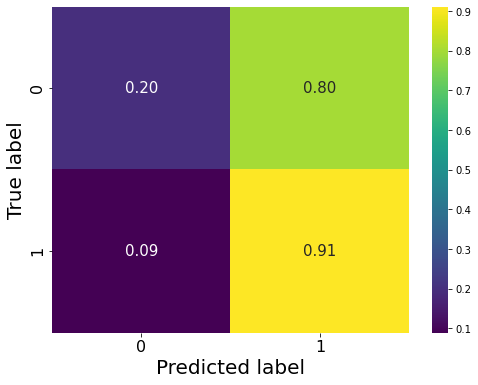

In [26]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.

In [27]:
y_full = csdh_min['recurrence']
X_full = csdh_min.drop(['recurrence'], axis=1)

In [28]:
# Split into validation set and rest
X_rest, X_test, y_rest, y_test = train_test_split(X_full, y_full, 
                                                test_size=0.20,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, 
                                                    test_size=0.20,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [29]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

[16:19:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
mmh.print_metrics_table(training_scores, val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
LR            0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
Linear SVM    0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
RBF SVM       0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
GB            0.892    0.491    0.000    0.000   3.742    0.935    0.648    0.295    0.456    2.249
RF            0.875    0.482    0.000    0.000   4.317    0.987    0.932    0.864    0.927    0.435
XGB           0.900    0.495    0.000    0.000 

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [31]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_5,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='log2',
                                            n_estimators=94, random_state=100,
                                            subsample=0.9))])
cv score: [0.47706422 0.56565657 0.49705387 0.58838384 0.61616162]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.53711426 0.29755892 0.58164983 0.43055556 0.53030303]
----------------------------------------
Trial 14
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='log2',
                                            n_estimators=70, random_state=100,
                                            subsample=0.7))])
cv score: [0.37864887 0.41245791 0.62415825 0.44949495 0.63720539]
----------------------------------------
Trial 15
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=

cv score: [0.57631359 0.67760943 0.66666667 0.56860269 0.5273569 ]
----------------------------------------
Trial 24
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=15, random_state=100,
                                            subsample=0.8))])
cv score: [0.56422018 0.52020202 0.64772727 0.53829966 0.56649832]
----------------------------------------
Trial 25
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
        

cv score: [0.59841535 0.56860269 0.55050505 0.52314815 0.56102694]
----------------------------------------
Trial 34
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='log2',
                                            n_estimators=91, random_state=100,
                                            subsample=0.9))])
cv score: [0.50792327 0.58417508 0.51136364 0.60606061 0.59090909]
----------------------------------------
Trial 35
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=

cv score: [0.52043369 0.5959596  0.51641414 0.59175084 0.56481481]
----------------------------------------
Trial 44
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='log2',
                                            n_estimators=35, random_state=100,
                                            subsample=0.8))])
cv score: [0.45204337 0.57070707 0.47011785 0.56481481 0.55050505]
----------------------------------------
Trial 45
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_de

cv score: [0.47706422 0.57407407 0.49705387 0.56018519 0.52020202]
----------------------------------------
Trial 57
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=96,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.54045038 0.62121212 0.53451178 0.55681818 0.55597643]
----------------------------------------
Trial 67
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=126,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.59466222 0.67887205 0.65025253 0.51010101 0.51936027]
----------------------------------------
Trial 76
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=124,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.54879066 0.64478114 0.55850168 0.48737374 0.45833333]
----------------------------------------
Trial 86
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=46, random_state=100))])
cv score: [0.53252711 0.60016835 0.52609428 0.47979798 0.51978114]
----------------------------------------
Trial 87
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
     

cv score: [0.59132611 0.628367   0.61489899 0.496633   0.49284512]
----------------------------------------
Trial 96
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=140, random_state=100))])
cv score: [0.58048374 0.625      0.5513468  0.57575758 0.58291246]
----------------------------------------
Trial 97
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.46038365 0.45580808 0.48821549 0.48190236 0.46927609]
----------------------------------------
Trial 105
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=32,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.60633862 0.68181818 0.6489899  0.56607744 0.57239057]
----------------------------------------
Trial 114
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=26,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.52627189 0.63973064 0.50294613 0.44107744 0.50126263]
----------------------------------------
Trial 128
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=59, random_state=100,
                                            subsample=0.65))])
cv score: [0.51292744 0.59090909 0.56944444 0.58501684 0.64478114]
----------------------------------------
Trial 129
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.51292744 0.59385522 0.49200337 0.51262626 0.46085859]
----------------------------------------
Trial 139
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=108, random_state=100))])
cv score: [0.57631359 0.59806397 0.53872054 0.55723906 0.58501684]
----------------------------------------
Trial 140
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=95,
                                        random_

cv score: [0.60842369 0.66498316 0.63257576 0.59175084 0.58207071]
----------------------------------------
Trial 149
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='log2',
                                            n_estimators=199, random_state=100,
                                            subsample=0.8))])
cv score: [0.51626355 0.62121212 0.44949495 0.55597643 0.45580808]
----------------------------------------
Trial 150
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.52460384 0.6026936  0.51725589 0.58922559 0.5479798 ]
----------------------------------------
Trial 158
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=169,
                                        random_state=100))])
cv score: [0.52710592 0.5719697  0.53409091 0.57407407 0.63383838]
----------------------------------------
Trial 159
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                       

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=121,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.85, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.55212677 0.59385522 0.53240741 0.4469697  0.40193603]
----------------------------------------
Trial 170

cv score: [0.441201   0.61279461 0.4793771  0.5479798  0.54377104]
----------------------------------------
Trial 179
----------------------------------------
Parameters {'rf__n_estimators': 29, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=29,
                                        random_state=100))])
cv score: [0.50333611 0.58922559 0.51262626 0.58922559 0.62710438]
----------------------------------------
Trial 180
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                    

cv score: [0.55254379 0.70159933 0.46170034 0.53619529 0.41666667]
----------------------------------------
Trial 192
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=190,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.58757298 0.6540404  0.57323232 0.48190236 0.54335017]
----------------------------------------
Trial 202
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=93, random_state=100,
                                            subsample=0.9))])
cv score: [0.55045872 0.67003367 0.67213805 0.5547138  0.54713805]
----------------------------------------
Trial 203
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.61592994 0.64646465 0.59974747 0.58838384 0.53577441]
----------------------------------------
Trial 214
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=99,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.60341952 0.6489899  0.66582492 0.57281145 0.49957912]
----------------------------------------
Trial 225
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=105,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.53628023 0.59090909 0.56607744 0.51262626 0.5993266 ]
----------------------------------------
Trial 234
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=27,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.45371143 0.64983165 0.53914141 0.58333333 0.49200337]
----------------------------------------
Trial 245
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=60,
                               n_jobs=16, num_parallel_tree=1, random_state=10

cv score: [0.58090075 0.67887205 0.65867003 0.50883838 0.53030303]
----------------------------------------
Trial 256
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=12,
                                        random_state=100))])
cv score: [0.58632193 0.67255892 0.56734007 0.51683502 0.46422559]
----------------------------------------
Trial 257
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.50708924 0.59301347 0.53998316 0.49789562 0.43644781]
----------------------------------------
Trial 265
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            n_estimators=127, random_state=100,
                                            subsample=0.6))])
cv score: [0.52043369 0.59259259 0.51052189 0.51767677 0.50757576]
----------------------------------------
Trial 266
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
    

cv score: [0.58048374 0.67382155 0.59048822 0.47558923 0.53072391]
----------------------------------------
Trial 276
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=31,
                                        random_state=100))])
cv score: [0.56880734 0.65614478 0.59259259 0.56271044 0.54082492]
----------------------------------------
Trial 277
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=

cv score: [0.56797331 0.60521886 0.54587542 0.49158249 0.46085859]
----------------------------------------
Trial 287
----------------------------------------
Parameters {'gb__n_estimators': 153, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=153,
                                            random_state=100))])
cv score: [0.49624687 0.51430976 0.48358586 0.52861953 0.5993266 ]
----------------------------------------
Trial 288
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',


cv score: [0.6000834  0.6952862  0.58712121 0.57449495 0.58038721]
----------------------------------------
Trial 297
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.53628023 0.50757576 0.50715488 0.57996633 0.60690236]
----------------------------------------
Trial 308
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=36,
                               n_jobs=16, num_parallel_tree=1, random_state=10

cv score: [0.59549625 0.60521886 0.51893939 0.48653199 0.43813131]
----------------------------------------
Trial 321
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=137,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.4970809  0.59006734 0.55429293 0.49747475 0.52861953]
----------------------------------------
Trial 331
----------------------------------------
Parameters {'xgb__n_estimators': 83, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=83,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.41659716 0.3526936  0.60227273 0.59680135 0.5273569 ]
----------------------------------------
Trial 341
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=107,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.59966639 0.60984848 0.60058923 0.42718855 0.50126263]
----------------------------------------
Trial 354
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=29,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.58798999 0.65319865 0.59132997 0.56607744 0.53324916]
----------------------------------------
Trial 363
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=36, random_state=100,
                                            subsample=0.65))])
cv score: [0.49791493 0.6043771  0.49284512 0.61531987 0.60606061]
----------------------------------------
Trial 364
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.56713928 0.6729798  0.62962963 0.55892256 0.5206229 ]
----------------------------------------
Trial 376
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=175,
                                        random_state=100))])
cv score: [0.51292744 0.5290404  0.5462963  0.58249158 0.62962963]
----------------------------------------
Trial 377
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                

cv score: [0.6263553  0.63383838 0.59890572 0.5993266  0.58459596]
----------------------------------------
Trial 385
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=77,
                                        random_state=100))])
cv score: [0.61384487 0.66035354 0.71759259 0.53872054 0.53577441]
----------------------------------------
Trial 386
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=167, random_st

cv score: [0.55546289 0.62205387 0.49957912 0.51010101 0.43644781]
----------------------------------------
Trial 400
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.53544621 0.66582492 0.53324916 0.59259259 0.62373737]
----------------------------------------
Trial 410
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.49541284 0.5        0.48148148 0.46296296 0.55723906]
----------------------------------------
Trial 418
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=160,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.58798999 0.63762626 0.5290404  0.45538721 0.49200337]
----------------------------------------
Trial 428
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=16, random_state=100,
                                            subsample=0.75))])
cv score: [0.39908257 0.51178451 0.40151515 0.52146465 0.47979798]
----------------------------------------
Trial 429
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.4295246  0.49747475 0.4452862  0.50126263 0.44318182]
----------------------------------------
Trial 439
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=54,
                                        random_state=100))])
cv score: [0.47873228 0.55555556 0.48316498 0.56313131 0.63468013]
----------------------------------------
Trial 440
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.56713928 0.59553872 0.5719697  0.5479798  0.52693603]
----------------------------------------
Trial 452
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=140,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.5971643  0.62626263 0.50715488 0.43939394 0.46506734]
----------------------------------------
Trial 462
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=93,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.43619683 0.52188552 0.46338384 0.56144781 0.60185185]
----------------------------------------
Trial 472
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=72,
                                            random_state=100))])
cv score: [0.53461218 0.60143098 0.52525253 0.52104377 0.60353535]
----------------------------------------
Trial 473
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
      

cv score: [0.55754796 0.50631313 0.5976431  0.44107744 0.43981481]
----------------------------------------
Trial 485
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=54,
                                        random_state=100))])
cv score: [0.49291076 0.51725589 0.45875421 0.5719697  0.61700337]
----------------------------------------
Trial 486
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.61968307 0.64941077 0.59132997 0.59343434 0.56734007]
----------------------------------------
Trial 497
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=151,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.6501251  0.64772727 0.48484848 0.43602694 0.52946128]
----------------------------------------
Trial 507
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=116,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.58632193 0.6233165  0.44823232 0.43181818 0.49116162]
----------------------------------------
Trial 516
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=78,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.5412844  0.58459596 0.52314815 0.51094276 0.39604377]
----------------------------------------
Trial 525
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=56,
                                        random_state=100))])
cv score: [0.4295246  0.49747475 0.4452862  0.5016835  0.44318182]
----------------------------------------
Trial 526
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=82, random_state=

cv score: [0.57964971 0.61700337 0.59301347 0.42760943 0.46338384]
----------------------------------------
Trial 536
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=160, random_state=100))])
cv score: [0.59507923 0.59048822 0.5290404  0.50799663 0.54250842]
----------------------------------------
Trial 537
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=196, random_state=100))])
cv score: [0.58090075 0.68728956 0.6679292

cv score: [0.6117598  0.68139731 0.58543771 0.54250842 0.54545455]
----------------------------------------
Trial 545
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=98,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.58548791 0.57323232 0.5753367  0.48148148 0.51936027]
----------------------------------------
Trial 555
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.58381985 0.5976431  0.53493266 0.53156566 0.55597643]
----------------------------------------
Trial 566
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=134,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.56630525 0.59890572 0.53282828 0.57786195 0.56523569]
----------------------------------------
Trial 575
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=121,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.57547957 0.67213805 0.59301347 0.48316498 0.51304714]
----------------------------------------
Trial 586
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.59049208 0.65025253 0.59132997 0.58670034 0.53787879]
----------------------------------------
Trial 594
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=126,
                                            random_state=100))])
cv score: [0.50125104 0.60058923 0.51809764 0.52777778 0.56986532]
----------------------------------------
Trial 595
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_

cv score: [0.57464554 0.59848485 0.55092593 0.46717172 0.45328283]
----------------------------------------
Trial 606
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=193,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.61551293 0.60353535 0.621633   0.44107744 0.49200337]
----------------------------------------
Trial 614
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=12,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.56797331 0.63510101 0.53409091 0.48653199 0.41877104]
----------------------------------------
Trial 627
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=81,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.47414512 0.52651515 0.59259259 0.5206229  0.57239057]
----------------------------------------
Trial 636
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=79, random_state=100,
                                            subsample=0.7))])
cv score: [0.59174312 0.65193603 0.68897306 0.53745791 0.49452862]
----------------------------------------
Trial 637
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(step

cv score: [0.5558799  0.65319865 0.59638047 0.58754209 0.58754209]
----------------------------------------
Trial 648
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=153, random_state=100))])
cv score: [0.55379483 0.65656566 0.56691919 0.55976431 0.56355219]
----------------------------------------
Trial 649
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=25, random_state=100,
              

cv score: [0.63052544 0.64267677 0.60395623 0.57407407 0.5530303 ]
----------------------------------------
Trial 661
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=140, random_state=100))])
cv score: [0.58006672 0.68223906 0.65782828 0.51557239 0.53282828]
----------------------------------------
Trial 662
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.5704754  0.63173401 0.54924242 0.58333333 0.57575758]
----------------------------------------
Trial 672
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=173,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.59799833 0.5787037  0.5719697  0.43181818 0.48526936]
----------------------------------------
Trial 680
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=192, random_state=100,
                                            subsample=0.75))])
cv score: [0.56547123 0.66750842 0.62794613 0.55008418 0.53156566]
----------------------------------------
Trial 681
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.6088407  0.64225589 0.5290404  0.4469697  0.50715488]
----------------------------------------
Trial 690
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=190,
                                        random_state=100))])
cv score: [0.48623853 0.5753367  0.57617845 0.42087542 0.50252525]
----------------------------------------
Trial 691
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                           

Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=127,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.95, tree_method='exact',
     

cv score: [0.5971643  0.628367   0.54166667 0.45117845 0.4760101 ]
----------------------------------------
Trial 712
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=145,
                                        random_state=100))])
cv score: [0.46872394 0.48484848 0.5256734  0.496633   0.48148148]
----------------------------------------
Trial 713
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=110, random_state=

cv score: [0.61801501 0.625      0.48442761 0.47180135 0.4229798 ]
----------------------------------------
Trial 722
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=108,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.65137615 0.58501684 0.59217172 0.48484848 0.43392256]
----------------------------------------
Trial 732
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=183,
                                        random_state=100))])
cv score: [0.60800667 0.67508418 0.71675084 0.53198653 0.56355219]
----------------------------------------
Trial 733
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators

cv score: [0.54795663 0.64393939 0.53829966 0.48232323 0.45833333]
----------------------------------------
Trial 745
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=197, random_state=100))])
cv score: [0.57464554 0.70328283 0.61069024 0.53872054 0.52693603]
----------------------------------------
Trial 746
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                               

cv score: [0.61968307 0.57281145 0.46927609 0.44949495 0.45496633]
----------------------------------------
Trial 758
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=22,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.54962469 0.58038721 0.63215488 0.55808081 0.47558923]
----------------------------------------
Trial 769
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=21, random_state=100))])
cv score: [0.47331109 0.56186869 0.51136364 0.40530303 0.54335017]
----------------------------------------
Trial 770
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=41, random_state=100))])
cv score: [0.55170976 0.70244108 0.64057239 0.

cv score: [0.48623853 0.60858586 0.59469697 0.49621212 0.5770202 ]
----------------------------------------
Trial 780
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=80, random_state=100))])
cv score: [0.53294412 0.61658249 0.56523569 0.5770202  0.55218855]
----------------------------------------
Trial 781
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.55129274 0.60858586 0.54840067 0.53156566 0.5206229 ]
----------------------------------------
Trial 789
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=168,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.40658882 0.44402357 0.49200337 0.51809764 0.44023569]
----------------------------------------
Trial 801
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=65,
                                        random_state=100))])
cv score: [0.60550459 0.65867003 0.72306397 0.54040404 0.51893939]
----------------------------------------
Trial 802
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators

cv score: [0.46121768 0.46927609 0.52104377 0.50925926 0.60353535]
----------------------------------------
Trial 814
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            n_estimators=29, random_state=100,
                                            subsample=0.95))])
cv score: [0.53419516 0.41750842 0.61658249 0.56776094 0.53240741]
----------------------------------------
Trial 815
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                 

cv score: [0.54045038 0.58164983 0.58459596 0.53872054 0.55387205]
----------------------------------------
Trial 824
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=57, random_state=100))])
cv score: [0.49958299 0.61279461 0.52525253 0.5530303  0.53914141]
----------------------------------------
Trial 825
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                  

cv score: [0.56213511 0.61447811 0.50968013 0.49158249 0.45412458]
----------------------------------------
Trial 836
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=84,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56380317 0.60774411 0.51304714 0.45707071 0.43476431]
----------------------------------------
Trial 847
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=158,
                                        random_state=100))])
cv score: [0.47206005 0.51893939 0.53114478 0.59848485 0.62121212]
----------------------------------------
Trial 848
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_es

cv score: [0.62593828 0.68686869 0.73021886 0.55639731 0.55008418]
----------------------------------------
Trial 859
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                            max_features='log2',
                                            n_estimators=142, random_state=100,
                                            subsample=0.9))])
cv score: [0.53127606 0.59090909 0.51641414 0.57239057 0.58670034]
----------------------------------------
Trial 860
----------------------------------------
Parameters {'rf__n_estimators': 30, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.5733945  0.64856902 0.55976431 0.58291246 0.57154882]
----------------------------------------
Trial 872
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=176,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.5471226  0.63215488 0.51052189 0.55892256 0.55639731]
----------------------------------------
Trial 882
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=12,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.61301084 0.60185185 0.58964646 0.52777778 0.63552189]
----------------------------------------
Trial 892
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=27,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.59007506 0.67718855 0.59006734 0.49915825 0.57112795]
----------------------------------------
Trial 904
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=168,
                                        random_state=100))])
cv score: [0.48915763 0.46127946 0.51010101 0.49410774 0.48947811]
----------------------------------------
Trial 905
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=55, random_st

cv score: [0.51876564 0.60185185 0.54335017 0.54292929 0.50757576]
----------------------------------------
Trial 916
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=44,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.53211009 0.34469697 0.56860269 0.52441077 0.60016835]
----------------------------------------
Trial 927
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            n_estimators=64, random_state=100,
                                            subsample=0.75))])
cv score: [0.50792327 0.61447811 0.45075758 0.50925926 0.5223064 ]
----------------------------------------
Trial 928
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                  

cv score: [0.52126772 0.62457912 0.52314815 0.54124579 0.51178451]
----------------------------------------
Trial 937
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=135, random_state=100,
                                            subsample=0.7))])
cv score: [0.57130942 0.59090909 0.56944444 0.56734007 0.60606061]
----------------------------------------
Trial 938
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.59633028 0.62542088 0.47853535 0.40656566 0.53493266]
----------------------------------------
Trial 946
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=48,
                                        random_state=100))])
cv score: [0.56964137 0.62752525 0.51346801 0.55681818 0.60058923]
----------------------------------------
Trial 947
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.52001668 0.62920875 0.5256734  0.47558923 0.49074074]
----------------------------------------
Trial 957
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=113, random_state=100,
                                            subsample=0.9))])
cv score: [0.52627189 0.63047138 0.53324916 0.53030303 0.52861953]
----------------------------------------
Trial 958
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booste

cv score: [0.48457048 0.60606061 0.5770202  0.51936027 0.57239057]
----------------------------------------
Trial 967
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=30, random_state=100,
                                            subsample=0.9))])
cv score: [0.51626355 0.58164983 0.49789562 0.51262626 0.54250842]
----------------------------------------
Trial 968
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps

cv score: [0.48915763 0.46127946 0.51010101 0.49410774 0.48863636]
----------------------------------------
Trial 978
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=183, random_state=100))])
cv score: [0.56046706 0.63341751 0.57281145 0.55050505 0.49452862]
----------------------------------------
Trial 979
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
           

cv score: [0.57673061 0.68055556 0.65361953 0.55850168 0.5273569 ]
----------------------------------------
Trial 986
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=155,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.50792327 0.58249158 0.57617845 0.53619529 0.47643098]
----------------------------------------
Trial 998
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=12, random_state=100))])
cv score: [0.58673895 0.63930976 0.66540404 0.55513468 0.5273569 ]
----------------------------------------
Trial 999
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10,
                                            max_features='sqrt',
                           

cv score: [0.63052544 0.65151515 0.60227273 0.59259259 0.58080808]
----------------------------------------
Trial 1011
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=186, random_state=100,
                                            subsample=0.95))])
cv score: [0.48206839 0.5513468  0.55681818 0.53703704 0.49747475]
----------------------------------------
Trial 1012
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.58048374 0.62373737 0.51304714 0.48484848 0.4229798 ]
----------------------------------------
Trial 1021
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='sqrt',
                                            n_estimators=27, random_state=100,
                                            subsample=0.65))])
cv score: [0.58465388 0.6763468  0.65909091 0.54587542 0.52609428]
----------------------------------------
Trial 1022
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Grad

cv score: [0.61718098 0.64436027 0.55176768 0.51767677 0.43897306]
----------------------------------------
Trial 1031
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=145, random_state=100,
                                            subsample=0.6))])
cv score: [0.50250209 0.59427609 0.46338384 0.52314815 0.37920875]
----------------------------------------
Trial 1032
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.6205171  0.55260943 0.52651515 0.53030303 0.53114478]
----------------------------------------
Trial 1042
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=131, random_state=100))])
cv score: [0.56630525 0.63762626 0.5753367  0.55387205 0.48442761]
----------------------------------------
Trial 1043
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='log2',
                              

cv score: [0.53794829 0.67003367 0.53072391 0.4537037  0.51557239]
----------------------------------------
Trial 1057
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=32,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.57214345 0.63510101 0.5273569  0.48316498 0.49957912]
----------------------------------------
Trial 1067
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=101, random_state=100))])
cv score: [0.56213511 0.63720539 0.54671717 0.54419192 0.54419192]
----------------------------------------
Trial 1068
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=66,
                              

cv score: [0.53878232 0.63131313 0.51052189 0.47011785 0.47516835]
----------------------------------------
Trial 1078
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=78, random_state=100))])
cv score: [0.56713928 0.59006734 0.56397306 0.55976431 0.58670034]
----------------------------------------
Trial 1079
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
                                            n_estimators=156, random_state=100,
         

cv score: [0.54670559 0.59048822 0.59301347 0.52609428 0.53703704]
----------------------------------------
Trial 1090
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=45,
                                        random_state=100))])
cv score: [0.45204337 0.45707071 0.46380471 0.50547138 0.44191919]
----------------------------------------
Trial 1091
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                         

cv score: [0.62885738 0.56144781 0.54335017 0.41245791 0.39941077]
----------------------------------------
Trial 1103
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=90,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.4912427  0.59006734 0.53998316 0.53367003 0.52146465]
----------------------------------------
Trial 1114
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                                            n_estimators=53, random_state=100,
                                            subsample=0.75))])
cv score: [0.50625521 0.59006734 0.51725589 0.5547138  0.55976431]
----------------------------------------
Trial 1115
----------------------------------------
Parameters {'rf__n_estimators': 59, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.55421184 0.65446128 0.59553872 0.48653199 0.49873737]
----------------------------------------
Trial 1128
----------------------------------------
Parameters {'rf__n_estimators': 59, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=59,
                                        random_state=100))])
cv score: [0.60175146 0.69654882 0.67171717 0.56565657 0.49242424]
----------------------------------------
Trial 1129
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.46038365 0.45580808 0.48821549 0.48148148 0.46927609]
----------------------------------------
Trial 1139
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=46,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.58298582 0.61742424 0.53409091 0.42087542 0.40277778]
----------------------------------------
Trial 1149
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=155,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.54545455 0.56691919 0.5702862  0.56397306 0.54587542]
----------------------------------------
Trial 1160
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=96, random_state=100,
                                            subsample=0.7))])
cv score: [0.52793995 0.60521886 0.50547138 0.63552189 0.56144781]
----------------------------------------
Trial 1161
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.53002502 0.60690236 0.60563973 0.54545455 0.55934343]
----------------------------------------
Trial 1172
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='log2',
                                            n_estimators=108, random_state=100,
                                            subsample=0.7))])
cv score: [0.53628023 0.34638047 0.5770202  0.53535354 0.60606061]
----------------------------------------
Trial 1173
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.52960801 0.63804714 0.58543771 0.56818182 0.55976431]
----------------------------------------
Trial 1185
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=75,
                                            random_state=100))])
cv score: [0.62885738 0.47180135 0.47558923 0.52651515 0.4983165 ]
----------------------------------------
Trial 1186
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',


cv score: [0.60091743 0.66792929 0.58712121 0.59006734 0.5223064 ]
----------------------------------------
Trial 1194
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=125, random_state=100,
                                            subsample=0.75))])
cv score: [0.58632193 0.44949495 0.67045455 0.37289562 0.45622896]
----------------------------------------
Trial 1195
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, bo

cv score: [0.5558799  0.61153199 0.53745791 0.47685185 0.50841751]
----------------------------------------
Trial 1206
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.65221018 0.68981481 0.59638047 0.54545455 0.58038721]
----------------------------------------
Trial 1216
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='log2',
                                            n_estimators=40, random_state=100,
                                            subsample=0.75))])
cv score: [0.45120934 0.56818182 0.52651515 0.62626263 0.4793771 ]
----------------------------------------
Trial 1217
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.36780651 0.54503367 0.44949495 0.48737374 0.70580808]
----------------------------------------
Trial 1226
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=104,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.5704754  0.69991582 0.60816498 0.53451178 0.51936027]
----------------------------------------
Trial 1237
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=158,
                                        random_state=100))])
cv score: [0.60800667 0.67508418 0.71590909 0.53282828 0.56355219]
----------------------------------------
Trial 1238
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                  

cv score: [0.54503753 0.64688552 0.64393939 0.49452862 0.50547138]
----------------------------------------
Trial 1249
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=125, random_state=100,
                                            subsample=0.65))])
cv score: [0.53794829 0.59848485 0.56186869 0.54713805 0.5462963 ]
----------------------------------------
Trial 1250
----------------------------------------
Parameters {'xgb__n_estimators': 158, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.51959967 0.52020202 0.40614478 0.4486532  0.52272727]
----------------------------------------
Trial 1260
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=78,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.56713928 0.63762626 0.5702862  0.55723906 0.49116162]
----------------------------------------
Trial 1272
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
                                            n_estimators=120, random_state=100,
                                            subsample=0.8))])
cv score: [0.52877398 0.62878788 0.59553872 0.56397306 0.61531987]
----------------------------------------
Trial 1273
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.61092577 0.68855219 0.68055556 0.56860269 0.58164983]
----------------------------------------
Trial 1283
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='log2',
                                            n_estimators=189, random_state=100,
                                            subsample=0.6))])
cv score: [0.52376981 0.62794613 0.58712121 0.58501684 0.57659933]
----------------------------------------
Trial 1284
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.54336947 0.64688552 0.65530303 0.51388889 0.47138047]
----------------------------------------
Trial 1293
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=65, random_state=100))])
cv score: [0.56255213 0.69991582 0.60732323 0.53745791 0.49242424]
----------------------------------------
Trial 1294
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=120,
                                        rando

cv score: [0.56255213 0.63762626 0.56776094 0.44654882 0.50631313]
----------------------------------------
Trial 1302
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=52, random_state=100))])
cv score: [0.5733945  0.68939394 0.63047138 0.50420875 0.52988215]
----------------------------------------
Trial 1303
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                              

cv score: [0.64386989 0.61658249 0.51136364 0.45117845 0.50505051]
----------------------------------------
Trial 1315
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=96, random_state=100))])
cv score: [0.53044204 0.60774411 0.55597643 0.52609428 0.54250842]
----------------------------------------
Trial 1316
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
           

cv score: [0.40992494 0.50294613 0.64141414 0.5206229  0.63720539]
----------------------------------------
Trial 1328
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='log2',
                                            n_estimators=38, random_state=100,
                                            subsample=0.7))])
cv score: [0.52793995 0.63720539 0.60227273 0.61952862 0.48737374]
----------------------------------------
Trial 1329
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.62510425 0.66372054 0.71338384 0.53745791 0.57112795]
----------------------------------------
Trial 1338
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=113,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.58298582 0.63846801 0.50462963 0.47727273 0.49031987]
----------------------------------------
Trial 1348
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=174, random_state=100,
                                            subsample=0.65))])
cv score: [0.53044204 0.57828283 0.57112795 0.52272727 0.50925926]
----------------------------------------
Trial 1349
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                            

cv score: [0.58715596 0.67213805 0.60984848 0.52946128 0.53914141]
----------------------------------------
Trial 1360
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=168, random_state=100))])
cv score: [0.59257715 0.59259259 0.5256734  0.50631313 0.54503367]
----------------------------------------
Trial 1361
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,

cv score: [0.60425354 0.63089226 0.59638047 0.52525253 0.57407407]
----------------------------------------
Trial 1368
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=195,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.53544621 0.62710438 0.54924242 0.56481481 0.59343434]
----------------------------------------
Trial 1380
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=165,
                                        random_state=100))])
cv score: [0.5675563  0.57744108 0.52946128 0.59090909 0.61111111]
----------------------------------------
Trial 1381
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                      

cv score: [0.5500417  0.61910774 0.53409091 0.50547138 0.55260943]
----------------------------------------
Trial 1393
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=65,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.49374479 0.56818182 0.50210438 0.5530303  0.53872054]
----------------------------------------
Trial 1403
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=190,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.56213511 0.61363636 0.51557239 0.47979798 0.47685185]
----------------------------------------
Trial 1414
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=175,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.4528774  0.5976431  0.52146465 0.53619529 0.53787879]
----------------------------------------
Trial 1426
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=89, random_state=100))])
cv score: [0.52126772 0.59890572 0.56860269 0.56228956 0.58585859]
----------------------------------------
Trial 1427
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
       

cv score: [0.48665555 0.5290404  0.49747475 0.57744108 0.63468013]
----------------------------------------
Trial 1437
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=143,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.57214345 0.63173401 0.54461279 0.56860269 0.56776094]
----------------------------------------
Trial 1447
----------------------------------------
Parameters {'rf__n_estimators': 25, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=25, random_state=100))])
cv score: [0.59924937 0.57154882 0.59427609 0.4793771  0.54335017]
----------------------------------------
Trial 1448
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=160,
                                        rando

cv score: [0.46872394 0.48484848 0.5256734  0.49705387 0.48148148]
----------------------------------------
Trial 1459
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=129, random_state=100,
                                            subsample=0.75))])
cv score: [0.51209341 0.59259259 0.59806397 0.51178451 0.48484848]
----------------------------------------
Trial 1460
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, bo

cv score: [0.56130108 0.61489899 0.50673401 0.45791246 0.5719697 ]
----------------------------------------
Trial 1468
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=143, random_state=100))])
cv score: [0.5558799  0.66708754 0.65530303 0.50042088 0.46590909]
----------------------------------------
Trial 1469
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                                

cv score: [0.52877398 0.57828283 0.5256734  0.57239057 0.53198653]
----------------------------------------
Trial 1481
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=174, random_state=100))])
cv score: [0.57297748 0.63005051 0.55387205 0.58080808 0.5753367 ]
----------------------------------------
Trial 1482
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
     

cv score: [0.59633028 0.56397306 0.57281145 0.4469697  0.57786195]
----------------------------------------
Trial 1490
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=16, random_state=100))])
cv score: [0.5412844  0.57912458 0.5479798  0.44444444 0.59848485]
----------------------------------------
Trial 1491
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                              

cv score: [0.62385321 0.5462963  0.57281145 0.3956229  0.48779461]
----------------------------------------
Trial 1499
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=13, random_state=100))])
cv score: [0.60758966 0.58164983 0.51094276 0.46085859 0.5959596 ]
----------------------------------------
Trial 1500
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=177,
                                        random_

cv score: [0.48623853 0.60858586 0.59638047 0.49621212 0.58038721]
----------------------------------------
Trial 1512
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            n_estimators=140, random_state=100,
                                            subsample=0.6))])
cv score: [0.53044204 0.55765993 0.46717172 0.54377104 0.5753367 ]
----------------------------------------
Trial 1513
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.59633028 0.61700337 0.56818182 0.52483165 0.54882155]
----------------------------------------
Trial 1521
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=170,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.5646372  0.63762626 0.51851852 0.55681818 0.59469697]
----------------------------------------
Trial 1531
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=176,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.60383653 0.64099327 0.63720539 0.56144781 0.55050505]
----------------------------------------
Trial 1542
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=92, random_state=100))])
cv score: [0.56130108 0.59469697 0.54545455 0.56607744 0.56565657]
----------------------------------------
Trial 1543
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.60967473 0.57954545 0.53577441 0.45454545 0.38341751]
----------------------------------------
Trial 1553
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56338616 0.68308081 0.65361953 0.5770202  0.56355219]
----------------------------------------
Trial 1565
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=157,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.63302752 0.6780303  0.65951178 0.56565657 0.55513468]
----------------------------------------
Trial 1575
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=63, random_state=100,
                                            subsample=0.8))])
cv score: [0.52627189 0.68013468 0.54335017 0.57828283 0.59680135]
----------------------------------------
Trial 1576
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.54336947 0.58333333 0.51052189 0.50042088 0.5273569 ]
----------------------------------------
Trial 1587
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=11,
                                        random_state=100))])
cv score: [0.40658882 0.44486532 0.49200337 0.51767677 0.44023569]
----------------------------------------
Trial 1588
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.4295246  0.49747475 0.4452862  0.50378788 0.44318182]
----------------------------------------
Trial 1597
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=143, random_state=100))])
cv score: [0.59549625 0.60016835 0.53030303 0.52777778 0.55513468]
----------------------------------------
Trial 1598
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=68,
                                        random_st

cv score: [0.59132611 0.68939394 0.65530303 0.55597643 0.56060606]
----------------------------------------
Trial 1606
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=169,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.48623853 0.64772727 0.59132997 0.53030303 0.56313131]
----------------------------------------
Trial 1618
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=96, random_state=100))])
cv score: [0.56338616 0.67887205 0.62920875 0.52609428 0.54461279]
----------------------------------------
Trial 1619
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                            

cv score: [0.58465388 0.60395623 0.55513468 0.50841751 0.40782828]
----------------------------------------
Trial 1631
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=131,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.57464554 0.67550505 0.62079125 0.57070707 0.6043771 ]
----------------------------------------
Trial 1641
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=135,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.59966639 0.62878788 0.51725589 0.48569024 0.43728956]
----------------------------------------
Trial 1651
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=39, random_state=100))])
cv score: [0.56880734 0.69023569 0.621633   0.49368687 0.55513468]
----------------------------------------
Trial 1652
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='log2',
                            

cv score: [0.48123436 0.46127946 0.48611111 0.49621212 0.43350168]
----------------------------------------
Trial 1662
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=174,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.55421184 0.66540404 0.64604377 0.51767677 0.46927609]
----------------------------------------
Trial 1672
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=180,
                                        random_state=100))])
cv score: [0.47789825 0.53998316 0.54166667 0.59259259 0.64057239]
----------------------------------------
Trial 1673
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimat

cv score: [0.41659716 0.61195286 0.46590909 0.47727273 0.56144781]
----------------------------------------
Trial 1685
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, n_estimators=137,
                                            random_state=100))])
cv score: [0.53878232 0.53661616 0.52651515 0.45791246 0.40740741]
----------------------------------------
Trial 1686
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_by

cv score: [0.55462886 0.64856902 0.62626263 0.56018519 0.53914141]
----------------------------------------
Trial 1695
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='log2',
                                            n_estimators=154, random_state=100,
                                            subsample=0.8))])
cv score: [0.48623853 0.43939394 0.60311448 0.54713805 0.47390572]
----------------------------------------
Trial 1696
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.48457048 0.56649832 0.55345118 0.56649832 0.52272727]
----------------------------------------
Trial 1708
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=148,
                                        random_state=100))])
cv score: [0.45204337 0.45707071 0.46380471 0.50631313 0.44191919]
----------------------------------------
Trial 1709
----------------------------------------
Parameters {'gb__n_estimators': 50, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                     

cv score: [0.57422852 0.58754209 0.49873737 0.46548822 0.58375421]
----------------------------------------
Trial 1722
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=26, random_state=100,
                                            subsample=0.7))])
cv score: [0.47456214 0.59427609 0.50462963 0.47390572 0.56018519]
----------------------------------------
Trial 1723
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                    

cv score: [0.4970809  0.6026936  0.50799663 0.55639731 0.51767677]
----------------------------------------
Trial 1736
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=136,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56088407 0.61742424 0.46422559 0.44570707 0.48695286]
----------------------------------------
Trial 1747
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            n_estimators=37, random_state=100,
                                            subsample=0.8))])
cv score: [0.53794829 0.68097643 0.55387205 0.52525253 0.43013468]
----------------------------------------
Trial 1748
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                               

cv score: [0.61134279 0.62247475 0.52819865 0.4452862  0.49200337]
----------------------------------------
Trial 1757
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='log2',
                                            n_estimators=127, random_state=100,
                                            subsample=0.95))])
cv score: [0.43953294 0.40446128 0.48274411 0.48989899 0.51515152]
----------------------------------------
Trial 1758
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.54545455 0.66287879 0.60058923 0.5273569  0.49158249]
----------------------------------------
Trial 1768
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=24, random_state=100))])
cv score: [0.50959133 0.63299663 0.55050505 0.57281145 0.57912458]
----------------------------------------
Trial 1769
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
           

cv score: [0.59507923 0.59890572 0.59890572 0.49368687 0.45664983]
----------------------------------------
Trial 1780
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=170, random_state=100))])
cv score: [0.55379483 0.62626263 0.54503367 0.51262626 0.54335017]
----------------------------------------
Trial 1781
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='sqrt',
                            

cv score: [0.40909091 0.48653199 0.50042088 0.4776936  0.46338384]
----------------------------------------
Trial 1790
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=57, random_state=100))])
cv score: [0.57798165 0.61153199 0.54545455 0.56060606 0.55723906]
----------------------------------------
Trial 1791
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='log2',
                            

cv score: [0.57547957 0.55976431 0.62247475 0.51262626 0.56818182]
----------------------------------------
Trial 1799
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=99,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.5646372  0.5959596  0.56691919 0.57828283 0.61195286]
----------------------------------------
Trial 1812
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=166,
                                        random_state=100))])
cv score: [0.4295246  0.49747475 0.4452862  0.50462963 0.44318182]
----------------------------------------
Trial 1813
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                   

cv score: [0.59966639 0.63678451 0.48274411 0.42424242 0.49705387]
----------------------------------------
Trial 1825
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=87, random_state=100))])
cv score: [0.55254379 0.66287879 0.65109428 0.51851852 0.46927609]
----------------------------------------
Trial 1826
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='sqrt',
                                   

cv score: [0.59799833 0.63973064 0.54671717 0.53198653 0.49368687]
----------------------------------------
Trial 1836
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=105,
                                        random_state=100))])
cv score: [0.40658882 0.44402357 0.49200337 0.51893939 0.44023569]
----------------------------------------
Trial 1837
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimat

cv score: [0.6030025  0.63425926 0.4793771  0.45538721 0.53577441]
----------------------------------------
Trial 1847
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=196,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.57214345 0.6540404  0.54755892 0.43771044 0.46422559]
----------------------------------------
Trial 1860
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=184,
                                        random_state=100))])
cv score: [0.46872394 0.48484848 0.5256734  0.49705387 0.48148148]
----------------------------------------
Trial 1861
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                         

cv score: [0.62552127 0.5530303  0.56691919 0.43939394 0.43139731]
----------------------------------------
Trial 1875
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=138, random_state=100))])
cv score: [0.58548791 0.5976431  0.5513468  0.50673401 0.5513468 ]
----------------------------------------
Trial 1876
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=68,
                                        random_st

cv score: [0.59507923 0.69276094 0.65782828 0.5479798  0.56776094]
----------------------------------------
Trial 1890
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=59, random_state=100,
                                            subsample=0.95))])
cv score: [0.53127606 0.46296296 0.43139731 0.50883838 0.56649832]
----------------------------------------
Trial 1891
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=

cv score: [0.63969975 0.63846801 0.51725589 0.44149832 0.43644781]
----------------------------------------
Trial 1902
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.55337781 0.65277778 0.56355219 0.58333333 0.56271044]
----------------------------------------
Trial 1911
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=76,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.62969141 0.69276094 0.58164983 0.58080808 0.60227273]
----------------------------------------
Trial 1923
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=39, random_state=100,
                                            subsample=0.6))])
cv score: [0.60091743 0.7003367  0.6986532  0.56944444 0.56018519]
----------------------------------------
Trial 1924
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.48290242 0.53409091 0.52861953 0.58796296 0.62373737]
----------------------------------------
Trial 1933
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=70,
                                        random_state=100))])
cv score: [0.57005838 0.65446128 0.61321549 0.57744108 0.53787879]
----------------------------------------
Trial 1934
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estim

cv score: [0.47789825 0.55976431 0.51557239 0.57070707 0.61026936]
----------------------------------------
Trial 1945
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=191,
                                        random_state=100))])
cv score: [0.46038365 0.45580808 0.48821549 0.48190236 0.46927609]
----------------------------------------
Trial 1946
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=14, random_st

cv score: [0.55713094 0.6010101  0.50715488 0.48989899 0.4212963 ]
----------------------------------------
Trial 1957
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=175, random_state=100))])
cv score: [0.57130942 0.63089226 0.55387205 0.58164983 0.5736532 ]
----------------------------------------
Trial 1958
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=138,
                                        ran

cv score: [0.49082569 0.54419192 0.49537037 0.5770202  0.60774411]
----------------------------------------
Trial 1970
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=158, random_state=100))])
cv score: [0.55379483 0.62542088 0.55008418 0.52356902 0.53661616]
----------------------------------------
Trial 1971
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.5029191  0.61111111 0.53072391 0.59511785 0.57491582]
----------------------------------------
Trial 1980
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=19,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.56672227 0.65782828 0.61742424 0.4983165  0.5239899 ]
----------------------------------------
Trial 1990
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=64, random_state=100))])
cv score: [0.55379483 0.58838384 0.56018519 0.55639731 0.59343434]
----------------------------------------
Trial 1991
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
       

cv score: [0.5646372  0.64520202 0.5206229  0.44360269 0.50294613]
----------------------------------------
Trial 2000
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=118, random_state=100))])
cv score: [0.55129274 0.61994949 0.56523569 0.56313131 0.60016835]
----------------------------------------
Trial 2001
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            n_estimators=12, random_state=100,
             

cv score: [0.44203503 0.60774411 0.49116162 0.50084175 0.53282828]
----------------------------------------
Trial 2012
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=86, random_state=100))])
cv score: [0.56296914 0.58796296 0.53703704 0.5702862  0.56397306]
----------------------------------------
Trial 2013
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                            

cv score: [0.52460384 0.56944444 0.55597643 0.58585859 0.63468013]
----------------------------------------
Trial 2022
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=64,
                                        random_state=100))])
cv score: [0.4295246  0.49747475 0.4452862  0.50126263 0.44318182]
----------------------------------------
Trial 2023
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                        

cv score: [0.64553795 0.6763468  0.60395623 0.58754209 0.55260943]
----------------------------------------
Trial 2033
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=161, random_state=100,
                                            subsample=0.65))])
cv score: [0.57714762 0.6010101  0.56860269 0.53872054 0.59090909]
----------------------------------------
Trial 2034
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.55379483 0.60816498 0.58796296 0.45707071 0.44823232]
----------------------------------------
Trial 2044
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=158, random_state=100))])
cv score: [0.57964971 0.61069024 0.56523569 0.51767677 0.54250842]
----------------------------------------
Trial 2045
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=135,
                                

cv score: [0.57422852 0.67592593 0.66287879 0.58080808 0.56102694]
----------------------------------------
Trial 2056
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=74,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.61217681 0.68771044 0.67045455 0.58080808 0.58880471]
----------------------------------------
Trial 2068
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=56,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.54587156 0.59385522 0.58585859 0.56649832 0.54377104]
----------------------------------------
Trial 2078
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=193, random_state=100))])
cv score: [0.5971643  0.60984848 0.54040404 0.51557239 0.56776094]
----------------------------------------
Trial 2079
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.63344454 0.68055556 0.67760943 0.5770202  0.54250842]
----------------------------------------
Trial 2089
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='log2',
                                            n_estimators=197,
                                            random_state=100))])
cv score: [0.54462052 0.48400673 0.54671717 0.42929293 0.47306397]
----------------------------------------
Trial 2090
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoos

cv score: [0.52877398 0.60816498 0.44234007 0.49957912 0.50883838]
----------------------------------------
Trial 2104
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='log2',
                                            n_estimators=120, random_state=100,
                                            subsample=0.6))])
cv score: [0.42785655 0.45917508 0.48989899 0.61868687 0.39983165]
----------------------------------------
Trial 2105
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.59549625 0.61195286 0.51725589 0.51346801 0.42718855]
----------------------------------------
Trial 2117
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=185,
                                        random_state=100))])
cv score: [0.40909091 0.48821549 0.50042088 0.4776936  0.46338384]
----------------------------------------
Trial 2118
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.57964971 0.60311448 0.56186869 0.45580808 0.46422559]
----------------------------------------
Trial 2126
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=19,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.60800667 0.68476431 0.65488215 0.55429293 0.50420875]
----------------------------------------
Trial 2135
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=52, random_state=100))])
cv score: [0.60675563 0.65277778 0.60732323 0.50673401 0.48569024]
----------------------------------------
Trial 2136
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=70, random_state=100))])
cv score: [0.53211009 0.58922559 0.51430976 0.500841

cv score: [0.57631359 0.62289562 0.58459596 0.42676768 0.43813131]
----------------------------------------
Trial 2149
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=106,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.59216013 0.60563973 0.51136364 0.48989899 0.39520202]
----------------------------------------
Trial 2159
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=49,
                                        random_state=100))])
cv score: [0.50041701 0.47895623 0.53324916 0.59048822 0.61658249]
----------------------------------------
Trial 2160
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estim

cv score: [0.6059216  0.68602694 0.63468013 0.5993266  0.57154882]
----------------------------------------
Trial 2171
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=137,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.60675563 0.65109428 0.57954545 0.46675084 0.49200337]
----------------------------------------
Trial 2182
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=188, random_state=100))])
cv score: [0.53961635 0.63005051 0.56439394 0.56060606 0.58333333]
----------------------------------------
Trial 2183
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            max_features='log2',
                         

cv score: [0.56797331 0.70159933 0.61489899 0.53619529 0.52777778]
----------------------------------------
Trial 2194
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            n_estimators=56, random_state=100,
                                            subsample=0.6))])
cv score: [0.51668057 0.65614478 0.56523569 0.50420875 0.49452862]
----------------------------------------
Trial 2195
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                             

cv score: [0.57297748 0.59469697 0.54545455 0.56355219 0.57407407]
----------------------------------------
Trial 2207
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=150,
                                        random_state=100))])
cv score: [0.46038365 0.45580808 0.48821549 0.48106061 0.46927609]
----------------------------------------
Trial 2208
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.54670559 0.58333333 0.53072391 0.59175084 0.56397306]
----------------------------------------
Trial 2216
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=18,
                                        random_state=100))])
cv score: [0.61843203 0.65572391 0.69991582 0.52272727 0.58796296]
----------------------------------------
Trial 2217
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_es

cv score: [0.50959133 0.66414141 0.61111111 0.53198653 0.69570707]
----------------------------------------
Trial 2229
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=195,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.58256881 0.67424242 0.67592593 0.54840067 0.53872054]
----------------------------------------
Trial 2239
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=29, random_state=100,
                                            subsample=0.7))])
cv score: [0.39449541 0.50252525 0.37920875 0.46212121 0.58038721]
----------------------------------------
Trial 2240
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                     

cv score: [0.60216847 0.60816498 0.50799663 0.46380471 0.49873737]
----------------------------------------
Trial 2252
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=104,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.5733945  0.64772727 0.61279461 0.53619529 0.54713805]
----------------------------------------
Trial 2265
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            n_estimators=179, random_state=100,
                                            subsample=0.9))])
cv score: [0.47122602 0.61447811 0.53324916 0.53198653 0.55176768]
----------------------------------------
Trial 2266
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
     

cv score: [0.61426188 0.68813131 0.68350168 0.57912458 0.59006734]
----------------------------------------
Trial 2275
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=53,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.56088407 0.68097643 0.62373737 0.53956229 0.55723906]
----------------------------------------
Trial 2284
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=116,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.60133445 0.67382155 0.6506734  0.58164983 0.53030303]
----------------------------------------
Trial 2295
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=79, random_state=100))])
cv score: [0.58340284 0.64941077 0.66624579 0.51388889 0.48484848]
----------------------------------------
Trial 2296
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.558799   0.60648148 0.59217172 0.44444444 0.53451178]
----------------------------------------
Trial 2304
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=12, random_state=100))])
cv score: [0.58673895 0.63930976 0.66540404 0.55513468 0.5273569 ]
----------------------------------------
Trial 2305
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                               

cv score: [0.50041701 0.52272727 0.45454545 0.56902357 0.61363636]
----------------------------------------
Trial 2316
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            max_features='log2',
                                            n_estimators=111, random_state=100,
                                            subsample=0.7))])
cv score: [0.54045038 0.61363636 0.59301347 0.61195286 0.56734007]
----------------------------------------
Trial 2317
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.54962469 0.65698653 0.51052189 0.43518519 0.52146465]
----------------------------------------
Trial 2324
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=97, random_state=100))])
cv score: [0.58173478 0.5787037  0.55345118 0.52272727 0.56607744]
----------------------------------------
Trial 2325
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
    

cv score: [0.53961635 0.61447811 0.53030303 0.55597643 0.55176768]
----------------------------------------
Trial 2335
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=51,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56964137 0.63804714 0.53240741 0.40740741 0.50210438]
----------------------------------------
Trial 2346
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, n_estimators=38,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.50041701 0.41287879 0.49284512 0.48316498 0.46801347]
----------------------------------------
Trial 2347
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, n_estimators=12,
                    

cv score: [0.52752294 0.60774411 0.48442761 0.43476431 0.55260943]
----------------------------------------
Trial 2360
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=53,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.53211009 0.26557239 0.58754209 0.62878788 0.39225589]
----------------------------------------
Trial 2369
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=95, random_state=100,
                                            subsample=0.65))])
cv score: [0.55629691 0.58333333 0.51388889 0.52272727 0.57491582]
----------------------------------------
Trial 2370
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5,

cv score: [0.49541284 0.61952862 0.59217172 0.53661616 0.58838384]
----------------------------------------
Trial 2378
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=84, random_state=100,
                                            subsample=0.8))])
cv score: [0.50792327 0.60984848 0.50631313 0.53367003 0.50294613]
----------------------------------------
Trial 2379
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.61801501 0.61279461 0.50883838 0.44360269 0.51052189]
----------------------------------------
Trial 2392
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=40, random_state=100))])
cv score: [0.55921601 0.70159933 0.61700337 0.52483165 0.49368687]
----------------------------------------
Trial 2393
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=28, random_state=100))])
cv score: [0.55129274 0.60185185 0.50294613 

cv score: [0.57589658 0.68392256 0.66624579 0.50294613 0.53030303]
----------------------------------------
Trial 2403
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=105, random_state=100))])
cv score: [0.58340284 0.67045455 0.66287879 0.53114478 0.54124579]
----------------------------------------
Trial 2404
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
   

cv score: [0.60550459 0.63762626 0.5702862  0.43602694 0.43223906]
----------------------------------------
Trial 2415
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=117, random_state=100))])
cv score: [0.58173478 0.6763468  0.65867003 0.51515152 0.52609428]
----------------------------------------
Trial 2416
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                             

cv score: [0.40325271 0.5736532  0.5787037  0.55892256 0.55008418]
----------------------------------------
Trial 2425
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=164,
                                        random_state=100))])
cv score: [0.48915763 0.46127946 0.51010101 0.49410774 0.48947811]
----------------------------------------
Trial 2426
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.57964971 0.63089226 0.54755892 0.47558923 0.4280303 ]
----------------------------------------
Trial 2436
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=134, random_state=100,
                                            subsample=0.65))])
cv score: [0.57297748 0.64941077 0.50547138 0.49410774 0.5479798 ]
----------------------------------------
Trial 2437
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.59174312 0.68644781 0.67255892 0.53409091 0.55850168]
----------------------------------------
Trial 2448
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='log2',
                                            n_estimators=14, random_state=100,
                                            subsample=0.65))])
cv score: [0.46955796 0.54587542 0.54166667 0.5239899  0.51515152]
----------------------------------------
Trial 2449
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.5675563  0.69654882 0.60648148 0.54335017 0.49537037]
----------------------------------------
Trial 2459
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='log2',
                                            n_estimators=30, random_state=100,
                                            subsample=0.9))])
cv score: [0.46705588 0.60900673 0.52651515 0.58838384 0.53787879]
----------------------------------------
Trial 2460
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.40909091 0.48821549 0.50042088 0.47685185 0.46338384]
----------------------------------------
Trial 2471
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, n_estimators=73,
                                            random_state=100))])
cv score: [0.59341118 0.64225589 0.46254209 0.51683502 0.61069024]
----------------------------------------
Trial 2472
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_b

cv score: [0.5145955  0.59175084 0.51893939 0.57239057 0.60858586]
----------------------------------------
Trial 2483
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=154,
                                        random_state=100))])
cv score: [0.46622185 0.51641414 0.51473064 0.48106061 0.48274411]
----------------------------------------
Trial 2484
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                     

cv score: [0.62218515 0.68728956 0.6233165  0.51388889 0.58501684]
----------------------------------------
Trial 2493
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=34,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.63094245 0.68686869 0.73021886 0.55639731 0.54419192]
----------------------------------------
Trial 2504
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=102,
                                        random_state=100))])
cv score: [0.46622185 0.51641414 0.51473064 0.48106061 0.48274411]
----------------------------------------
Trial 2505
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.54879066 0.62079125 0.54840067 0.52946128 0.47558923]
----------------------------------------
Trial 2516
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=138,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.57422852 0.70075758 0.64856902 0.51473064 0.54082492]
----------------------------------------
Trial 2529
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                                            n_estimators=11,
                                            random_state=100))])
cv score: [0.48123436 0.3989899  0.51893939 0.63047138 0.51473064]
----------------------------------------
Trial 2530
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estima

cv score: [0.53377815 0.54924242 0.53240741 0.51388889 0.45454545]
----------------------------------------
Trial 2538
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=104, random_state=100,
                                            subsample=0.85))])
cv score: [0.48457048 0.57996633 0.58712121 0.54461279 0.50589226]
----------------------------------------
Trial 2539
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.42577148 0.4486532  0.48063973 0.4760101  0.4520202 ]
----------------------------------------
Trial 2551
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=130, random_state=100,
                                            subsample=0.8))])
cv score: [0.55629691 0.64141414 0.5702862  0.56313131 0.50589226]
----------------------------------------
Trial 2552
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.48623853 0.6473064  0.59469697 0.49705387 0.5736532 ]
----------------------------------------
Trial 2561
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=117,
                                            random_state=100,
                                            subsample=0.65))])
cv score: [0.48957465 0.59343434 0.53324916 0.54040404 0.48316498]
----------------------------------------
Trial 2562
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=No

cv score: [0.5412844  0.57575758 0.59132997 0.53451178 0.57323232]
----------------------------------------
Trial 2575
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=155, random_state=100))])
cv score: [0.58465388 0.5993266  0.53998316 0.54124579 0.55892256]
----------------------------------------
Trial 2576
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                      

cv score: [0.46872394 0.48484848 0.5256734  0.49705387 0.48148148]
----------------------------------------
Trial 2587
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=42,
                                        random_state=100))])
cv score: [0.61009174 0.65656566 0.71801347 0.54082492 0.52356902]
----------------------------------------
Trial 2588
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimat

cv score: [0.58215179 0.60479798 0.53198653 0.56649832 0.5702862 ]
----------------------------------------
Trial 2599
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=151,
                               n_jobs=16, num_parallel_tree=1, r

cv score: [0.42243536 0.51767677 0.4537037  0.55429293 0.40951178]
----------------------------------------
Trial 2610
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=32, random_state=100))])
cv score: [0.50041701 0.61952862 0.51388889 0.51178451 0.58796296]
----------------------------------------
Trial 2611
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=129,
                                        random_st

cv score: [0.52668891 0.53619529 0.47306397 0.56144781 0.58754209]
----------------------------------------
Trial 2623
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=186,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.57172644 0.70664983 0.628367   0.51936027 0.53324916]
----------------------------------------
Trial 2636
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=97, random_state=100,
                                            subsample=0.8))])
cv score: [0.55129274 0.58164983 0.51304714 0.57996633 0.5993266 ]
----------------------------------------
Trial 2637
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.56713928 0.63762626 0.57281145 0.55639731 0.49116162]
----------------------------------------
Trial 2649
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=115,
                                        random_state=100))])
cv score: [0.47956631 0.52314815 0.53703704 0.60900673 0.61531987]
----------------------------------------
Trial 2650
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_

cv score: [0.64762302 0.66372054 0.50631313 0.4452862  0.4983165 ]
----------------------------------------
Trial 2661
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=183,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.61050876 0.62205387 0.51978114 0.47727273 0.44907407]
----------------------------------------
Trial 2670
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=90, random_state=100))])
cv score: [0.59216013 0.57659933 0.51178451 0.50294613 0.5256734 ]
----------------------------------------
Trial 2671
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=107,
                                        ran

cv score: [0.49958299 0.57659933 0.46675084 0.59175084 0.59511785]
----------------------------------------
Trial 2682
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            n_estimators=154, random_state=100,
                                            subsample=0.85))])
cv score: [0.56880734 0.55976431 0.51978114 0.54377104 0.59175084]
----------------------------------------
Trial 2683
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.56797331 0.58543771 0.48779461 0.43602694 0.50925926]
----------------------------------------
Trial 2692
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=170, random_state=100))])
cv score: [0.56797331 0.63762626 0.5770202  0.55808081 0.48779461]
----------------------------------------
Trial 2693
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.58715596 0.69023569 0.65614478 0.56986532 0.53577441]
----------------------------------------
Trial 2704
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=18,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.55337781 0.59301347 0.59511785 0.42003367 0.48484848]
----------------------------------------
Trial 2713
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=101,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.57464554 0.59385522 0.53156566 0.52104377 0.55345118]
----------------------------------------
Trial 2722
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=108,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.61384487 0.51178451 0.53998316 0.51515152 0.52272727]
----------------------------------------
Trial 2733
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=187, random_state=100))])
cv score: [0.5971643  0.60984848 0.54377104 0.51641414 0.56060606]
----------------------------------------
Trial 2734
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=103, random_state=100))])
cv score: [0.5383653  0.64099327 0.60732323 0.50

cv score: [0.5175146  0.54124579 0.46296296 0.57786195 0.60016835]
----------------------------------------
Trial 2745
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.54962469 0.66961279 0.57786195 0.54250842 0.55555556]
----------------------------------------
Trial 2757
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.49541284 0.5        0.48148148 0.46464646 0.5753367 ]
----------------------------------------
Trial 2769
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=43,
                                        random_state=100))])
cv score: [0.49499583 0.56986532 0.51304714 0.57154882 0.60185185]
----------------------------------------
Trial 2770
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                     

cv score: [0.49207673 0.57154882 0.50799663 0.55765993 0.54124579]
----------------------------------------
Trial 2780
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=28,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.56797331 0.63005051 0.55681818 0.48106061 0.49873737]
----------------------------------------
Trial 2789
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=28, random_state=100))])
cv score: [0.49291076 0.63594276 0.5479798  0.59638047 0.54124579]
----------------------------------------
Trial 2790
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
           

cv score: [0.52293578 0.65867003 0.51893939 0.55976431 0.54924242]
----------------------------------------
Trial 2801
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.51959967 0.59259259 0.53156566 0.54040404 0.51346801]
----------------------------------------
Trial 2813
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=88,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.53252711 0.64604377 0.56439394 0.47180135 0.49537037]
----------------------------------------
Trial 2822
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                                            n_estimators=147, random_state=100,
                                            subsample=0.65))])
cv score: [0.60967473 0.66245791 0.6489899  0.51767677 0.54040404]
----------------------------------------
Trial 2823
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.5442035  0.55892256 0.51262626 0.53872054 0.44907407]
----------------------------------------
Trial 2833
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=162,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.60383653 0.66456229 0.64983165 0.56271044 0.56355219]
----------------------------------------
Trial 2845
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=149, random_state=100,
                                            subsample=0.75))])
cv score: [0.52793995 0.58249158 0.57954545 0.56481481 0.58670034]
----------------------------------------
Trial 2846
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.48915763 0.46127946 0.51010101 0.49452862 0.48947811]
----------------------------------------
Trial 2860
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=153,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.60425354 0.63804714 0.59301347 0.52525253 0.57323232]
----------------------------------------
Trial 2869
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=28,
                                            random_state=100,
                                            subsample=0.85))])
cv score: [0.48957465 0.58249158 0.52483165 0.46380471 0.53914141]
----------------------------------------
Trial 2870
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=

cv score: [0.56547123 0.65151515 0.50126263 0.40909091 0.51809764]
----------------------------------------
Trial 2880
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=131,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.45788157 0.64814815 0.53409091 0.57659933 0.50294613]
----------------------------------------
Trial 2891
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=103, random_state=100,
                                            subsample=0.65))])
cv score: [0.46121768 0.60353535 0.53829966 0.57996633 0.59259259]
----------------------------------------
Trial 2892
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.5704754  0.61069024 0.5462963  0.56607744 0.57112795]
----------------------------------------
Trial 2904
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            n_estimators=48, random_state=100,
                                            subsample=0.8))])
cv score: [0.47206005 0.55723906 0.55092593 0.61111111 0.51094276]
----------------------------------------
Trial 2905
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=133,
     

cv score: [0.47956631 0.59890572 0.52146465 0.50757576 0.44107744]
----------------------------------------
Trial 2915
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=91, random_state=100))])
cv score: [0.53794829 0.58670034 0.58080808 0.49074074 0.54292929]
----------------------------------------
Trial 2916
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=82,
                                        random_stat

cv score: [0.59549625 0.56818182 0.5753367  0.53703704 0.57323232]
----------------------------------------
Trial 2926
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=168,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.60967473 0.61700337 0.59806397 0.46632997 0.44318182]
----------------------------------------
Trial 2935
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=32,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.51292744 0.50505051 0.46001684 0.56734007 0.55260943]
----------------------------------------
Trial 2946
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=35, random_state=100,
                                            subsample=0.75))])
cv score: [0.50542118 0.55808081 0.57954545 0.5479798  0.56481481]
----------------------------------------
Trial 2947
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.60258549 0.65530303 0.6489899  0.55639731 0.53872054]
----------------------------------------
Trial 2957
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=147, random_state=100))])
cv score: [0.56547123 0.71759259 0.60395623 0.53787879 0.51094276]
----------------------------------------
Trial 2958
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=69, random_state=100))])
cv score: [0.53669725 0.62415825 0.53745791 

cv score: [0.52210175 0.65151515 0.51557239 0.52441077 0.51599327]
----------------------------------------
Trial 2970
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=50, random_state=100))])
cv score: [0.57381151 0.60227273 0.50841751 0.46843434 0.5462963 ]
----------------------------------------
Trial 2971
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                       

cv score: [0.54545455 0.60395623 0.55513468 0.48947811 0.44991582]
----------------------------------------
Trial 2981
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=134,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.58673895 0.59722222 0.503367   0.48442761 0.52861953]
----------------------------------------
Trial 2992
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=26,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.55462886 0.55723906 0.61069024 0.50841751 0.57154882]
----------------------------------------
Trial 3003
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=97,
                                        random_state=100))])
cv score: [0.60800667 0.66287879 0.71675084 0.53030303 0.53829966]
----------------------------------------
Trial 3004
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estim

cv score: [0.64136781 0.57659933 0.63973064 0.52525253 0.51220539]
----------------------------------------
Trial 3015
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='log2',
                                            n_estimators=33, random_state=100,
                                            subsample=0.7))])
cv score: [0.57964971 0.58796296 0.64856902 0.56102694 0.51809764]
----------------------------------------
Trial 3016
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.61634696 0.62121212 0.53998316 0.47053872 0.48106061]
----------------------------------------
Trial 3026
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=174, random_state=100))])
cv score: [0.58798999 0.57744108 0.50715488 0.52651515 0.55513468]
----------------------------------------
Trial 3027
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=170, random_state=100))])
cv score: [0.59216013 0.6010101  0.5467171

cv score: [0.58381985 0.60185185 0.60732323 0.61952862 0.57239057]
----------------------------------------
Trial 3039
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=191,
                                        random_state=100))])
cv score: [0.58173478 0.65782828 0.62710438 0.55387205 0.54461279]
----------------------------------------
Trial 3040
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                 

cv score: [0.57798165 0.56776094 0.5770202  0.45959596 0.4229798 ]
----------------------------------------
Trial 3051
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=28, random_state=100,
                                            subsample=0.75))])
cv score: [0.40950792 0.42929293 0.61742424 0.35353535 0.52272727]
----------------------------------------
Trial 3052
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                

cv score: [0.53336113 0.53114478 0.55681818 0.52356902 0.49747475]
----------------------------------------
Trial 3063
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=102, random_state=100,
                                            subsample=0.65))])
cv score: [0.55963303 0.56313131 0.55850168 0.51767677 0.53956229]
----------------------------------------
Trial 3064
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,


cv score: [0.56380317 0.63383838 0.59301347 0.52188552 0.50757576]
----------------------------------------
Trial 3076
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            n_estimators=140, random_state=100,
                                            subsample=0.75))])
cv score: [0.48373645 0.61195286 0.50126263 0.55892256 0.52356902]
----------------------------------------
Trial 3077
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
    

cv score: [0.54879066 0.66919192 0.53409091 0.55892256 0.54208754]
----------------------------------------
Trial 3089
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.53753128 0.57659933 0.45075758 0.48442761 0.54082492]
----------------------------------------
Trial 3099
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=158, random_state=100,
                                            subsample=0.7))])
cv score: [0.56213511 0.6523569  0.57281145 0.54292929 0.53577441]
----------------------------------------
Trial 3100
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.56005004 0.61784512 0.59511785 0.5223064  0.49116162]
----------------------------------------
Trial 3109
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=169, random_state=100))])
cv score: [0.57589658 0.61531987 0.53998316 0.51010101 0.5462963 ]
----------------------------------------
Trial 3110
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.54462052 0.63005051 0.56018519 0.55976431 0.58670034]
----------------------------------------
Trial 3119
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=24,
                                        random_state=100))])
cv score: [0.39074229 0.47727273 0.48821549 0.51683502 0.65951178]
----------------------------------------
Trial 3120
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                                 

cv score: [0.55838198 0.60942761 0.64351852 0.46254209 0.52819865]
----------------------------------------
Trial 3134
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=77, random_state=100,
                                            subsample=0.7))])
cv score: [0.54462052 0.62289562 0.50968013 0.64057239 0.57491582]
----------------------------------------
Trial 3135
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.40783987 0.66245791 0.63089226 0.47348485 0.35816498]
----------------------------------------
Trial 3144
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=58,
                                        random_state=100))])
cv score: [0.47497915 0.55555556 0.48569024 0.56649832 0.63510101]
----------------------------------------
Trial 3145
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_est

cv score: [0.58048374 0.63930976 0.55429293 0.44360269 0.54503367]
----------------------------------------
Trial 3157
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=142,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.56130108 0.56481481 0.56860269 0.49158249 0.39520202]
----------------------------------------
Trial 3166
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=19,
                                        random_state=100))])
cv score: [0.60133445 0.66877104 0.70707071 0.52819865 0.57407407]
----------------------------------------
Trial 3167
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_esti

cv score: [0.48623853 0.61195286 0.48148148 0.46464646 0.56355219]
----------------------------------------
Trial 3177
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=11, random_state=100,
                                            subsample=0.6))])
cv score: [0.55671393 0.65361953 0.63720539 0.63552189 0.66372054]
----------------------------------------
Trial 3178
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.46497081 0.41708754 0.67382155 0.63846801 0.43392256]
----------------------------------------
Trial 3187
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=166, random_state=100))])
cv score: [0.60091743 0.58207071 0.49494949 0.53030303 0.55429293]
----------------------------------------
Trial 3188
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=84, random_state=100))])
cv score: [0.59299416 0.65193603 0.6696127

cv score: [0.63386155 0.63215488 0.49368687 0.4520202  0.50042088]
----------------------------------------
Trial 3199
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=56,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.59841535 0.65530303 0.66161616 0.53282828 0.52819865]
----------------------------------------
Trial 3208
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=67, random_state=100))])
cv score: [0.57756464 0.64604377 0.61574074 0.50841751 0.48737374]
----------------------------------------
Trial 3209
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
            

cv score: [0.52043369 0.44149832 0.46254209 0.50925926 0.4760101 ]
----------------------------------------
Trial 3219
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=170,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.61384487 0.63341751 0.5719697  0.50673401 0.4520202 ]
----------------------------------------
Trial 3231
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=87,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.33903253 0.46548822 0.45580808 0.6969697  0.5       ]
----------------------------------------
Trial 3242
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=79,
                                        random_state=100))])
cv score: [0.45537948 0.48989899 0.53787879 0.60058923 0.61784512]
----------------------------------------
Trial 3243
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.48623853 0.64772727 0.58964646 0.5290404  0.58501684]
----------------------------------------
Trial 3254
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=11,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.58465388 0.60479798 0.51136364 0.46759259 0.51641414]
----------------------------------------
Trial 3266
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=124,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.61217681 0.69023569 0.58880471 0.58501684 0.58712121]
----------------------------------------
Trial 3276
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=119,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.558799   0.621633   0.55681818 0.52693603 0.54503367]
----------------------------------------
Trial 3287
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=68,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.59507923 0.69318182 0.65109428 0.56102694 0.53409091]
----------------------------------------
Trial 3297
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=104, random_state=100))])
cv score: [0.53377815 0.61658249 0.5719697  0.56902357 0.5993266 ]
----------------------------------------
Trial 3298
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
     

cv score: [0.54503753 0.53493266 0.46464646 0.58796296 0.6010101 ]
----------------------------------------
Trial 3308
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=135,
                                        random_state=100))])
cv score: [0.51042535 0.52819865 0.50505051 0.57154882 0.63257576]
----------------------------------------
Trial 3309
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                  

cv score: [0.59382819 0.60984848 0.56944444 0.47222222 0.45075758]
----------------------------------------
Trial 3317
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=143, random_state=100))])
cv score: [0.58173478 0.68392256 0.65867003 0.51136364 0.53282828]
----------------------------------------
Trial 3318
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=51,
                                    

cv score: [0.59549625 0.621633   0.54250842 0.47895623 0.48358586]
----------------------------------------
Trial 3329
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=198, random_state=100,
                                            subsample=0.65))])
cv score: [0.53294412 0.57912458 0.54419192 0.49579125 0.54461279]
----------------------------------------
Trial 3330
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                               

cv score: [0.45204337 0.45707071 0.46380471 0.50547138 0.44191919]
----------------------------------------
Trial 3341
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=65, random_state=100))])
cv score: [0.58882402 0.59680135 0.49031987 0.48358586 0.53367003]
----------------------------------------
Trial 3342
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=176, random_state=100))])
cv score: [0.57214345 0.60732323 0.56607744 

cv score: [0.54045038 0.55850168 0.48526936 0.5239899  0.5530303 ]
----------------------------------------
Trial 3352
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            max_features='log2',
                                            n_estimators=19, random_state=100,
                                            subsample=0.7))])
cv score: [0.36447039 0.46548822 0.56439394 0.55808081 0.6010101 ]
----------------------------------------
Trial 3353
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.56630525 0.55765993 0.60185185 0.51641414 0.35353535]
----------------------------------------
Trial 3365
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=112,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.47539616 0.62121212 0.51893939 0.56481481 0.50084175]
----------------------------------------
Trial 3376
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=139,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.50375313 0.5702862  0.52483165 0.59259259 0.54292929]
----------------------------------------
Trial 3387
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            n_estimators=65, random_state=100,
                                            subsample=0.9))])
cv score: [0.50625521 0.60774411 0.48779461 0.5479798  0.50631313]
----------------------------------------
Trial 3388
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
     

cv score: [0.47623019 0.51430976 0.48947811 0.62962963 0.5496633 ]
----------------------------------------
Trial 3401
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='log2',
                                            n_estimators=106, random_state=100,
                                            subsample=0.8))])
cv score: [0.5529608  0.60606061 0.54250842 0.57239057 0.58164983]
----------------------------------------
Trial 3402
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.58840701 0.61658249 0.48863636 0.45075758 0.50420875]
----------------------------------------
Trial 3411
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3,
                                            max_features='sqrt',
                                            n_estimators=80, random_state=100,
                                            subsample=0.95))])
cv score: [0.58715596 0.63005051 0.48737374 0.55260943 0.56102694]
----------------------------------------
Trial 3412
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoost

cv score: [0.56713928 0.57407407 0.5290404  0.55892256 0.62626263]
----------------------------------------
Trial 3423
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=51,
                                        random_state=100))])
cv score: [0.49165972 0.53493266 0.49537037 0.56986532 0.60606061]
----------------------------------------
Trial 3424
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estim

cv score: [0.62718932 0.62457912 0.51978114 0.42424242 0.50883838]
----------------------------------------
Trial 3435
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=23,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.55212677 0.61279461 0.56439394 0.51851852 0.40025253]
----------------------------------------
Trial 3445
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=98, random_state=100,
                                            subsample=0.75))])
cv score: [0.6822352  0.67550505 0.42760943 0.40614478 0.50378788]
----------------------------------------
Trial 3446
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=101,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.61217681 0.64015152 0.55050505 0.45959596 0.52693603]
----------------------------------------
Trial 345

cv score: [0.60550459 0.61237374 0.54840067 0.48653199 0.46759259]
----------------------------------------
Trial 3470
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            n_estimators=18,
                                            random_state=100))])
cv score: [0.51959967 0.55092593 0.5547138  0.53030303 0.50715488]
----------------------------------------
Trial 3471
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',


cv score: [0.59049208 0.61700337 0.54419192 0.49410774 0.46759259]
----------------------------------------
Trial 3480
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=64,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.55212677 0.61826599 0.53619529 0.55976431 0.55050505]
----------------------------------------
Trial 3489
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=126,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.59382819 0.64183502 0.53409091 0.48400673 0.51388889]
----------------------------------------
Trial 3499
----------------------------------------
Parameters {'xgb__n_estimators': 156, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=156,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.52085071 0.67171717 0.60143098 0.50589226 0.56649832]
----------------------------------------
Trial 3509
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.55963303 0.66877104 0.58038721 0.54503367 0.5462963 ]
----------------------------------------
Trial 3518
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=126,
                                            random_state=100, subsample=0.6))])
cv score: [0.53211009 0.63552189 0.51725589 0.53872054 0.49915825]
----------------------------------------
Trial 3519
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=194, random_state=100))])
cv score: [0.55462886

cv score: [0.47206005 0.42340067 0.47011785 0.54040404 0.56818182]
----------------------------------------
Trial 3531
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            n_estimators=122, random_state=100,
                                            subsample=0.85))])
cv score: [0.53628023 0.621633   0.56271044 0.47390572 0.42255892]
----------------------------------------
Trial 3532
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5,

cv score: [0.5471226  0.61069024 0.5256734  0.53703704 0.47685185]
----------------------------------------
Trial 3544
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            n_estimators=20, random_state=100,
                                            subsample=0.95))])
cv score: [0.56130108 0.45117845 0.40446128 0.52651515 0.44823232]
----------------------------------------
Trial 3545
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, bo

cv score: [0.60758966 0.63089226 0.43855219 0.53956229 0.45664983]
----------------------------------------
Trial 3552
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=40,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.60508757 0.61405724 0.54755892 0.47348485 0.50210438]
----------------------------------------
Trial 3563
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=88,
                                        random_state=100))])
cv score: [0.46705588 0.49410774 0.53619529 0.61237374 0.61994949]
----------------------------------------
Trial 3564
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.56380317 0.53451178 0.63173401 0.42929293 0.41961279]
----------------------------------------
Trial 3575
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            n_estimators=97, random_state=100,
                                            subsample=0.95))])
cv score: [0.46121768 0.48484848 0.49873737 0.52356902 0.47222222]
----------------------------------------
Trial 3576
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                 

cv score: [0.60091743 0.67718855 0.64688552 0.54208754 0.54250842]
----------------------------------------
Trial 3588
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=122, random_state=100,
                                            subsample=0.95))])
cv score: [0.53044204 0.61574074 0.53661616 0.53030303 0.52104377]
----------------------------------------
Trial 3589
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.58965805 0.62962963 0.54335017 0.52609428 0.47853535]
----------------------------------------
Trial 3601
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=67,
                                            random_state=100, subsample=0.9))])
cv score: [0.50041701 0.64141414 0.54503367 0.51515152 0.45496633]
----------------------------------------
Trial 3602
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=46,
                            

cv score: [0.56547123 0.59511785 0.53829966 0.55218855 0.5959596 ]
----------------------------------------
Trial 3611
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=187, random_state=100))])
cv score: [0.55379483 0.61321549 0.54587542 0.55639731 0.57154882]
----------------------------------------
Trial 3612
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=69, random_state=100))])
cv score: [0.58882402 0.56860269 0.55892

cv score: [0.51376147 0.52819865 0.50925926 0.57323232 0.63089226]
----------------------------------------
Trial 3623
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=34, random_state=100,
                                            subsample=0.6))])
cv score: [0.55546289 0.63636364 0.50968013 0.60774411 0.57954545]
----------------------------------------
Trial 3624
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.62802335 0.61026936 0.54335017 0.48148148 0.39099327]
----------------------------------------
Trial 3633
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            n_estimators=128, random_state=100,
                                            subsample=0.85))])
cv score: [0.49374479 0.56818182 0.55345118 0.52946128 0.50673401]
----------------------------------------
Trial 3634
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, bo

cv score: [0.53044204 0.58754209 0.60479798 0.58249158 0.57239057]
----------------------------------------
Trial 3645
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=70,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.61050876 0.62121212 0.55934343 0.45538721 0.38678451]
----------------------------------------
Trial 3656
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            n_estimators=113, random_state=100,
                                            subsample=0.65))])
cv score: [0.50959133 0.62542088 0.4793771  0.55808081 0.50841751]
----------------------------------------
Trial 3657
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',


Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=68,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.59341118 0.63930976 0.55218855 0.47558923 0.49621212]
----------------------------------------
Trial 3670

cv score: [0.52376981 0.61405724 0.50126263 0.53367003 0.5530303 ]
----------------------------------------
Trial 3680
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=91,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.59049208 0.62542088 0.53409091 0.49494949 0.45244108]
----------------------------------------
Trial 3690
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=151, random_state=100))])
cv score: [0.54628857 0.63930976 0.53535354 0.56565657 0.55345118]
----------------------------------------
Trial 3691
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
  

cv score: [0.58048374 0.56607744 0.49873737 0.53577441 0.59048822]
----------------------------------------
Trial 3702
----------------------------------------
Parameters {'rf__n_estimators': 25, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=25,
                                        random_state=100))])
cv score: [0.6059216  0.68392256 0.68265993 0.53324916 0.56313131]
----------------------------------------
Trial 3703
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                   

cv score: [0.52543786 0.63173401 0.5787037  0.56481481 0.50547138]
----------------------------------------
Trial 3712
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=104,
                                        random_state=100))])
cv score: [0.40658882 0.44402357 0.49200337 0.51893939 0.44023569]
----------------------------------------
Trial 3713
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=4

cv score: [0.47497915 0.54124579 0.57786195 0.57239057 0.54587542]
----------------------------------------
Trial 3725
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='sqrt',
                                            n_estimators=81, random_state=100,
                                            subsample=0.85))])
cv score: [0.57381151 0.55892256 0.56691919 0.5479798  0.5959596 ]
----------------------------------------
Trial 3726
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
 

cv score: [0.58715596 0.62373737 0.49284512 0.39814815 0.48947811]
----------------------------------------
Trial 3737
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=141,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.70642202 0.57744108 0.58038721 0.4520202  0.53072391]
----------------------------------------
Trial 3748
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=136,
                                        random_state=100))])
cv score: [0.47956631 0.52483165 0.52525253 0.60227273 0.61742424]
----------------------------------------
Trial 3749
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
               

cv score: [0.43953294 0.63888889 0.6233165  0.59259259 0.5479798 ]
----------------------------------------
Trial 3761
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=102,
                                        random_state=100))])
cv score: [0.57089241 0.65025253 0.63299663 0.55387205 0.54545455]
----------------------------------------
Trial 3762
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                  

cv score: [0.52418682 0.64604377 0.54587542 0.43055556 0.5290404 ]
----------------------------------------
Trial 3773
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=152, random_state=100))])
cv score: [0.57506255 0.68223906 0.66287879 0.50715488 0.52946128]
----------------------------------------
Trial 3774
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='log2',
                           

cv score: [0.47539616 0.61111111 0.5719697  0.59175084 0.47895623]
----------------------------------------
Trial 3785
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=162, random_state=100,
                                            subsample=0.9))])
cv score: [0.49457882 0.64520202 0.47853535 0.53535354 0.51346801]
----------------------------------------
Trial 3786
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.62218515 0.58543771 0.55008418 0.46380471 0.49705387]
----------------------------------------
Trial 3796
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='log2',
                                            n_estimators=140, random_state=100,
                                            subsample=0.75))])
cv score: [0.29608007 0.58627946 0.68434343 0.49326599 0.46632997]
----------------------------------------
Trial 3797
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.57964971 0.68013468 0.64141414 0.53956229 0.53956229]
----------------------------------------
Trial 3808
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=166,
                                        random_state=100))])
cv score: [0.47623019 0.5206229  0.52861953 0.5993266  0.61952862]
----------------------------------------
Trial 3809
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                               

cv score: [0.61718098 0.67045455 0.56018519 0.47348485 0.5496633 ]
----------------------------------------
Trial 3820
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=64,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.47039199 0.53872054 0.50757576 0.56734007 0.63341751]
----------------------------------------
Trial 3831
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=159,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.57756464 0.70749158 0.628367   0.51683502 0.53324916]
----------------------------------------
Trial 3842
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=164,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.59799833 0.64520202 0.55555556 0.46127946 0.54250842]
----------------------------------------
Trial 3852
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            n_estimators=83, random_state=100,
                                            subsample=0.9))])
cv score: [0.50792327 0.56397306 0.53240741 0.57239057 0.52356902]
----------------------------------------
Trial 3853
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
              

cv score: [0.5704754  0.60900673 0.61910774 0.44486532 0.47180135]
----------------------------------------
Trial 3863
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=13,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.52293578 0.58417508 0.48190236 0.55050505 0.50757576]
----------------------------------------
Trial 3872
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.49374479 0.61616162 0.48611111 0.49789562 0.46085859]
----------------------------------------
Trial 3883
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=146, random_state=100,
                                            subsample=0.9))])
cv score: [0.52793995 0.5993266  0.54840067 0.54208754 0.49242424]
----------------------------------------
Trial 3884
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
 

cv score: [0.57798165 0.62878788 0.50462963 0.46548822 0.46843434]
----------------------------------------
Trial 3895
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=126,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.60216847 0.61237374 0.52146465 0.47306397 0.45917508]
----------------------------------------
Trial 3906
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=132,
                                        random_state=100))])
cv score: [0.54086739 0.53198653 0.46043771 0.58712121 0.6010101 ]
----------------------------------------
Trial 3907
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                               

cv score: [0.53878232 0.51010101 0.4760101  0.51893939 0.56902357]
----------------------------------------
Trial 3918
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=119, random_state=100))])
cv score: [0.55129274 0.65151515 0.55681818 0.54924242 0.55345118]
----------------------------------------
Trial 3919
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=27, random_state=100))])
cv score: [0.6205171  0.63594276 0.6780303  

cv score: [0.61426188 0.6729798  0.68518519 0.59217172 0.58080808]
----------------------------------------
Trial 3930
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=144, random_state=100,
                                            subsample=0.75))])
cv score: [0.56130108 0.57154882 0.56018519 0.53703704 0.58080808]
----------------------------------------
Trial 3931
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
     

cv score: [0.58173478 0.68476431 0.62584175 0.56986532 0.53703704]
----------------------------------------
Trial 3943
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=134,
                                        random_state=100))])
cv score: [0.5675563  0.58796296 0.52777778 0.58249158 0.61616162]
----------------------------------------
Trial 3944
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.63052544 0.61826599 0.60311448 0.48190236 0.44991582]
----------------------------------------
Trial 3955
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=150, random_state=100))])
cv score: [0.59341118 0.68434343 0.66161616 0.49031987 0.53282828]
----------------------------------------
Trial 3956
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='log2',
                         

cv score: [0.57214345 0.63173401 0.54461279 0.56860269 0.56776094]
----------------------------------------
Trial 3966
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=142,
                                        random_state=100))])
cv score: [0.59341118 0.60353535 0.61910774 0.47895623 0.51557239]
----------------------------------------
Trial 3967
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.61342786 0.68181818 0.64772727 0.55597643 0.53451178]
----------------------------------------
Trial 3975
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            n_estimators=53, random_state=100,
                                            subsample=0.95))])
cv score: [0.47914929 0.46885522 0.49957912 0.50420875 0.46843434]
----------------------------------------
Trial 3976
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
            

cv score: [0.52585488 0.62626263 0.48190236 0.42171717 0.51809764]
----------------------------------------
Trial 3986
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=152,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.5145955  0.58754209 0.50042088 0.57575758 0.58838384]
----------------------------------------
Trial 3996
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=154,
                                        random_state=100))])
cv score: [0.47706422 0.52146465 0.52946128 0.59427609 0.62121212]
----------------------------------------
Trial 3997
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.52335279 0.58670034 0.51851852 0.49284512 0.52314815]
----------------------------------------
Trial 4005
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=66, random_state=100))])
cv score: [0.53336113 0.61489899 0.51936027 0.50841751 0.52146465]
----------------------------------------
Trial 4006
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                             

cv score: [0.5971643  0.65698653 0.55176768 0.46127946 0.49031987]
----------------------------------------
Trial 4017
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=28,
                                        random_state=100))])
cv score: [0.56588824 0.66119529 0.59132997 0.56018519 0.54419192]
----------------------------------------
Trial 4018
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=16, random_

cv score: [0.54962469 0.63762626 0.5976431  0.48569024 0.51809764]
----------------------------------------
Trial 4029
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=38, random_state=100))])
cv score: [0.58548791 0.60143098 0.54587542 0.57449495 0.56860269]
----------------------------------------
Trial 4030
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            n_estimators=53, random_state=100,
                    

cv score: [0.5675563  0.64772727 0.62710438 0.56313131 0.5462963 ]
----------------------------------------
Trial 4039
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=111,
                                        random_state=100))])
cv score: [0.48040033 0.52483165 0.53619529 0.60984848 0.61405724]
----------------------------------------
Trial 4040
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_e

cv score: [0.62593828 0.68686869 0.73274411 0.55639731 0.54503367]
----------------------------------------
Trial 4051
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=155,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.59966639 0.6266835  0.52988215 0.50673401 0.46675084]
----------------------------------------
Trial 4060
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.55462886 0.66624579 0.58249158 0.4709596  0.50799663]
----------------------------------------
Trial 4072
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=64,
                                        random_state=100))])
cv score: [0.48623853 0.5753367  0.57617845 0.42087542 0.50252525]
----------------------------------------
Trial 4073
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2',
         

cv score: [0.54753962 0.66708754 0.58670034 0.47138047 0.59132997]
----------------------------------------
Trial 4082
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=36,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.46872394 0.48484848 0.5256734  0.49705387 0.48148148]
----------------------------------------
Trial 4092
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=68,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.50792327 0.62247475 0.53409091 0.57828283 0.55892256]
----------------------------------------
Trial 4103
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='sqrt',
                                            n_estimators=105, random_state=100,
                                            subsample=0.7))])
cv score: [0.50625521 0.58333333 0.56102694 0.63299663 0.56565657]
----------------------------------------
Trial 4104
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                              

cv score: [0.50458716 0.57154882 0.55345118 0.60521886 0.61279461]
----------------------------------------
Trial 4118
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                                            n_estimators=74, random_state=100,
                                            subsample=0.75))])
cv score: [0.48790659 0.61279461 0.48190236 0.60774411 0.50589226]
----------------------------------------
Trial 4119
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                

cv score: [0.58006672 0.68181818 0.67676768 0.57491582 0.53829966]
----------------------------------------
Trial 4129
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=99, random_state=100))])
cv score: [0.54837364 0.57996633 0.57659933 0.49494949 0.55639731]
----------------------------------------
Trial 4130
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=31, random_state=100))])
cv score: [0.59507923 0.68265993 0.64015152 0.49

cv score: [0.60050042 0.65319865 0.59638047 0.57996633 0.58207071]
----------------------------------------
Trial 4140
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            n_estimators=112, random_state=100,
                                            subsample=0.75))])
cv score: [0.45788157 0.48611111 0.53535354 0.46675084 0.64393939]
----------------------------------------
Trial 4141
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
      

cv score: [0.52460384 0.57407407 0.50883838 0.46548822 0.37920875]
----------------------------------------
Trial 4150
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='log2',
                                            n_estimators=72, random_state=100,
                                            subsample=0.7))])
cv score: [0.58173478 0.67424242 0.65446128 0.5719697  0.52651515]
----------------------------------------
Trial 4151
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBo

cv score: [0.52877398 0.58417508 0.51473064 0.53367003 0.60858586]
----------------------------------------
Trial 4165
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=55, random_state=100))])
cv score: [0.58757298 0.56944444 0.56523569 0.52693603 0.53829966]
----------------------------------------
Trial 4166
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
       

cv score: [0.53502919 0.61742424 0.53703704 0.58459596 0.53703704]
----------------------------------------
Trial 4174
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=160,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.63344454 0.68644781 0.59469697 0.5736532  0.54040404]
----------------------------------------
Trial 4184
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=101,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.5145955  0.56986532 0.54166667 0.60774411 0.60690236]
----------------------------------------
Trial 4194
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=106, random_state=100))])
cv score: [0.55129274 0.64267677 0.58880471 0.55260943 0.56397306]
----------------------------------------
Trial 4195
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=180, random_state=100))])
cv score: [0.55796497 0.61489899 0.54755

cv score: [0.52376981 0.62878788 0.49116162 0.59259259 0.4452862 ]
----------------------------------------
Trial 4208
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='log2',
                                            n_estimators=56, random_state=100,
                                            subsample=0.7))])
cv score: [0.42869058 0.53451178 0.43897306 0.45286195 0.37037037]
----------------------------------------
Trial 4209
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.53794829 0.59259259 0.54671717 0.45791246 0.3733165 ]
----------------------------------------
Trial 4219
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=33,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.57005838 0.64941077 0.58375421 0.58585859 0.58964646]
----------------------------------------
Trial 4227
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=24,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.56547123 0.64772727 0.60690236 0.49957912 0.58880471]
----------------------------------------
Trial 4237
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=96,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.58548791 0.60227273 0.54755892 0.45791246 0.39941077]
----------------------------------------
Trial 4249
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=125, random_state=100))])
cv score: [0.56130108 0.63257576 0.57112795 0.55387205 0.48947811]
----------------------------------------
Trial 4250
----------------------------------------
Parameters {'gb__n_estimators': 44, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            max_features='sqrt',
                              

cv score: [0.46872394 0.5959596  0.50462963 0.57407407 0.51767677]
----------------------------------------
Trial 4262
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='sqrt',
                                            n_estimators=109, random_state=100,
                                            subsample=0.75))])
cv score: [0.59841535 0.66792929 0.63047138 0.53661616 0.53409091]
----------------------------------------
Trial 4263
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xg

cv score: [0.56964137 0.58585859 0.5719697  0.44823232 0.5513468 ]
----------------------------------------
Trial 4271
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='log2',
                                            n_estimators=148, random_state=100,
                                            subsample=0.65))])
cv score: [0.52960801 0.60185185 0.58964646 0.53703704 0.58080808]
----------------------------------------
Trial 4272
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCla

cv score: [0.58465388 0.60227273 0.56523569 0.5273569  0.54755892]
----------------------------------------
Trial 4284
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=87,
                                        random_state=100))])
cv score: [0.48999166 0.49452862 0.52483165 0.59259259 0.60816498]
----------------------------------------
Trial 4285
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                 

cv score: [0.58423686 0.66035354 0.64814815 0.56060606 0.52777778]
----------------------------------------
Trial 4297
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.6))])
cv score: [0.53044204 0.56523569 0.64015152 0.64814815 0.57281145]
----------------------------------------
Trial 4298
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.53794829 0.62079125 0.58207071 0.56481481 0.50631313]
----------------------------------------
Trial 4311
----------------------------------------
Parameters {'xgb__n_estimators': 198, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=198,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.57631359 0.67845118 0.59175084 0.58459596 0.52819865]
----------------------------------------
Trial 4320
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=71, random_state=100))])
cv score: [0.53628023 0.62037037 0.54124579 0.55597643 0.54587542]
----------------------------------------
Trial 4321
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
     

cv score: [0.61050876 0.61868687 0.49621212 0.49074074 0.39941077]
----------------------------------------
Trial 4329
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=33,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.57881568 0.70075758 0.63804714 0.54882155 0.54713805]
----------------------------------------
Trial 4341
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=158, random_state=100,
                                            subsample=0.6))])
cv score: [0.59633028 0.59848485 0.61069024 0.56313131 0.50673401]
----------------------------------------
Trial 4342
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                               

cv score: [0.48874062 0.63552189 0.50799663 0.58501684 0.55050505]
----------------------------------------
Trial 4353
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=12,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.57923269 0.63005051 0.4983165  0.44276094 0.52861953]
----------------------------------------
Trial 4361
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=92,
                                        random_state=100))])
cv score: [0.46872394 0.48484848 0.5256734  0.49705387 0.48148148]
----------------------------------------
Trial 4362
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.56046706 0.56860269 0.57954545 0.50673401 0.43981481]
----------------------------------------
Trial 4372
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=169,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.53878232 0.61195286 0.56607744 0.56565657 0.60016835]
----------------------------------------
Trial 4382
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=54, random_state=100,
                                            subsample=0.85))])
cv score: [0.53961635 0.62079125 0.49789562 0.54208754 0.56186869]
----------------------------------------
Trial 4383
----------------------------------------
Parameters {'rf__n_estimators': 94, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.59549625 0.68476431 0.62037037 0.4983165  0.54419192]
----------------------------------------
Trial 4394
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=143,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.49541284 0.5        0.48148148 0.47895623 0.53998316]
----------------------------------------
Trial 4404
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.53377815 0.61658249 0.5719697  0.56902357 0.5993266 ]
----------------------------------------
Trial 4416
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='log2',
                                            n_estimators=28, random_state=100,
                                            subsample=0.6))])
cv score: [0.48915763 0.48232323 0.49116162 0.496633   0.48779461]
----------------------------------------
Trial 4417
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_d

cv score: [0.57631359 0.54377104 0.55597643 0.43097643 0.53914141]
----------------------------------------
Trial 4430
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=42,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.55546289 0.61447811 0.53072391 0.496633   0.46254209]
----------------------------------------
Trial 4440
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=132, random_state=100))])
cv score: [0.56213511 0.58291246 0.56902357 0.49705387 0.55892256]
----------------------------------------
Trial 4441
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=72, random_state=100,
                   

cv score: [0.63135947 0.60016835 0.628367   0.44023569 0.45328283]
----------------------------------------
Trial 4451
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=75,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.4295246  0.49747475 0.4452862  0.50210438 0.44318182]
----------------------------------------
Trial 4462
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=88,
                                        random_state=100))])
cv score: [0.50208507 0.50799663 0.52272727 0.58164983 0.62373737]
----------------------------------------
Trial 4463
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estim

cv score: [0.61092577 0.68097643 0.65446128 0.6026936  0.57323232]
----------------------------------------
Trial 4473
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=132,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.58298582 0.66456229 0.64941077 0.56691919 0.53409091]
----------------------------------------
Trial 4487
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='sqrt',
                                            n_estimators=41,
                                            random_state=100))])
cv score: [0.48623853 0.53451178 0.52146465 0.6043771  0.5513468 ]
----------------------------------------
Trial 4488
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
              

cv score: [0.56964137 0.66203704 0.67592593 0.48611111 0.47348485]
----------------------------------------
Trial 4498
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            n_estimators=118, random_state=100,
                                            subsample=0.9))])
cv score: [0.49541284 0.46212121 0.64688552 0.50757576 0.46212121]
----------------------------------------
Trial 4499
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boo

cv score: [0.57506255 0.68644781 0.66708754 0.50968013 0.51430976]
----------------------------------------
Trial 4510
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='log2',
                                            n_estimators=198,
                                            random_state=100))])
cv score: [0.58048374 0.56944444 0.60732323 0.5223064  0.54461279]
----------------------------------------
Trial 4511
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoosti

cv score: [0.52126772 0.54882155 0.53914141 0.57323232 0.60858586]
----------------------------------------
Trial 4522
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=177,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.59299416 0.67718855 0.6266835  0.57575758 0.52020202]
----------------------------------------
Trial 4533
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=44,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.57547957 0.37626263 0.62584175 0.54292929 0.46296296]
----------------------------------------
Trial 4546
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=107,
                               n_jobs=16, num_parallel_tree=1, r

cv score: [0.56630525 0.59427609 0.58375421 0.44612795 0.45496633]
----------------------------------------
Trial 4556
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=44, random_state=100))])
cv score: [0.43619683 0.64604377 0.58164983 0.56565657 0.50210438]
----------------------------------------
Trial 4557
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=160,
                                        random_stat

cv score: [0.65846539 0.61321549 0.4726431  0.43181818 0.50673401]
----------------------------------------
Trial 4569
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=76,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.49541284 0.5        0.48148148 0.46464646 0.57154882]
----------------------------------------
Trial 4579
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=19,
                                        random_state=100))])
cv score: [0.5942452  0.68602694 0.66077441 0.56986532 0.48232323]
----------------------------------------
Trial 4580
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estima

cv score: [0.73060884 0.45580808 0.56060606 0.59680135 0.59048822]
----------------------------------------
Trial 4589
----------------------------------------
Parameters {'gb__n_estimators': 153, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='log2',
                                            n_estimators=153, random_state=100,
                                            subsample=0.85))])
cv score: [0.55713094 0.56818182 0.5736532  0.51178451 0.5462963 ]
----------------------------------------
Trial 4590
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=123,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.9, tree_method='exact',
       

cv score: [0.55629691 0.58501684 0.50631313 0.53745791 0.44318182]
----------------------------------------
Trial 4611
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=189,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.43369475 0.54545455 0.55513468 0.57323232 0.61700337]
----------------------------------------
Trial 4622
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=34,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.61509591 0.65656566 0.58627946 0.51557239 0.5770202 ]
----------------------------------------
Trial 4634
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=168,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.54962469 0.62626263 0.53114478 0.55429293 0.53745791]
----------------------------------------
Trial 4643
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=57, random_state=100))])
cv score: [0.5500417  0.62962963 0.50841751 0.5496633  0.54335017]
----------------------------------------
Trial 4644
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            n_estimators=190,
                                  

cv score: [0.441201   0.61279461 0.46843434 0.54124579 0.52777778]
----------------------------------------
Trial 4655
----------------------------------------
Parameters {'xgb__n_estimators': 182, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=182,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.58465388 0.6523569  0.53324916 0.49410774 0.44318182]
----------------------------------------
Trial 4666
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=40,
                                            random_state=100))])
cv score: [0.50041701 0.43097643 0.45917508 0.51893939 0.46548822]
----------------------------------------
Trial 4667
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',


cv score: [0.53336113 0.53114478 0.55681818 0.52356902 0.49747475]
----------------------------------------
Trial 4675
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=97,
                                        random_state=100))])
cv score: [0.46622185 0.51641414 0.51473064 0.48106061 0.48274411]
----------------------------------------
Trial 4676
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                        

cv score: [0.54920767 0.58712121 0.51683502 0.59090909 0.61868687]
----------------------------------------
Trial 4688
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            n_estimators=118, random_state=100,
                                            subsample=0.85))])
cv score: [0.37739783 0.40993266 0.53198653 0.5290404  0.39351852]
----------------------------------------
Trial 4689
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                  

cv score: [0.58173478 0.68392256 0.63089226 0.56313131 0.52777778]
----------------------------------------
Trial 4701
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='log2',
                                            n_estimators=112, random_state=100,
                                            subsample=0.6))])
cv score: [0.53878232 0.61111111 0.60563973 0.59175084 0.57912458]
----------------------------------------
Trial 4702
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.63344454 0.68308081 0.5976431  0.57912458 0.53535354]
----------------------------------------
Trial 4715
----------------------------------------
Parameters {'gb__n_estimators': 45, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='log2',
                                            n_estimators=45, random_state=100,
                                            subsample=0.95))])
cv score: [0.4854045  0.53030303 0.54166667 0.61700337 0.5513468 ]
----------------------------------------
Trial 4716
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,


cv score: [0.47206005 0.60521886 0.53535354 0.57491582 0.54503367]
----------------------------------------
Trial 4727
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='log2',
                                            n_estimators=78, random_state=100,
                                            subsample=0.6))])
cv score: [0.53127606 0.64141414 0.53156566 0.54377104 0.59090909]
----------------------------------------
Trial 4728
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.57297748 0.63299663 0.49368687 0.43265993 0.54250842]
----------------------------------------
Trial 4737
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=103, random_state=100))])
cv score: [0.58715596 0.5976431  0.55765993 0.52693603 0.54587542]
----------------------------------------
Trial 4738
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.5646372  0.62457912 0.50210438 0.41498316 0.48947811]
----------------------------------------
Trial 4748
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=75,
                                        random_state=100))])
cv score: [0.46038365 0.45580808 0.48821549 0.48190236 0.46927609]
----------------------------------------
Trial 4749
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=135, random_st

cv score: [0.55754796 0.6523569  0.59301347 0.53072391 0.56734007]
----------------------------------------
Trial 4760
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='log2',
                                            n_estimators=15,
                                            random_state=100))])
cv score: [0.3882402  0.51641414 0.4726431  0.621633   0.60606061]
----------------------------------------
Trial 4761
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBo

cv score: [0.48915763 0.46127946 0.51010101 0.49242424 0.48947811]
----------------------------------------
Trial 4773
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=177,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.57422852 0.67550505 0.54713805 0.57617845 0.57407407]
----------------------------------------
Trial 4785
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=178,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.61551293 0.58459596 0.5206229  0.43602694 0.53240741]
----------------------------------------
Trial 4796
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=147, random_state=100))])
cv score: [0.58465388 0.63173401 0.5513468  0.57744108 0.58796296]
----------------------------------------
Trial 4797
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
 

cv score: [0.55462886 0.5976431  0.59217172 0.42508418 0.42718855]
----------------------------------------
Trial 4807
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            n_estimators=61, random_state=100,
                                            subsample=0.8))])
cv score: [0.51876564 0.58585859 0.55345118 0.5530303  0.51851852]
----------------------------------------
Trial 4808
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

cv score: [0.59966639 0.57912458 0.56018519 0.38636364 0.45917508]
----------------------------------------
Trial 4819
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=74, random_state=100))])
cv score: [0.58256881 0.64688552 0.66877104 0.51388889 0.49579125]
----------------------------------------
Trial 4820
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='log2',
                                            n_estimators=197, random_state=100,
                          

cv score: [0.59132611 0.60774411 0.54166667 0.56565657 0.44023569]
----------------------------------------
Trial 4828
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=24,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.56422018 0.61237374 0.54713805 0.52693603 0.5290404 ]
----------------------------------------
Trial 4837
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                                            n_estimators=111, random_state=100,
                                            subsample=0.75))])
cv score: [0.48123436 0.58754209 0.49116162 0.61363636 0.46801347]
----------------------------------------
Trial 4838
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.51209341 0.61111111 0.50210438 0.56902357 0.55976431]
----------------------------------------
Trial 4848
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=140, random_state=100,
                                            subsample=0.85))])
cv score: [0.56130108 0.56060606 0.46085859 0.56481481 0.57323232]
----------------------------------------
Trial 4849
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
     

cv score: [0.45496247 0.60816498 0.47853535 0.60858586 0.41035354]
----------------------------------------
Trial 4862
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=105,
                               n_jobs=16, num_parallel_tree=1, ra

cv score: [0.58840701 0.6489899  0.62247475 0.53240741 0.51473064]
----------------------------------------
Trial 4873
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=147,
                                        random_state=100))])
cv score: [0.48623853 0.5753367  0.57617845 0.42087542 0.50252525]
----------------------------------------
Trial 4874
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.56505421 0.51473064 0.5959596  0.58249158 0.48106061]
----------------------------------------
Trial 4885
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=192,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.58798999 0.63383838 0.51304714 0.46506734 0.44739057]
----------------------------------------
Trial 4895
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.54295246 0.47390572 0.59048822 0.496633   0.53030303]
----------------------------------------
Trial 4907
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=173, random_state=100))])
cv score: [0.53878232 0.628367   0.56776094 0.55639731 0.53240741]
----------------------------------------
Trial 4908
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=161, random_state=100))])
cv score: [0.57839867 0.59848485 0.55639731 0.49

cv score: [0.58798999 0.62920875 0.5273569  0.48400673 0.41624579]
----------------------------------------
Trial 4917
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                            n_estimators=56, random_state=100,
                                            subsample=0.85))])
cv score: [0.51292744 0.60984848 0.45412458 0.5702862  0.55050505]
----------------------------------------
Trial 4918
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.58090075 0.61026936 0.53114478 0.56565657 0.56649832]
----------------------------------------
Trial 4929
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=162, random_state=100))])
cv score: [0.59090909 0.5993266  0.54840067 0.50084175 0.55218855]
----------------------------------------
Trial 4930
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.44870726 0.60016835 0.53577441 0.51515152 0.50420875]
----------------------------------------
Trial 4939
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=69,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.56380317 0.61994949 0.64099327 0.4503367  0.48611111]
----------------------------------------
Trial 4948
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=82,
                                        random_state=100))])
cv score: [0.43452877 0.53451178 0.54587542 0.61153199 0.65109428]
----------------------------------------
Trial 4949
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.47664721 0.53956229 0.52483165 0.56018519 0.64351852]
----------------------------------------
Trial 4961
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.55629691 0.61784512 0.54166667 0.49326599 0.56228956]
----------------------------------------
Trial 4972
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            n_estimators=160, random_state=100,
                                            subsample=0.85))])
cv score: [0.45704754 0.54713805 0.43855219 0.50126263 0.50252525]
----------------------------------------
Trial 4973
----------------------------------------
Parameters {'xgb__n_estimators': 128, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.46121768 0.58922559 0.51725589 0.56818182 0.45959596]
----------------------------------------
Trial 4984
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=115,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.58924103 0.68855219 0.63930976 0.53745791 0.53451178]
----------------------------------------
Trial 4996
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=34,
                               n_jobs=16, num_parallel_tree=1, random

In [32]:
# best_estimator = RandomForestClassifier(bootstrap=False, max_depth=2,
#                                         max_features='log2', n_estimators=197,
#                                         random_state=100)

In [33]:
best_estimator.fit(X_rest, y_rest)

Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=123, random_state=100))])

In [34]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

Performance on the test set
Classification accuracy: 0.9060402684563759
AUROC: 0.5
Recall: 0.0
F1 Score: 0.0
Log-loss: 3.245254157911072


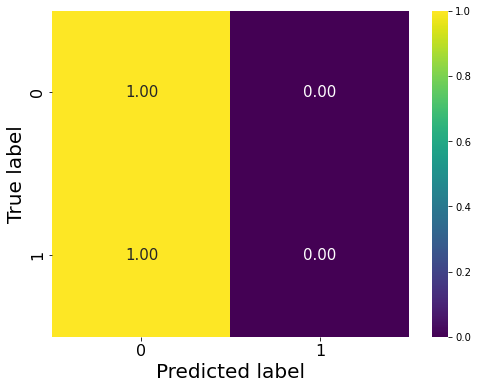

In [35]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])